# e0415557 Ng Zhili 2216 Assign 2

Note: Some snippets of code are taken and edited from the following websites.

Acknowledgements & References:
- https://github.com/lorentzenchr/Tutorial_freMTPL2/blob/master/glm_freMTPL2_example.ipynb
- https://poseidon01.ssrn.com/delivery.php?ID=139127066017102030014096113004018069054036085052058061088101005088115114095086018004098048016023118004125085028067127115116089023007070001017093002078125001066073037028091085083085029076120031064028114070101096116027016103109084097104120072068114089&EXT=pdf&INDEX=TRUE
- https://ideas.repec.org/a/gam/jrisks/v7y2019i3p71-d244533.html
- https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
- Machine Learning model codes adapted from Dr Quek Ser Aik

## Import Relevant Modules

In [1]:
## import os

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from scipy import stats as st
from scipy.stats import linregress
import scipy.optimize as optimize
import scipy.sparse as sparse
import scipy.special as special
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
import warnings
warnings.filterwarnings('ignore')  #suppress warning messages (those with peach background)
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Pre-Processing Functions

In [2]:
def add_verbosity(f):
    def helper(*args, **kwargs):
        verbose = kwargs.pop('verbose', True)
        
        # Redirect all output
        if not verbose:
            from io import StringIO
            import sys
            old_stdout = sys.stdout
            sys.stdout = StringIO()
        
            # Original function call
            result = f(*args, **kwargs)
        
            # Reconnect stdout
            sys.stdout = old_stdout
        
        else:
            result = f(*args, **kwargs)
            
        return result
    return helper

@add_verbosity
def preprocess(data, y_var):
    """Preprocessing code from Regressions.ipynb (Very handy!)"""
    global n, c
    global c, x_train, y_train, x_test, cr, cn, rl
    global cr, x_train, rl, x_test, cn, c
    global mf0, mf, y_train, x_train, t10, dm, fp, bic, aic, ar, gd, tv, dm0, dm3
    
    import time
    st0 = time.time()
    stm = st0

    #https://stackoverflow.com/questions/2828953/silence-the-stdout-of-a-function-in-python-without-trashing-sys-stdout-and-resto
    import sys, os
    # save_stdout = sys.stdout
    # sys.stdout = open('trash', 'w') #suppress %pdb message
    # #turns on auto debugging when crashing
    # %pdb on
    # #%autosave 60
    # sys.stdout = save_stdout
    # os.remove('trash')
    # del save_stdout, sys

    import warnings
    os.environ["PYTHONWARNINGS"] = 'ignore'
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #for tensorflow
    warnings.filterwarnings('ignore')
    #warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.simplefilter('ignore')
    #warnings.simplefilter('ignore', category=FutureWarning)
    #warnings.warn('deprecated', DeprecationWarning)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        warnings.simplefilter("ignore")
        warnings.warn("deprecated", DeprecationWarning)
    del warnings

    #much effort spent on computer RAM memory management; all computer CPU threads are used when possible
    from importlib import import_module
    #https://scikit-learn.org/stable/modules/computing.html?highlight=sklearn_seed
    #sets the random seed of the global random generator when running the tests, for reproducibility (failed):
    #SKLEARN_SEED = 26381

    def bpt():
        pass
        #for setting breakpoint() before Python 3.7
        # import_module('pdb').set_trace()
        #need to do 'n' to get out of this function, before debugging

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as pl

    #https://stackoverflow.com/questions/4981815/how-to-remove-lines-in-a-matplotlib-plot
    %matplotlib inline
    #pl.rcParams["figure.figsize"] = [6.000, 6.143] #square plot
    pl.rcParams['figure.figsize'] = [6.811, 7] #square plot
    pl.rcParams['lines.linewidth'] = 0.9

    print('Preparing data may take time...')

    #set parallel processing:
    sk = 'sklearn.'
    getattr(import_module(sk + 'utils'), 'parallel_backend')('loky', n_jobs=-1)
    getattr(import_module('sklearn'), 'set_config')(display='diagram')

    #read data from file:

    #the default 'dataset.csv' file will be read from the 'Documents' folder if nothing else is specified
    #alternate file names are 'dataset.xlsx', 'dataset.xlsm' & 'dataset.xls'
    #the first column is selected as Y-variable by default

    # '>>>>>'

    d = data
    yn = y_var #target variable

    if len(d) < 3:
        raise ValueError('Data has less than 3 rows.  Exiting...\n')
    elif d.shape[1] < 2:
        raise ValueError('Data has less than 2 columns.  Exiting...\n')
    elif 'yn' not in vars():
        yn = d.columns[0]
        print("First column '" + d.columns[0] + "' taken as the Y-variable.")
    else:
        try:
            if yn != d.columns[0]:
                d = d[[yn] + list(d.columns.drop(yn))]
            print("'" + yn + "' is the Y-variable.")
        except:
            raise ValueError("'" + yn + "' is designated as the Y-variable, but is not found in the dataset.  Exiting...\n")

    print('\nOriginal data has', f'{len(d):,}', 'rows and', f'{d.shape[1]:,}', 'columns.')
    if d.shape[1] < 52:
        print('\nFirst 3 rows:')
        print(d.head(3), '\n')
    else:
        print()

    def dtrim(d):
        #remove any useless column or row:
        global n, c #bad idea
        n = len(d)
        c = d.shape[1]
        while True:
            #delete any column of constant values:
            #d = d.loc[:, (d != d.iloc[0]).any()]
            d = d[d.columns[d.nunique(dropna=False) > 1]]
            if d.shape[1] < c:
                c = d.shape[1]
                #delete any row where all x-variables are missing
                #d = d.dropna(how='all', subset=[x for x in list(d) if x != yn])
                d = d.dropna(how='all', subset=list(d)[1:])
                if len(d) < n:
                    n = len(d)
                else:
                    break

            else:
                break
        return d
    d = dtrim(d)

    print('Results are unrepeatable because of desirable randomness introduced.\n')

    def prt(x, w=''):
        #print x's name before printing x
        #https://pypi.org/project/varname
        if w == '':
            print('\n' + [a for a in globals() if globals()[a] is x][0] + ':')
        else:
            print('\n' + w + ':')
        print(x)

    # [, ], < are not permitted in column name by xgboost 0.90 onwards
    for z in d.columns:
        if set('[]<') & set(z):
            d.rename(columns={z: z.translate(str.maketrans({'[': '{', ']': '}', '<': '≤'}))}, inplace=True)

    #parameters for model size are:
    #    mxx (True means go all the way for all models, except for mc restriction)
    #    s (max number of row; 0 means use all rows by default, but some models will still only use a subset of rows as determined by mn)
    #    mc (max number of X columns)
    #    mn (planned max number of minutes per model; mn=0 means no model time restriction)

    #mxx = True uses all rows and take as long as necessary for each model
    mxx = False
    if mxx:
        s = 0 #uses all rows
        mn = 0 #no time restriction for model
    else:
        #randomly pick subset of data

        print('Possibly subsetting data may take time (might hang & require a restart)...')
        #in a browser, click on the space to the left of the line numbers; when the border turns blue, type: 00, then click on Restart

        #mn = 1 #planned max minutes per model; for mn=3 & c=11, cs>2.983 to have effect
        mn = 2 #planned max minutes per model; for mn=3 & c=11, cs>2.983 to have effect, mn=0 means no model time restriction

        #s = 13334 #max number of rows to randomly use; 10000 (before deleting outliers) for x_train
        #s = n tries to use all rows, except for time restriction for each model; s = 0 uses all rows
        s = 20000

    #cs=0.324937 is from 'K-NN K-Nearest Neighbors', the borderline fast model:
    #default number of rows for a model

    mc = 50 #max number of Xs to select for use; the rest are discarded to save time

    print('\nSpecified size parameters: ' + f'\033[1m' + 'mxx (maxed out) =', mxx, ';  s (rows) =', s, ';  mc (# Xs) =', mc,
          ';  mn (minutes per model) =', str(mn) + f'\033[0m' + '\n')
    if s > 0:
        #s = min(s, n, int((mn / 0.324937)**0.2833 * 82368 / (c * 0.75))) #c=number of x variables
        s = min(s, n, int((mn / 0.324937)**0.2833 * 82368 / (mc * 0.75)) if mn > 0 else s) #c=number of x variables
    else:
        #use all rows:
        #may also set s=0 initially, then explicitly reduce s here
        #s = n
        s = n

    n0 = n
    d = dtrim(d[d[yn].notnull()]) #remove rows with missing y, redefines n & c

    if d[yn].nunique() == 2 and d[yn].dtypes == 'object':
        #non-numeric y has only 2 unique values; turn y into a dummy variable:
        yn0 = str(d[yn].value_counts().index[0]) #most-numerous category
        yn2 = yn + '_' + yn0
        d.rename(columns={yn : yn2}, inplace=True)
        yn = yn2
        d[yn] = (d[yn] == yn0) + 0
        del yn0, yn2

    if n > s:

        #random subsetting of rows:
        print('(To restart in a browser, click on the space to the left of the line numbers if necessary;',
              'when the left border is blue, type: 00, wait for a prompt to appear, then click on Restart.)\n')
        print('Initial random selection of', f'{s:,}', 'out of', f'{n:,}', 'rows for training & testing...\n')
        d = dtrim(d.sample(s))
        #n = len(d)

    #data size determined

    # #change y's type to float if necessary:
    # if d[yn].dtype != 'float' and d[yn].dtype != 'int':
    #     #'float' == 'float64'    'int' == 'int32'
    #     d[yn] = d[yn].astype('float')
    #rely instead on python duck typing

    #convert any date variable to 'days from 1970-01-01'

    #descending list of non-numeric columns' unique values:
    #uq = d[d.columns[d.dtypes == 'object']].nunique(dropna=False).sort_values(ascending=False)
    uq = d.iloc[:, 1:][list(d.columns[d.dtypes == 'object']) + list(d.columns[d.dtypes == 'datetime64[ns]']) +
           list(d.columns[d.dtypes == 'categorical'])].nunique(dropna=False)
    if len(uq) > 0:
        #convert any column of date strings or time strings into counts for 'days from 1970-01-01'
        for c in uq.index:
            try:
                # d['month'].dtypes == '<M8[ns]'
                #if d[c].isna().any():
                #    d[c] = d[c].apply(lambda x: pd.Timestamp(x).value/86400000000000 if x==x else x)
                #else:
                #    d[c] = d[c].apply(lambda x: round(pd.Timestamp(x).value/86400000000000))
                d[c] = d[c].apply(lambda x: pd.Timestamp(x).value/86400000000000 if x==x else x) if d[c].isna().any(
                ) else d[c].apply(lambda x: round(pd.Timestamp(x).value/86400000000000) if str(d[c].iloc[0]).find(':') == -1 or
                                  (str(d[c].iloc[0])[-9:] == ' 00:00:00' and str(d[c].iloc[-1])[-9:] == ' 00:00:00') else
                                  pd.Timestamp(x).value/86400000000000)
                uq.drop(c, inplace=True)
            except:
                pass

    #convert column with integers and NaNs from float64 to Int64 (NaN to pd.NA):

    # d = d[list(d.loc[:, d.dtypes == 'float64'])].apply(lambda x: np.int64(x))
    # d = d.astype(int, errors='ignore')
    #np.nan_to_num(d, copy=True, nan=pd.NA, posinf=pd.NA, neginf=pd.NA) #didn't work
    #d = d.convert_dtypes().apply(pd.to_numeric, downcast='integer', errors='ignore') #to_numeric cannot handle pd.NA
    d = d.convert_dtypes() #'Int64' is panda type; 'int64' (lower-case 'i') is numpy type

    # di = list(d.iloc[:, 1:].loc[:, d.dtypes == 'Int64']) #names of integer columns (not 'int64')
    #di = list(d.columns[d.dtypes == 'Int64']) #names of integer columns (not 'int64')
    di = list(d.iloc[:, 1:].columns[d.iloc[:, 1:].dtypes == 'Int64']) #names of integer columns (not 'int64')

    for a in di:
        if min(d[a].dropna()) > 1e+16:
            #could be a time variable
            d[a] = d[a] / 86400000000000 #convert into counts for 'days from 1970-01-01'
            #else, when column values are too big, OLS will fail with identical tvalues for all rows

    #categorical variables

    #need to cater for 57 categories in non-numeric column:
    #    50 U.S. states, 1 federal district, 5 inhabited territories, NaN
    #about 200 countries in world
    #367 categories a year, including any nan

    mxcat = 367 #any categorical variable with more than mxcat (367?) distinct values will be deleted

    #number of unique values not counting nan:
    di0 = d[di].nunique()
    #variables with more than 2 unique values, <= 367 unique values, and each value having at least 5 rows on average:
    di0 = di0[[e and f and g for (e, f, g) in zip(di0 + d[di].isnull().any() > 2, di0 <= mxcat, (d[di].notnull().sum() / di0) >= 5)]]
    di1 = [] #list of categorical variabes converted from integer variables
    di2 = [] #smallest integer, to be base category
    di1c = pd.DataFrame() #keep integer variables separately
    for a in di0.index:
        am = min(d[a].dropna())

        #if max(d[a].dropna()) - am < di0.loc[a]:
        #    #unique values are sequential, so could set as categorical

        di1c = pd.concat([di1c, d[a]], 1)
        d[a] = d[a].astype(str)
        di.remove(a)
        di1.append(a)
        di2.append(str(am))

    if 'am' in vars():
        del am

    cn = list(d)

    ##move y to front
    #if cn[0] != yn:
    #    cn.insert(0, cn.pop(cn.index(yn)))

    # #rearrange columns
    # d = d[cn]

    # #change any non-numeric y value to NaN
    # d[yn] = pd.to_numeric(d[yn], errors='coerce')

    # #delete any row where y is missing or all x-variables are missing
    #d = d[d[yn].notnull()].dropna(how='all', subset=[x for x in cn if x != yn])

    #above 2 steps may be merged into 1 step:df.loc[:, (df != df.iloc[0]).any()]
    #yn should actually not have any null by now:
    #d = d[cn][pd.to_numeric(d[yn], errors='coerce').notnull()].dropna(how='all', subset=[x for x in cn if x != yn])
    d = d[pd.to_numeric(d[yn], errors='coerce').notnull()].dropna(how='all', subset=cn[1:])

    dt = d.columns[d.dtypes == 'string']
    d[dt] = d[dt].astype(object)

    d = dtrim(d) #includes di1c columns
    cn = list(d)
    if len(di1c) > 0:
        di1c = di1c.loc[d.index, :]
        for a in [e for e in di1 if e not in cn]:
            di2.pop(di1.index(a))
            di1.remove(a)
            del di1c[a]

    #list of unique values of non-numeric variables & integer variables looking like categorical (di1)
    #uq = d[dt].nunique(dropna=False).sort_values(ascending=False)
    #in case there is any 'object' that is not 'string':
    uq = d[list(d.columns[d.dtypes == 'object']) + list(d.columns[d.dtypes == 'categorical'])].nunique(dropna=False
                                                                                              ).sort_values(ascending=False)
    uq1 = list(uq.index)
    #categorical variable with longer names will be dealth with first, in case some shorter name is the beginning of some longer one
    uq1.sort(key=len, reverse=True)
    uq = uq.loc[uq1]

    #uq = uq[uq > 1] #must have more than 1 unique value
    del dt

    if 'nu' in vars():
        del nu
    if len(uq) > 0:
        print('Number of unique values in', len(uq), 'non-numeric columns and', n, 'rows:')
        uq0 = pd.DataFrame(uq, columns=['unique'])
        print(uq0, '\n')

        #delete columns with more than 367 (leap year + nan) unique values:
        uq1 = uq.index[uq > mxcat] #names of cat variables with more than 367 categories
        d.drop(uq1, axis=1, inplace=True) #delete columns with too many categories
        uq.drop(uq1, inplace=True) #remove column with too many categories from list of counts of unique values
        del uq1

        uq3 = pd.DataFrame() #base category name
        u3 = 'base-category'
        u4 = 'count'
        if len(uq) > 0:
            week = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
            mnth = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
            dl = [] #collect names of base category in delete list
            for c in uq.index:
                if d[c].isnull().values.any():
                    uq3.loc[d[c].name, u3] = 'NaN'
                    uq3.loc[d[c].name, u4] = d[c].isnull().sum()
                elif (d[c] == '<NA>').any(): #'<NA>' in di1 list of variables converted from integers
                    uq3.loc[d[c].name, u3] = 'NaN'
                    uq3.loc[d[c].name, u4] = (d[c] == '<NA>').sum()
                    dl.append(d[c].name + '_' + '<NA>')
                else:
                    if c in di1:
                        #converted from integers
                        #bs = sorted(d[c])[0]
                        bs = di2[di1.index(c)] #smallest number
                        uq3.loc[d[c].name, u4] = (d[c] == bs).sum()
                    else:
                        ds1 = set(d[c])
                        ds = set([e[:3].lower() for e in ds1])
                        if ds.issubset(week) and len(ds) > 3:
                            for week1 in week:
                                try:
                                    bs = [i for i in sorted(ds1) if i.lower()[:3] == week1][0]
                                    uq3.loc[d[c].name, u4] = (d[c] == bs).sum()
                                    break
                                except:
                                    pass
                        elif ds.issubset(mnth) and len(ds) > 6:
                            for mnth1 in mnth:
                                try:
                                    bs = [i for i in sorted(ds1) if i.lower()[:3] == mnth1][0]
                                    uq3.loc[d[c].name, u4] = (d[c] == bs).sum()
                                    break
                                except:
                                    pass
                        else:
                            bs = ''
                        if bs == '':
                            #sorted categories alphabetically then reversely by len
                            #u = pd.Series(sorted(sorted(d[c]), key=len, reverse=True), name=d[c].name).value_counts()
                            #above value-counts() messed up the order achieved by sorted(sorted(d[c]), key=len, reverse=True)
                            u = d[c].value_counts()
                            uq3.loc[d[c].name, u4] = u.iloc[0]
                            #no default nan category as base, so base is category with largest count (mode)
                            bs = sorted(sorted(u[u == u.iloc[0]].index), key=len, reverse=True)[0]
                    #dl.append(bs)
                    dl.append(d[c].name + '_' + bs)
                    uq3.loc[d[c].name, u3] = bs
            del di2, week, mnth
            if 'bs' in vars():
                del bs
            if 'u' in vars():
                del u
            nu = d.columns.drop(uq.index) #names of numeric variables
            d = d[list(nu) + list(uq.index)] #ensure categorical variables with more categories are in front

            ##d[di1].replace(pd.NA, np.nan, inplace=True)
            ##di1c = d[di1].apply(pd.to_numeric, errors='ignore') #keep categorical variables converted from integers as int64
            ##keep categorical variables converted from integers as int64:

            #di1c = d[di1].replace(pd.NA, np.nan).replace('<NA>', np.nan).apply(pd.to_numeric, errors='ignore')

            ##create categorical dummies and move numerical variables to rear

            #original categorical variables automatically removed
            d = pd.get_dummies(d, prefix=uq.index, columns=uq.index, drop_first=False)

            #di1c = di1c[di1c.columns[di1c.nunique(dropna=False) > 2]] #keep columns with more than 2 distinct values

            di1 = list(di1c) #list of integer variables also with categorical dummies
            d = pd.concat([d, di1c], 1)
            nu = nu.append(di1c.columns)
            #move categorical dummies to front, integer columns to the rear:
            d = d[[yn] + list(d.columns.drop(list(nu) + dl)) + list(nu[1:])]
            del dl, di1c #keeping di1
            print('Some non-numeric columns changed into columns of 0-1 indicators.\n')

    d = d.apply(pd.to_numeric, errors='coerce') #convert any non-numeric-looking element to nan

    #n = len(d)
    #c = d.shape[1]
    d = dtrim(d) #local function to remove any useless column or row
    #n, c = dtrim(n, c, d)

    #could try hard to save data, or wastefully delete anything hard to handle

    #missing values imputation

    #https://scikit-learn.org/stable/modules/impute.html
    #https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

    impute_missing = True #change to False if imputation not desired

    nmv = sum(n - d.iloc[:, 1:].count())
    if impute_missing and nmv > 0:
        mnm = 75 #maximum allowable number of columns with missing #50
        mmv = 100000 #maximum allowable total number of missing values #5000
        dc = d.count()
        d.drop(d.columns[dc < len(d) * 2 / 3], axis=1, inplace=True) #delete columns with at least 1/3 missing
        dc = dc[list(d)] #count of non-missing for remaining columns

        xmiss = dc[d.columns[dc != len(d)]].sort_values().index #column names with manageable missing values
        #print(len(d.columns[dc > len(d)*19/20])) #number of columns with less than 5% missing
        #print('columns with integer type:', list(d.loc[:, d.dtypes == 'Int64']))
    else:
        xmiss = []
    if list(xmiss) != []:
        nmiss = len(xmiss) #number of columns with missing values
        if nmiss > mnm:
            #keep only mnm columns with missing values

            #d.drop(dc[xmiss].sort_values().index[:-mnm], axis=1, inplace=True) #keep only mnm columns of missing values
            d.drop(xmiss[:-mnm], axis=1, inplace=True) #keep only mnm columns of missing values
            xmiss = xmiss[-mnm:] #column names with manageable missing values
            nmiss = mnm
            dc = dc[list(d)] #count of non-missing for remaining columns
        dc = n - dc[xmiss][::-1] #number of missing for columns with manageable missing values
        nmv = sum(dc)
        if nmv > mmv:
            #reduce number of missing values to mmv

            nmv = dc.cumsum() #cumulative sum of missing values
            xmiss = dc[nmv <= mmv].index #names of columns with missing values to be imputed
            #keep only full columns & columns making up mmv missing values:
            d.drop(dc.loc[~dc.index.isin(xmiss)].index, axis=1, inplace=True)
            nmv = nmv.loc[xmiss[-1]] #number of missing values to be imputed
            nmiss = len(xmiss) #number of columns with missing values to be imputed
        c = d.shape[1]

        #choose columns for help in imputing missing values

        #principal component of column with missing values
        x_train = d.drop(list(xmiss) + [yn], axis=1) #all complete columns excluding y
        y_train = pd.Series([e[0] for e in getattr(import_module(sk + 'decomposition'), 'PCA')(n_components=1)
                             .fit_transform(d[xmiss].astype(float).fillna(d[xmiss].mean()))], x_train.index)
        x_test = x_train.iloc[-1, :] #just a placeholder for calling crx()
    else:
        impute_missing = False
        nmiss = 0

    def crx(tf):
        #construct corr(x,y)
        global c, x_train, y_train, x_test, cr, cn, rl
        c = x_train.shape[1]

        #put x with higher |corr(x,y)| closer to the front (for partial dependence plots):

        if tf or 'cr' not in vars():
            cr = pd.DataFrame() #for correlations with y
        rl = 'r(X_train,Y_train)'
        for v in x_train.columns[len(cr):]:
            #fill each row in the column with corr(x, y):
            #cr.loc[v, yn] = x_train[v].corr(y_train)
            cn = pd.concat([x_train[v], y_train], 1).corr().iloc[0, 1]
            cr.loc[v, rl] = 0 if np.isnan(cn) else cn
        cn = list(abs(cr).sort_values(rl, ascending=False).index)
        if c > 1:
            x_train = x_train[cn]
            x_test = x_test[cn]

    if impute_missing:
        #choose columns with higher correlations with PCA for imputing missing values

        crx(True)
        #cr.reindex(cr.iloc[:, 0].abs().sort_values(ascending=False).index) #sort by descending absolute correlation
        #columns' correlations with PCA > 0.05, + columns with missing values:
        d2 = cr.iloc[:, 0].abs().sort_values(ascending=False)[:50]
        d2 = d[[j for (i, j) in zip(d2, d2.index) if i > 0.05] + list(xmiss)]
        cn2 = [x for x in d.columns if x not in d2.columns]


    # if d.shape[1] < 52:
    #     print("Intermediate data's first 3 rows:")
    #     print(d.head(3), '\n')
    print('Intermediate data has', n, 'rows,', c, 'columns and', nmv, 'missing values.\n')

    if nmv > 0:
        if impute_missing:
            #impute_missing may be reset
            #trying too hard to save data?

            #imputation for x_train & x_test should be separately done
            if nmv > mmv or nmiss > mnm:
                print('More than', f'{mmv:,}', '(' + f'{nmv:,}' + ') missing values or more than', f'{mnm:,}',
                      '(' + f'{nmiss:,}' + ') variables with missing values, so no imputation will be done.\n')
                impute_missing = False
            else:
                print(f'{nmv:,}', 'missing values to be imputed altogether for' + (' the following' if nmiss < 31 else ''),
                      f'{nmiss:,}', 'Xs (may take much time)...')
                if nmiss < 31:
                    print(xmiss.tolist(), '\n')
                stm = time.time()

                #should first split into training & testing, and impute separately
                #imputation for any binary variable may be non-sensical:

                d2F = (d2.loc[:, d2.isnull().sum() > 0].dtypes == 'Float64').index
                if len(d2F) > 0:
                    d2.loc[:, d2F] = d2.loc[:, d2F].astype('float') #change pd 'Float' to np 'float'
                del d2F

                imp = 3 # 1 for KNNImputer, 2 for IterativeImputer, 3 for SimpleImputer

                if imp == 1:
                    #takes too long & doesn't always work
                    #https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
                    d2 = pd.DataFrame(getattr(import_module('sklearn.impute'), 'KNNImputer')(
                        weights='distance', copy=True, add_indicator=True)
                                     .fit_transform(d2), d2.index, list(d2) + [x + '_missing' for x in xmiss])
                elif imp == 2:
                    #https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
                    #https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html
                    from sklearn.experimental import enable_iterative_imputer
                    del enable_iterative_imputer

                    #d = pd.DataFrame(getattr(import_module('sklearn.impute'), 'IterativeImputer')(add_indicator=True)
                    #                 .fit_transform(d), d.index, list(d) + [x + '_missing' for x in xmiss])

                    d2 = pd.DataFrame(getattr(import_module('sklearn.impute'), 'IterativeImputer')(add_indicator=True)
                                     .fit_transform(d2), d2.index, list(d2) + [x + '_missing' for x in xmiss])
                else:
                    #seem to make more sense to just use the column average:
                    d2 = pd.DataFrame(getattr(import_module('sklearn.impute'), 'SimpleImputer')(add_indicator=True)
                                     .fit_transform(d2), d2.index, list(d2) + [x + '_missing' for x in xmiss])

                #change missing-value indicator to integer type
                d2[d2.columns[-nmiss:]] = d2[d2.columns[-nmiss:]].apply(pd.to_numeric, downcast='integer', errors='ignore')
                d = pd.concat([d[cn2], d2], 1)
                del cn2, d2

                tm = (time.time() - stm) / 60
                print('Imputation took', '%.2f' % tm, 'mins.\n')

            del dc, xmiss, mnm, mmv, nmv

            #d drastically salvaged

        if not impute_missing:
            #wasteful curling of data?
            d0 = d.copy()

            #approach 1:
            #delete any column with any missing value
            # for i in list(d)[1:]:
            #     if d[i].isnull().any():
            #         del d[i]
            d.dropna(1, inplace=True)

            #approach 2:
            #delete any row with any missing value
            d0.dropna(inplace=True)

            #columns cannot be more than rows; else, prefer more columns than rows
            if d0.shape[1] > d0.shape[0] - 1 or (d0.size - len(d0)) * 2 < d.size - len(d):
                del d0
            else:
                d = d0
            #d drastically cleaned

    #print(d[di1[0]].value_counts()) #check imputation for integer variable
    di = list(set([i for i in di if i in list(d)])) #list of integer columns still around
    #https://stackoverflow.com/questions/15891038/change-data-type-of-columns-in-pandas
    #convert imputed floats in any integer column to integers like int32 or int16:
    d[di] = round(d[di].astype(int)).apply(pd.to_numeric, downcast='integer', errors='ignore') if len(di) > 0 else d[di]

    di = set([i for i in (list(d)[:-nmiss] if nmiss > 0 else list(d)) if i not in di]) #names of float variables
    if len(di) > 0:
        #convert float64 to float32 to save space
        #d[di] = d[di].apply(pd.to_numeric, downcast='float', errors='ignore') if len(di) > 0 else d[di] #rhs can produce more columns than lhs!!
        #d[di] = pd.to_numeric(d[di], downcast='float', errors='ignore') if len(di) > 0 else d[di] #'casual' column always becomes 4 copies of same column
        for i in di:
            try:
                d[i] = pd.to_numeric(d[i], errors='ignore', downcast='float')
            except:
                d[i].iloc[:, 0] = pd.to_numeric(d[i].iloc[:, 0], errors='ignore', downcast='float') #whenever i='casual'

    del di, impute_missing, nmiss


    y = d[yn]
    x = d.iloc[:, 1:]

    #split into training & testing sets

    tp = 0.25 #default test/validation dataset proportion
    #from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = getattr(import_module(sk + 'model_selection'), 'train_test_split')(x, y, test_size=tp)

    x_train = dtrim(x_train)
    cn = list(x_train)
    if x_test.shape[1] > c: #c is set by dtrim
        x_test = x_test[cn]
    if len(y_train) > n: #n is set by dtrim
        y_train = y_train.loc[x_train.index]
    #n = len(x_train) #number of rows #set by dtrim
    #c = len(cn) #number of Xs or columns #set by dtrim
    print('Cleaned training data has', f'{n:,}', 'rows and', f'{c + 1:,}', 'columns.')

    def coll(i, sw=''):
        #delete collinear Xs
        #i = column of corr
        global cr, x_train, rl, x_test, cn, c

        dl = [] #collect collinear columns to be deleted
        c = len(cr) + 1
        while c > len(cr):
            c = len(cr)
            try:
                a = abs(cr.iloc[:, i]).sort_values(ascending=False).diff() > -0.0001
            except:
                a = abs(cr.iloc[:, i]).sort_values(rl, ascending=False).diff() > -0.0001
            for b in range(1, a.shape[0]):
                if a.iloc[b]:
                    if abs(pd.concat([x_train[a.index[b - 1]], x_train[a.index[b]]], 1).corr().iloc[1,0]) > 0.9999:
                        # deleting 1 X from correlated pair:
                        dv0 = a.index[b - 1]
                        dv1 = a.index[b]
                        dv = ''
                        #print(dv0,',',dv1)
                        #neither should already be deleted:
                        if not (dv0 in dl) and not (dv1 in dl):
                            #definitely have to delete 1
                            if sw != '':
                                if dv0.startswith(sw) + dv1.startswith(sw) == 1:
                                    #delete the categorical dummy
                                    if dv0.startswith(sw):
                                        dv = dv0
                                    else:
                                        dv = dv1
                            if dv == '':
                                #delete variable with lower corr with y:
                                if abs(cr.loc[dv0, rl]) > abs(cr.loc[dv1, rl]):
                                    dv = dv1
                                elif abs(cr.loc[dv0, rl]) < abs(cr.loc[dv1, rl]):
                                    dv = dv0
                                else:
                                    #equally correlated with y
                                    dm0 = len(dv0)
                                    dm1 = len(dv1)
                                    if dm0 == dm1:
                                        #delete variable with more '_':
                                        dv = dv0 if dv0.count('_') > dv1.count('_') else dv1
                                    else:
                                        #delete variable with longer name:
                                        dv = dv0 if dm0 > dm1 else dv1
                                    del dm0, dm1

                            dl.append(dv) # dv will be deleted
                            cr.drop([dv], axis=0, inplace=True) # delete from column of corr with yvar
                            #print("'" + d + "' is being deleted.")
                            del dv
                        #del dv0, dv1, dv

        if len(dl) > 0:
            x_train.drop(axis=1, columns=dl, inplace=True) #X variables deleted en masse
            cn = list(x_train)
            x_test = x_test[cn]
            print('\n' + str(len(dl)), 'collinear Xs deleted' + (':' if len(dl) < 51 else '.'))
            if len(dl) < 51:
                print(dl)
        c = x_train.shape[1]

    def ols1(y_train, x_train):
        #ols robust fitting
        from statsmodels.api import OLS, add_constant
        try:
            mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit()
        except:
            #SVD did not converge; try QR:
            try:
                mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(method='qr')
            except:
                try:
                    #SVD & QR did not converge; try robust covariance:
                    mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(cov_type='HC0')
                except:
                    try:
                        mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(method='qr', cov_type='HC0')
                    except:
                        try:
                            mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(cov_type='HC1')
                        except:
                            try:
                                mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(method='qr', cov_type='HC1')
                            except:
                                try:
                                    mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(cov_type='HC2')
                                except:
                                    try:
                                        mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(method='qr', cov_type='HC2')
                                    except:
                                        try:
                                            mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(cov_type='HC3')
                                        except:
                                            try:
                                                mf = OLS(y_train, add_constant(x_train), n_jobs=-1).fit(method='qr', cov_type='HC3')
                                            except:
                                                #OLS failed; first x will be deleted
                                                mf = []
        return mf

    def ols2(y_train, x_train, fr=0):
        #t-stats from ols robust fitting
        mf = ols1(y_train, x_train)
        if mf == []:
            #OLS failed; first x will be deleted
            return pd.Series([np.nan] * (x_train.shape[1] - fr), x_train.columns[fr:])
        else:
            return mf.tvalues[fr + 1:]

    #combining categorical dummies via t-stat among Xs, & f-pvalue, bic, aic & adj-r2 between models

    if 'nu' in vars():
        #names of numeric Xs & their _missing, sorted alphabetically then reversely by len:
        nu = sorted(sorted(list(set(list(nu) + [x + '_missing' for x in nu]) & set(x_train.columns))), key=len, reverse=True)
        uq1 = [e for e in cn if e not in nu] #complement of nu

        #if len(nu) > 1:
        if len(nu) > 0:
            #remove collinearity from numeric Xs
            x_train0 = x_train.copy()
            x_test0 = x_test.copy()
            x_train = x_train[nu] #the subset, for crx()
            crx(True)
            coll(0)
            nu = cn
            x_train = x_train0[nu + uq1]
            x_test = x_test0[nu + uq1]
            cn = list(x_train)
            c = len(cn)

        tv = abs(ols2(y_train, x_train))
        uq1 = list(tv.index.drop(nu)) #categorical dummies
        uq = [x + '_' for x in uq.index] #old categorical variables appended with '_'

        #categorical variables with dummies:
        uq = [x for x in uq if x in list(set([x for x in uq for y in uq1 if y.startswith(x)]))]
        uqc = [len([i for i in uq1 if i.startswith(uq[j])]) for j in range(len(uq))] #counts of categorical dummies for uq variables
        #uqc = pd.Series(uqc, uq).sort_values(ascending=False) #sorted counts of categorical dummies for uq variables
        uqc = pd.Series(uqc, uq) #important to retain original ordering

        fr = 20 #number of numerical Xs used to regroup categorical dummies; originally 10

        nui = tv[nu].sort_values(ascending=False).index
        t10 = [e for e in nui if e not in di1]
        fr = min(fr, len(t10)) #don't use x in di1 for collapsing categorical dummies, to avoid collinearity
        t10.extend([e for e in nui if e in di1]) #move di1 to end, but otherwise preserve order
        del di1
        nui = t10.copy()
        #t10 = list(tv[nu].sort_values(ascending=False)[:fr].index) #top 10 numerical variables
        t10 = list(nui[:fr]) #top 10 numerical variables
        cr10 = cr.loc[t10, :] #keep only 10, for crx(False)
        t11 = list(nui[fr:]) #rest of numerical variables
        #fr = len(t10)

        def refit():
            global mf0, mf, y_train, x_train, t10, dm, fp, bic, aic, ar, gd, tv, dm0, dm3
            mf0 = copy.deepcopy(mf) #keep for reverting at the end
            #mf = getattr(import_module('statsmodels.api'), 'OLS')(y_train, getattr(import_module('statsmodels.api'),
            #        'add_constant')(x_train[t10 + dm]), n_jobs=-1).fit()
            mf = ols1(y_train, x_train[t10 + dm])
            if mf == []:
                #SVD and QR did not converge
                fp1 = np.inf
                bic1 = np.inf
                aic1 = np.inf
                ar1 = -np.inf
                #tv = pd.Series([np.nan] * len(t10 + dm), x_train[t10 + dm].columns) #x shall be in random order
                if 'dm3' not in vars():
                    dm3 = abs(tv).sort_values(na_position='first').index #keep category dummy names sorted by ascending importance
                dm3 = [e for e in dm3 if e in dm] + list(set(dm) - set(dm3)) #put cat dummies with small abs(t) in front
                tv = pd.Series([np.nan] * len(dm), dm3) #bad cat dummy will be deleted first
            else:
                fp1 = np.inf if pd.isnull(mf.f_pvalue) else mf.f_pvalue
                bic1 = np.inf if pd.isnull(mf.bic) else mf.bic
                aic1 = np.inf if pd.isnull(mf.aic) else mf.aic
                ar1 = -np.inf if pd.isnull(mf.rsquared_adj) else mf.rsquared_adj
                tv = mf.tvalues[fr + 1:]
                dm3 = abs(tv).sort_values(na_position='first').index #keep category dummy names sorted by ascending importance
            gd = fp1 < fp or bic1 <= bic or aic1 <= aic or ar1 >= ar
            if gd:
                #reduced model better, so remove 1 more x later
                fp = min(fp1, fp)
                bic = min(bic1, bic)
                aic = min(aic1, aic)
                ar = max(ar1, ar)
                dm0 = dm.copy()
            elif len(tv) > 0:
                if max(abs(tv)) == 0 or tv.isnull().any():
                    gd = True
            return gd

        import copy
        uq2 = pd.DataFrame()
        u2 = 'indicators'
        ml = 35 #max len allowed for x-name combining categroies, so it would still fit well as vertical x-axis label
        for a in range(len(uqc)):
            #sort alphabetically, then reversely by len:
            stw = uqc.index[a] #categorical prefix
            dm = sorted(sorted([i for i in uq1 if i.startswith(stw)]), key=len, reverse=True) #categorical dummies
            uq1 = [z for z in uq1 if z not in dm] # uq1 - dm

            #remove any collinearity from f10 + dm caused by dm
            x_train0 = x_train.copy()
            x_test0 = x_test.copy()
            x_train = x_train[t10 + dm] #the subset, for crx()
            cr = cr10.copy()
            crx(False) #build on existing cr() for t10
            coll(0, stw) #delete only from dm, not t10
            dm = [e for e in dm if e in cn]

            #t10 = [e for e in t10 if e in cn]
            #fr = len(t10)

            x_train = x_train0
            x_test = x_test0
            cn = list(x_train)
            c = len(cn)

            fp = np.inf
            bic = np.inf
            aic = np.inf
            ar = -np.inf
            dm0 = dm.copy()
            mf = []

            #dimensionality reduction for columns

            #first, delete dummies with nearly 0 coefficients (they join base category)
            while True:
    #             if refit():
    #                 #look for another dummy to remove
    #                 if len(dm) > 0:
    #                     rm = abs(tv).sort_values(na_position='first').index[0]
    #                     dm.remove(rm)
    #                 else:
    #                     #entire categorical variable deleted: all its dummies removed
    #                     break
                #look for another dummy to remove
                refit()
                if len(dm) > 0:
                    rm = abs(tv).sort_values(na_position='first').index[0]
                    dm.remove(rm)
                else:
                    #all remaining dummies are useful; try combining them, 2 at a time
    #                 dm.append(rm)
                    dm = dm0
                    if len(dm) > 1:
                        dm = sorted(sorted(dm), key=len) #sort alphabetically, then by length
    #                     mf = mf0 #restart with saved model
                        tv = ols2(y_train, x_train[t10 + dm], fr)
                    while len(dm) > 1:
                        #sort index alphabetically then by len, then sort tv by size then difference it:
                        tv = tv[sorted(sorted(tv.index), key=len)].sort_values(na_position='first').diff()
                        rm = tv.index[[i for i, x in enumerate(tv[1:] == min(tv[1:])) if x][0]:][:2]  #coef pair of min diff
                        d1 = stw + '¯&¯'.join([e[len(stw):] for e in rm]) #new X's joined-name
                        #sum of dummies:
                        x_train[d1] = x_train[rm].sum(axis=1)
                        x_test[d1] = x_test[rm].sum(axis=1)
                        dm = [e for e in dm if e not in rm] #remove 2 dummies
                        dm.append(d1) #add joint dummy
                        dm = sorted(sorted(dm), key=len) #sort alphabetically, then by length
    #                     if not refit():
    #                         dm.remove(d1)
    #                         dm.extend(rm)
    #                         break
                        refit()
                        if len(dm) == 1:
                            dm = dm0
                            break

                    if len(dm) > 0:
                        print("\n'" + stw[:-1] + "' base category — '" + str(uq3.loc[stw[:-1], u3]) + "' :",
                              int(uq3.loc[stw[:-1], u4]), '(count)')
                        #any shortened name would appear here in full length in output:
                        print(len(dm), "'category : count' ↓")
                        # '36535356653a3655356653'.lstrip('365') == 'a3655356653'
                        #lstrip() strips more than just stw, but any character within stw:
                        #print('\n'.join([e.lstrip(stw) + ' : '+ str(int(sum(x_train[e]))) for e in dm]))
                        print('\n'.join([e[len(stw):] + ' : '+ str(int(sum(x_train[e]))) for e in dm]))
                        for b in [e for e in dm if len(e) > ml]:
                            #shorten any long name for vertical labels
                            b1 = len(b[:b.find('¯&¯')])
                            if b1 < len(b):
                                #has ¯&¯
                                b1 = max(min(b1 + 3, len(b)), ml - 3)
                                if b1 < len(b):
                                    b1 = b[:b1] + '...'
                                    dm.remove(b)
                                    dm.append(b1)
                                    x_train.rename(columns={b:b1}, inplace=True)
                                    x_test.rename(columns={b:b1}, inplace=True)
                            del b1
                        t11 = dm + t11
                        if 'b' in vars():
                            del b
                    uq2.loc[stw[:-1], u2] = len(dm)
                    #import collections; print([item for item, count in collections.Counter(t11).items() if count > 1])
                    break

        del ml
        if 'stw' in vars():
            del stw
        x_train = x_train[t10 + t11]
        x_test = x_test[t10 + t11]
        if x_train.shape[1] < c:
            print("\nSome non-numeric columns' indicators were reconfigured.")
            c = x_train.shape[1]
        if len(uq2) > 0:
            uq2 = uq2.astype(int)
            uq4 = pd.concat([uq0.loc[uq2.index, uq0.columns[0]], uq2, uq3.loc[uq2.index, u3]], 1)
            uq4 = uq4[uq4[uq4.columns[1]] > 0]
            #print(uq4[uq4[uq4.columns[1]] > 0])
            if len(uq4) > 0:
                print('\nNumber of indicators left, out of', len(uq2), 'non-numeric columns and', n, 'rows:')
                print(uq4)
            else:
                print('\nNo indicators left, out of', len(uq2), 'non-numeric columns and', n, 'rows.')
            del uq4
        #del copy #doesn't make sense
        if 'dm' in vars():
            del dm, tv, rm, gd, uq2, uq3, u2, u3, u4, rl, t10, t11, uq0
        if 'mf' in vars():
            del mf
        if 'mf0' in vars():
            del mf0
        if 'd1' in vars():
            del d1
        if 'fp' in vars():
            del fp, bic, aic, ar, dm0
        if 'dm3' in vars():
            del dm3

        #     #sorted tvalues of first categorical indicators:
        #     del x_train[tv.loc[[i for i in tv.index if i.startswith(uq[0] + '_')]].sort_values().index[0]]

        #    #from scipy.stats import t
        #    #stats.t.sf(np.abs(tt), n-1)*2
        #    d[c].rename(columns=lambda x: re.sub('\W', '_', x), inplace=True)

    #remove any collinearity
    if c > 1:
        crx(True)
        coll(0)

    print('\nTraining X data has', f'{n:,}', 'rows and', f'{c:,}', 'columns.')

    data = pd.concat([pd.concat([y_train, y_test]), pd.concat([x_train, x_test])], 1)
    
    # Clean environment
    del n, c
    del x_train, y_train, x_test, cr, cn, rl
    del mf0, mf, t10, dm, fp, bic, aic, ar, gd, tv, dm0, dm3
    
    return data

## Read CSV File to Data Frame

In [3]:
#read csv file as a pandas dataframe
df = pd.read_csv('FrenchMotorThirdPartyLiabilityClaims.csv', index_col=None) #read csv file

print('Imported Dataset from Excel FrenchMotorThirdPartyLiabilityClaims.csv:')
df #show dataframe

Imported Dataset from Excel FrenchMotorThirdPartyLiabilityClaims.csv:


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,'D',5,0,55,50,'B12','Regular',1217,'R82'
1,3.0,1,0.77000,'D',5,0,55,50,'B12','Regular',1217,'R82'
2,5.0,1,0.75000,'B',6,2,52,50,'B12','Diesel',54,'R22'
3,10.0,1,0.09000,'B',7,0,46,50,'B12','Diesel',76,'R72'
4,11.0,1,0.84000,'B',7,0,46,50,'B12','Diesel',76,'R72'
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,'E',4,0,54,50,'B12','Regular',3317,'R93'
678009,6114327.0,0,0.00274,'E',4,0,41,95,'B12','Regular',9850,'R11'
678010,6114328.0,0,0.00274,'D',6,2,45,50,'B12','Diesel',1323,'R82'
678011,6114329.0,0,0.00274,'B',4,0,60,50,'B12','Regular',95,'R26'


The dataframe contains 11 columns 

IDpol: The policy ID (used to link with the claims dataset).

ClaimNb: Number of claims during the exposure period. 

Exposure: The exposure period. 

Area: The area code. 

VehPower: The power of the car (ordered categorical). 

VehAge: The vehicle age, in years. 

DrivAge: The driver age, in years (in France, people can drive a car at 18).

BonusMalus: Bonus/malus, between 50 and 350: 100 means malus in France. 

VehBrand: The car brand (unknown categories). 

VehGas: The car gas, Diesel or regular. 

Density: The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.

Region: The policy regions in France (based on a standard French classification)

Extracted from https://www.kaggle.com/floser/french-motor-claims-datasets-fremtpl2freq.

Now, we will do descriptive statistics by visualising our data.

## Data Visualisation of Numerical Features

array([[<AxesSubplot:title={'center':'IDpol'}>,
        <AxesSubplot:title={'center':'ClaimNb'}>,
        <AxesSubplot:title={'center':'Exposure'}>],
       [<AxesSubplot:title={'center':'VehPower'}>,
        <AxesSubplot:title={'center':'VehAge'}>,
        <AxesSubplot:title={'center':'DrivAge'}>],
       [<AxesSubplot:title={'center':'BonusMalus'}>,
        <AxesSubplot:title={'center':'Density'}>, <AxesSubplot:>]],
      dtype=object)

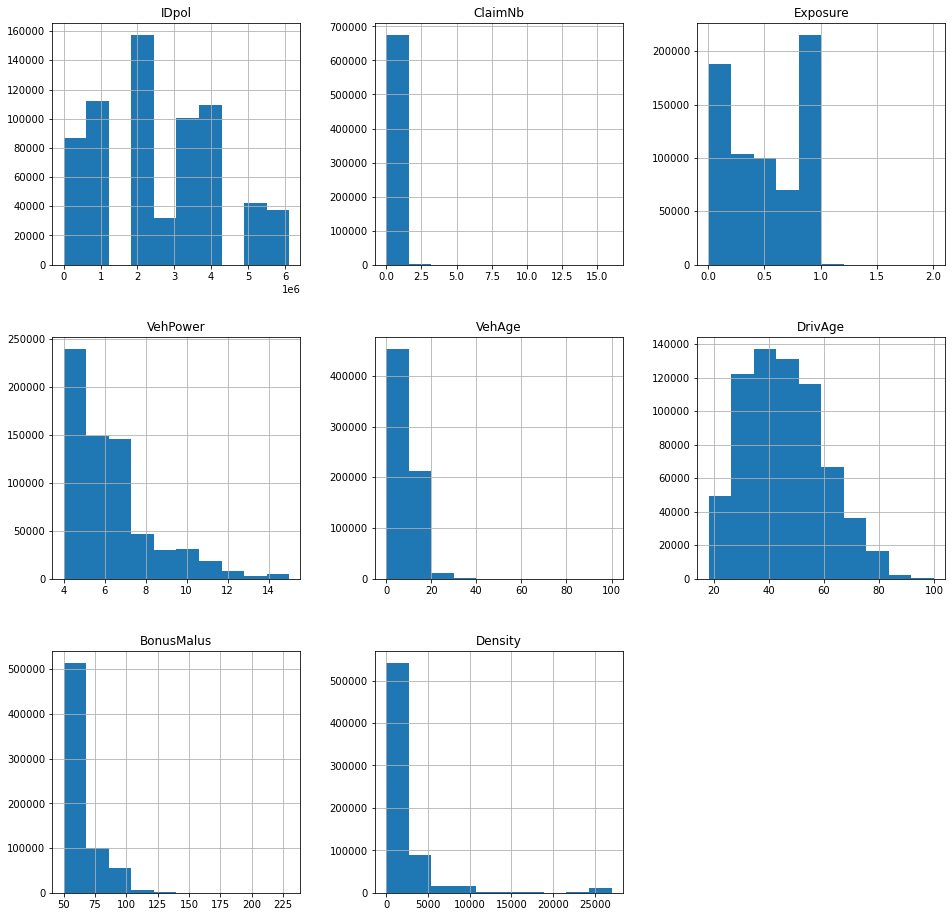

In [4]:
#Show the distribution of numerical features in the dataset
df.hist(figsize=(16,16))

## Data Visualisation of Categorical Features

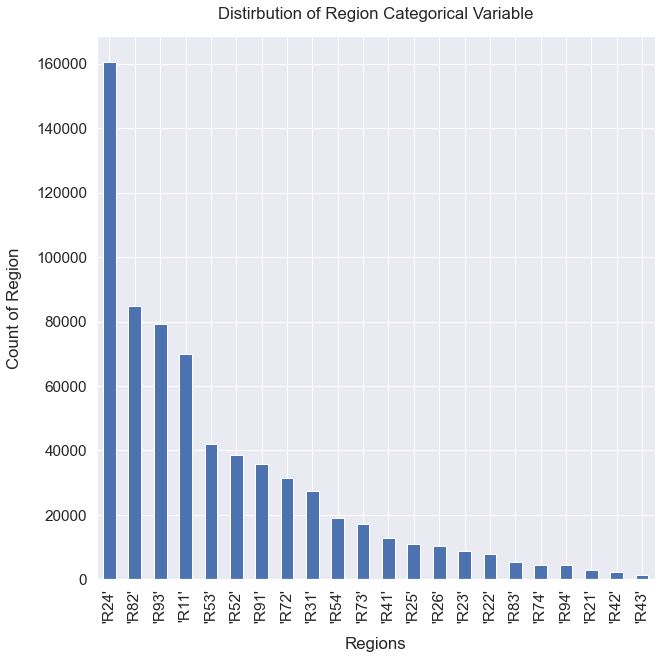

In [5]:
import seaborn as sns

#Show the distribution of Region feature in the dataset
sns.set(font_scale=1.4)
df['Region'].value_counts().plot(kind='bar', figsize=(10, 10))
plt.xlabel("Regions", labelpad=14)
plt.ylabel("Count of Region", labelpad=14)
plt.title("Distirbution of Region Categorical Variable", y=1.02);

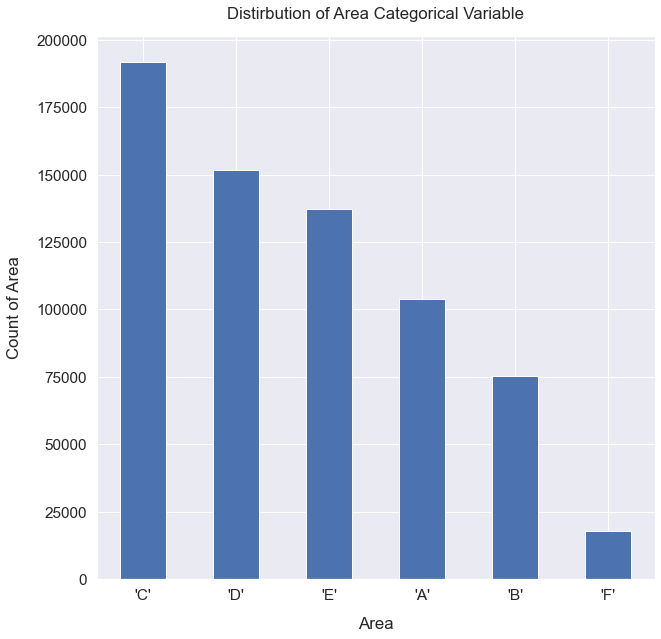

In [6]:
#Show the distribution of Area feature in the dataset
sns.set(font_scale=1.4)
df['Area'].value_counts().plot(kind='bar', figsize=(10, 10), rot = 0)
plt.xlabel("Area", labelpad=14)
plt.ylabel("Count of Area", labelpad=14)
plt.title("Distirbution of Area Categorical Variable", y=1.02);

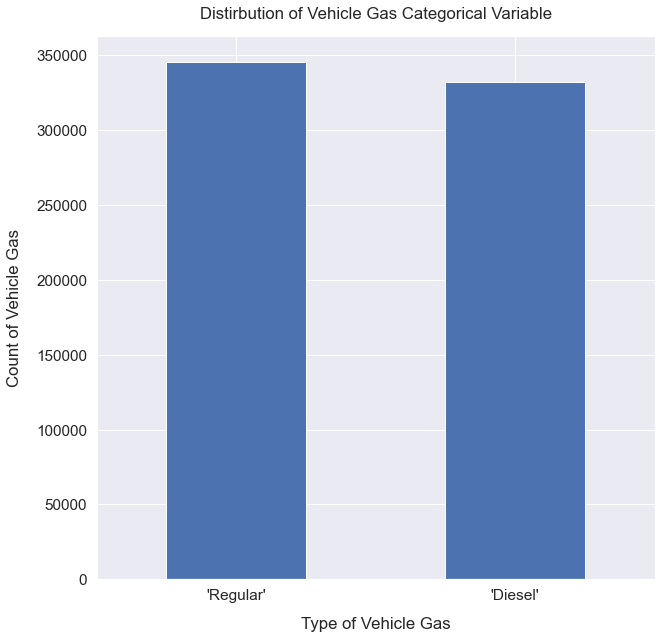

In [7]:
#Show the distribution of Vehicle Gas feature in the dataset
sns.set(font_scale=1.4)
df['VehGas'].value_counts().plot(kind='bar', figsize=(10, 10), rot = 0)
plt.xlabel("Type of Vehicle Gas", labelpad=14)
plt.ylabel("Count of Vehicle Gas", labelpad=14)
plt.title("Distirbution of Vehicle Gas Categorical Variable", y=1.02);

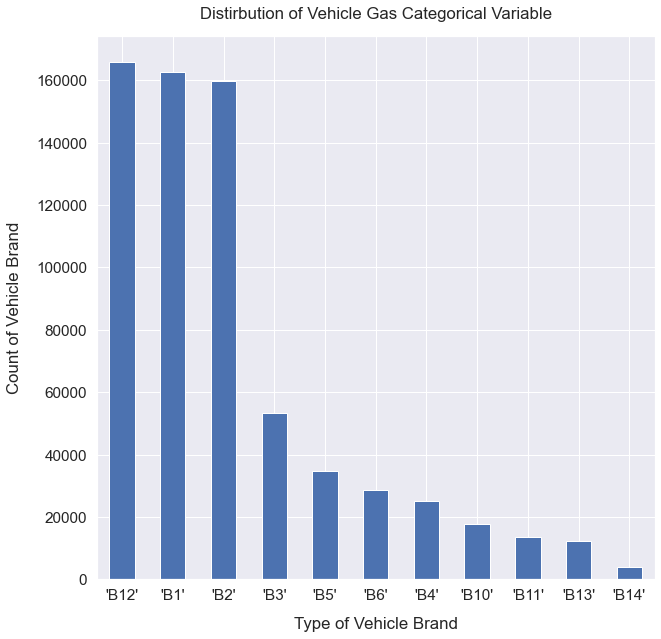

In [8]:
#Show the distribution of Vehicle Brand feature in the dataset
sns.set(font_scale=1.4)
df['VehBrand'].value_counts().plot(kind='bar', figsize=(10, 10), rot = 0)
plt.xlabel("Type of Vehicle Brand", labelpad=14)
plt.ylabel("Count of Vehicle Brand", labelpad=14)
plt.title("Distirbution of Vehicle Gas Categorical Variable", y=1.02);

## Remove IDpol Column

In [4]:
#we remove IDpol which is the unique policy ID as it is not used for prediction of number of insurance claims.
df = df.drop(columns=["IDpol"])
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10000,'D',5,0,55,50,'B12','Regular',1217,'R82'
1,1,0.77000,'D',5,0,55,50,'B12','Regular',1217,'R82'
2,1,0.75000,'B',6,2,52,50,'B12','Diesel',54,'R22'
3,1,0.09000,'B',7,0,46,50,'B12','Diesel',76,'R72'
4,1,0.84000,'B',7,0,46,50,'B12','Diesel',76,'R72'
...,...,...,...,...,...,...,...,...,...,...,...
678008,0,0.00274,'E',4,0,54,50,'B12','Regular',3317,'R93'
678009,0,0.00274,'E',4,0,41,95,'B12','Regular',9850,'R11'
678010,0,0.00274,'D',6,2,45,50,'B12','Diesel',1323,'R82'
678011,0,0.00274,'B',4,0,60,50,'B12','Regular',95,'R26'


## Exposure Distribution Visualisation

From the Distribution of Exposure, we can observe that exposure frequency are mostly clustered within the 0 to 1 range.


Text(0, 0.5, 'Frequency')

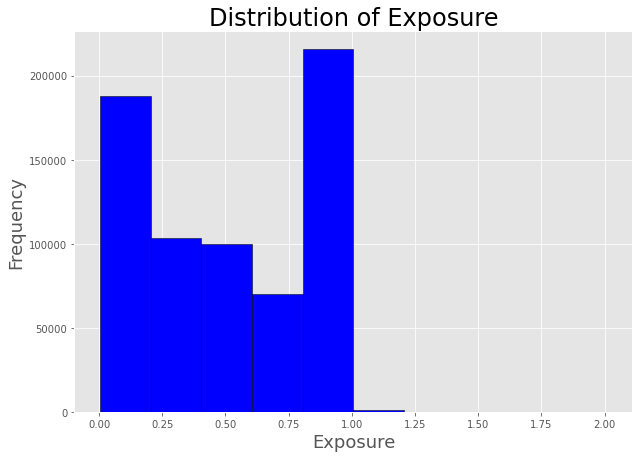

In [5]:
# Plot histogram of the Exposure

print("From the Distribution of Exposure, we can observe that exposure frequency are mostly clustered within the 0 to 1 range.")
plt.style.use('ggplot')
df.Exposure.plot(kind='hist', color='blue', edgecolor='black', figsize=(10,7)) #bins=4
plt.title('Distribution of Exposure', size=24)
plt.xlabel('Exposure', size=18)
plt.ylabel('Frequency', size=18)

In [6]:
# Show number of unique value counts for Exposure before cleaning
print("Number of unique value counts for Exposure before cleaning: ")
df.Exposure.value_counts()

Number of unique value counts for Exposure before cleaning: 


1.00    168125
0.08     44670
0.07     12969
0.24     12950
0.50     12497
         ...  
1.70         1
1.99         1
1.98         1
1.63         1
1.55         1
Name: Exposure, Length: 181, dtype: int64

#### Comments:
From the histogram plot of exposure, we observe that we have many exposures that are less than 1 year-at-risk, 1224 exposures are bigger than 1 year and the smallest exposure is 1 day. We correct for the exposures bigger than one year by replacing these outlier values by the upper limit of 1 year because this is most likely caused by data error since all observations are within one accounting year.

## Data Cleaning by replacing outliers for Exposure column

In [7]:
df_clean = df.copy()
df_clean['Exposure'] = df['Exposure'].clip(upper=1) #replace outliers above the exposure value of 1 with the value of 1

'''
#Clean dataset, we remove the number of exposure to a maximum of 1.
df_clean = df[df['Exposure'] <= 1]
df_clean = df_clean[df_clean['Exposure'] >= 0]
'''

print('Cleaned Dataset: ')
df_clean

Cleaned Dataset: 


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10000,'D',5,0,55,50,'B12','Regular',1217,'R82'
1,1,0.77000,'D',5,0,55,50,'B12','Regular',1217,'R82'
2,1,0.75000,'B',6,2,52,50,'B12','Diesel',54,'R22'
3,1,0.09000,'B',7,0,46,50,'B12','Diesel',76,'R72'
4,1,0.84000,'B',7,0,46,50,'B12','Diesel',76,'R72'
...,...,...,...,...,...,...,...,...,...,...,...
678008,0,0.00274,'E',4,0,54,50,'B12','Regular',3317,'R93'
678009,0,0.00274,'E',4,0,41,95,'B12','Regular',9850,'R11'
678010,0,0.00274,'D',6,2,45,50,'B12','Diesel',1323,'R82'
678011,0,0.00274,'B',4,0,60,50,'B12','Regular',95,'R26'


In [8]:
# Show number of unique value counts for Exposure after cleaning
print("Number of unique value counts for Exposure after cleaning: ")
df_clean.Exposure.value_counts()

Number of unique value counts for Exposure after cleaning: 


1.000000    169349
0.080000     44670
0.070000     12969
0.240000     12950
0.500000     12497
             ...  
0.005479      1396
0.008219      1147
0.002732      1060
0.008197       620
0.005464       609
Name: Exposure, Length: 106, dtype: int64

## ClaimNb Distribution Visualisation

From the Distribution of claims frequency histogram, we can observe that zero claims form a large part of our portfolio.


Text(0, 0.5, 'Frequency')

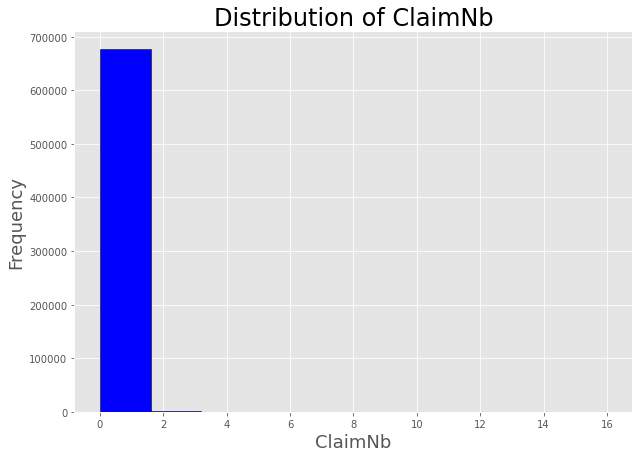

In [9]:
# Plot histogram of the ClaimNb
print("From the Distribution of claims frequency histogram, we can observe that zero claims form a large part of our portfolio.")

plt.style.use('ggplot')
df_clean.ClaimNb.plot(kind='hist', color='blue', edgecolor='black', figsize=(10,7))
plt.title('Distribution of ClaimNb', size=24)
plt.xlabel('ClaimNb', size=18)
plt.ylabel('Frequency', size=18)

In [10]:
# Show unique value counts for ClaimNb before cleaning
print("Frequency of each count of Insurance Claim before cleaning:: ")
df_clean.ClaimNb.value_counts()

Frequency of each count of Insurance Claim before cleaning:: 


0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
9          1
16         1
Name: ClaimNb, dtype: int64

#### Comments:
The histogram of ClaimNb shows that there are outliers when ClaimNb is more than 4. Thus, we limit ClaimNb data range to between 0 to 4.

For the number of claims (ClaimNb), we observe a total of 9 policies having more than 4 claims, while the maximal number of claims is 16. We will remove these big values as they are likely to be data errors.

## Data Cleaning by removing outliers of ClaimNb column

In [11]:
df_clean['ClaimNb'] = df_clean['ClaimNb'].clip(upper=4) #replace outliers above the Claim Number value of 4 with the value of 4

'''
#Clean dataset, we remove the number of claims to a maximum of 4.
df_clean = df_clean[df_clean['ClaimNb'] <= 4]
df_clean = df_clean[df_clean['ClaimNb'] >= 0]
'''
print('Cleaned Dataset: ')
df_clean

Cleaned Dataset: 


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10000,'D',5,0,55,50,'B12','Regular',1217,'R82'
1,1,0.77000,'D',5,0,55,50,'B12','Regular',1217,'R82'
2,1,0.75000,'B',6,2,52,50,'B12','Diesel',54,'R22'
3,1,0.09000,'B',7,0,46,50,'B12','Diesel',76,'R72'
4,1,0.84000,'B',7,0,46,50,'B12','Diesel',76,'R72'
...,...,...,...,...,...,...,...,...,...,...,...
678008,0,0.00274,'E',4,0,54,50,'B12','Regular',3317,'R93'
678009,0,0.00274,'E',4,0,41,95,'B12','Regular',9850,'R11'
678010,0,0.00274,'D',6,2,45,50,'B12','Diesel',1323,'R82'
678011,0,0.00274,'B',4,0,60,50,'B12','Regular',95,'R26'


In [12]:
# Show unique value counts for ClaimNb after cleaning
print("Frequency of each count of Insurance Claim after cleaning:: ")
df_clean.ClaimNb.value_counts()

Frequency of each count of Insurance Claim after cleaning:: 


0    643953
1     32178
2      1784
3        82
4        16
Name: ClaimNb, dtype: int64

## Detecting Missing or Unexpected Values from Dataframe

In [13]:
# Detecting numbers in categorical features

#Loop through catergorical columns to check for unexpected integer values

cnt=0

print("Finding Unexpected Integer data in Categorical Variables features: \n")

for row in df_clean['Area']:
    
    #Try and turn the entry into an integer
    try: 
        int(row)
        df_clean.loc[cnt, 'ClaimNb']==np.nan #If the value can be changed to an integer, we change the entry to a missing value 
    
    #If the number can’t be an integer, we know it’s a string, so keep going
    except ValueError:
        pass 
    cnt+=1

print('Number of unexpected (Integer) Values in categorical variable ClaimNb = ', len(df_clean['ClaimNb']) - cnt)

cnt=0
for row in df_clean['VehBrand']:
    try:
        int(row)
        df_clean.loc[cnt, 'VehBrand']==np.nan
    except ValueError:
        pass
    cnt+=1

print('Number of unexpected (Integer) Values in categorical variable VehBrand = ', len(df_clean['VehBrand']) - cnt)

cnt=0
for row in df_clean['VehBrand']:
    try:
        int(row)
        df_clean.loc[cnt, 'VehPower']==np.nan
    except ValueError:
        pass
    cnt+=1

print('Number of unexpected (Integer) Values in categorical variable VehPower = ', len(df_clean['VehPower']) - cnt)

cnt=0
for row in df_clean['VehGas']:
    try:
        int(row)
        df_clean.loc[cnt, 'VehGas']==np.nan
    except ValueError:
        pass
    cnt+=1

print('Number of unexpected (Integer) Values in categorical variable VehGas = ', len(df_clean['VehGas']) - cnt)

cnt=0
for row in df_clean['Region']:
    try:
        int(row)
        df_clean.loc[cnt, 'Region']==np.nan
    except ValueError:
        pass
    cnt+=1

print('Number of unexpected (Integer) Values in categorical variable Region = ', len(df_clean['Region']) - cnt)


# show the boolean dataframe            
print(" \nShow the boolean Dataframe : \n\n", df_clean.isnull())

# Breakdown of Total missing values (Null values) for each feature
# Count total NaN at each column in a DataFrame
print(" \nCount total missing values (NaN) at each column in cleaned dataFrame :")
df_clean.isnull().sum()

Finding Unexpected Integer data in Categorical Variables features: 

Number of unexpected (Integer) Values in categorical variable ClaimNb =  0
Number of unexpected (Integer) Values in categorical variable VehBrand =  0
Number of unexpected (Integer) Values in categorical variable VehPower =  0
Number of unexpected (Integer) Values in categorical variable VehGas =  0
Number of unexpected (Integer) Values in categorical variable Region =  0
 
Show the boolean Dataframe : 

         ClaimNb  Exposure   Area  VehPower  VehAge  DrivAge  BonusMalus  \
0         False     False  False     False   False    False       False   
1         False     False  False     False   False    False       False   
2         False     False  False     False   False    False       False   
3         False     False  False     False   False    False       False   
4         False     False  False     False   False    False       False   
...         ...       ...    ...       ...     ...      ...         ... 

ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

## Automatic Outliers Detection for Dataframe

In [14]:
# Automatic Outliers Detection

#https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html

import time
st0 = time.time()
stm = st0

import pandas as pd
import numpy as np

d = df_clean

cn = list(d)
#change any non-numeric y value to NaN

#delete any row where all x-variables are missing
d = d[cn].dropna(how='all')

#delete any column of constant values:
d = d[d.columns[d.nunique() > 1]]

#delete any non-numeric column and any column with any missing value:
for i in list(d):
    if pd.to_numeric(d[i], errors='coerce').isnull().any():
        del d[i]

# #random subsetting of rows: #only for demo purposes
# d = d.sample(10000)

r = len(d)

import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print('Preparing data of', r, 'rows &', d.shape[1], 'columns took',
      '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#Isolation Forest

#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
from sklearn.ensemble import IsolationForest
#-1 in 'g' identifies an outlier position:
#g = IsolationForest().fit(d).fit_predict(d).tolist() #.fit(d) not necessary
g = IsolationForest(n_jobs=-1).fit_predict(d).tolist()
print('\nNumber of IsolationForest outliers:', g.count(-1))
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#Local Outlier Factor

#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
from sklearn.neighbors import LocalOutlierFactor
a0 = LocalOutlierFactor(n_jobs=-1)
#-1 in 'a' identifies an outlier position:
a = a0.fit_predict(d).tolist()
ac = a.count(-1) #keep for EllipticEnvelope
an = a0.negative_outlier_factor_ #use this size info to rank outliers later
print('\nNumber of LocalOutlierFactor outliers:', ac)
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#Elliptic Envelope for Gaussian distribution

#https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html
from sklearn.covariance import EllipticEnvelope
#-1 in 'e' identifies an outlier position:
e = EllipticEnvelope(contamination=min(0.1,ac/r)).fit_predict(d).tolist()
print('\nNumber of EllipticEnvelope outliers:', e.count(-1))
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

# #One-Class Support Vector Machine (can take a very long time!)

# #https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html
# from sklearn.svm import OneClassSVM
# #-1 in 'b' identifies an outlier position:
# # b = OneClassSVM().fit(d).fit_predict(d).tolist()
# b = OneClassSVM(nu=.01, gamma=0.00005).fit_predict(d).tolist()
# print('\nNumber of OneClassSVM outliers:', b.count(-1))
# print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')

#find shared outliers

# f = [-1 if s==-1 and t==-1 and u==-1 and v==-1 else 1 for s, t, u, v in zip(a, b, c, e)]
f = [-1 if s==-1 and t==-1 and u==-1 else 1 for s, t, u in zip(a, g, e)]
p = f.count(-1)

if p > 0:
    common = [i for i, z in enumerate(f) if z == -1] #indices of outliers common to all lists
    q = [z for _, z in sorted(zip(an[common], common))][:100] #indices of sorted worst outliers
    print('\nNumber of outliers common to all lists:', p,
          '\nIndices of up to 100 sorted outliers with the worst first:', q,
          'from [0 to', str(r - 1) + '].')
    print('\nProportion of data outlying:', '%.5f' % (p / r))
else:
    print('\nNo outlier common to all lists.')
print('\nOutliers detection took', '%.2f' % ((time.time() - st0) / 60), 'mins.')

Preparing data of 678013 rows & 7 columns took 0.11 mins.

Number of IsolationForest outliers: 119042
... took 0.92 mins.

Number of LocalOutlierFactor outliers: 13055
... took 2.36 mins.

Number of EllipticEnvelope outliers: 13055
... took 1.88 mins.

Number of outliers common to all lists: 516 
Indices of up to 100 sorted outliers with the worst first: [656061, 656062, 513763, 619849, 619850, 513764, 66501, 131057, 43222, 43221, 552767, 424279, 82808, 131097, 244133, 378644, 15667, 518255, 518256, 277776, 436968, 562418, 208444, 208446, 364706, 15433, 225383, 107605, 18711, 559744, 433561, 524038, 268727, 153231, 34561, 123026, 74904, 169047, 477481, 483905, 308692, 308419, 303679, 384611, 17577, 17578, 563287, 23516, 437845, 219315, 278242, 100062, 593394, 44155, 366259, 506082, 611894, 210390, 601981, 147190, 6654, 145866, 258000, 414009, 17187, 26530, 17983, 389849, 131582, 226234, 513820, 34560, 557731, 654778, 430872, 618153, 273998, 437867, 153225, 124746, 278264, 125038, 25942

In [15]:
#drop outliers detected by automatic outlier code
df_clean = df_clean.drop(common) #where common contains the list of indexes for outliers common to all lists
df_clean

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,0.10000,'D',5,0,55,50,'B12','Regular',1217,'R82'
1,1,0.77000,'D',5,0,55,50,'B12','Regular',1217,'R82'
2,1,0.75000,'B',6,2,52,50,'B12','Diesel',54,'R22'
3,1,0.09000,'B',7,0,46,50,'B12','Diesel',76,'R72'
4,1,0.84000,'B',7,0,46,50,'B12','Diesel',76,'R72'
...,...,...,...,...,...,...,...,...,...,...,...
678008,0,0.00274,'E',4,0,54,50,'B12','Regular',3317,'R93'
678009,0,0.00274,'E',4,0,41,95,'B12','Regular',9850,'R11'
678010,0,0.00274,'D',6,2,45,50,'B12','Diesel',1323,'R82'
678011,0,0.00274,'B',4,0,60,50,'B12','Regular',95,'R26'


In [16]:
# Display summary statistics of raw dataframe
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [17]:
# Display summary statistics of cleaned dataframe
df_clean.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,677497.000000,677497.000000,677497.000000,677497.000000,677497.000000,677497.000000,677497.000000
mean,0.053059,0.528581,6.454092,7.043185,45.499090,59.724713,1781.942751
std,0.237539,0.364102,2.050005,5.660582,14.133949,15.531379,3930.726278
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,392.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1629.000000
max,4.000000,1.000000,15.000000,100.000000,100.000000,190.000000,27000.000000


## Convert Category Data to Categorical Variable

In [18]:
# Convert Category Columns to categorical variables


df_clean_pre = df_clean.copy() #copy dataframe for use later

# Convert Category Columns to categorical variables for preprocessing. Note that preprocessing code read string type column headers as categorical data.
df_clean_pre["Area"] = df_clean_pre["Area"].astype("string")
df_clean_pre["VehPower"] = df_clean_pre["VehPower"].astype("string")
df_clean_pre["VehBrand"] = df_clean_pre["VehBrand"].astype("string")
df_clean_pre["VehGas"] = df_clean_pre["VehGas"].astype("string")
df_clean_pre["Region"] = df_clean_pre["Region"].astype("string")

df_clean_pre


# Use get dummies to assign categorial variable without preprocessing
df_clean = pd.get_dummies(df_clean,columns = ['Area'], prefix='Area', drop_first = True)
df_clean = pd.get_dummies(df_clean,columns = ['VehPower'], prefix='VehPower', drop_first = True)
df_clean = pd.get_dummies(df_clean,columns = ['VehBrand'], prefix='VehBrand', drop_first = True)
df_clean= pd.get_dummies(df_clean,columns = ['VehGas'], prefix='VehGas', drop_first = True)
df_clean = pd.get_dummies(df_clean,columns = ['Region'], prefix='Region', drop_first = True)


#Show dataframe
print("df_clean dataframe:")
df_clean

df_clean dataframe:


,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,Area_'B',Area_'C',Area_'D',Area_'E',...,Region_'R53',Region_'R54',Region_'R72',Region_'R73',Region_'R74',Region_'R82',Region_'R83',Region_'R91',Region_'R93',Region_'R94'
0,1,0.10000,0,55,50,1217,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0.77000,0,55,50,1217,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0.75000,2,52,50,54,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.09000,0,46,50,76,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0.84000,0,46,50,76,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0,0.00274,0,54,50,3317,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
678009,0,0.00274,0,41,95,9850,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
678010,0,0.00274,2,45,50,1323,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
678011,0,0.00274,0,60,50,95,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#Pre-Process df_clean
df_clean_pre = preprocess(df_clean_pre,'ClaimNb')

#Show dataframe
print("df_clean_pre dataframe:")
df_clean_pre

Preparing data may take time...
'ClaimNb' is the Y-variable.

Original data has 677,497 rows and 11 columns.

First 3 rows:
   ClaimNb  Exposure Area VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0        1      0.10  'D'        5       0       55          50    'B12'   
1        1      0.77  'D'        5       0       55          50    'B12'   
2        1      0.75  'B'        6       2       52          50    'B12'   

      VehGas  Density Region  
0  'Regular'     1217  'R82'  
1  'Regular'     1217  'R82'  
2   'Diesel'       54  'R22'   

Results are unrepeatable because of desirable randomness introduced.

Possibly subsetting data may take time (might hang & require a restart)...

Specified size parameters: mxx (maxed out) = False ;  s (rows) = 20000 ;  mc (# Xs) = 50 ;  mn (minutes per model) = 2

(To restart in a browser, click on the space to the left of the line numbers if necessary; when the left border is blue, type: 00, wait for a prompt to appear, then click on Resta

,ClaimNb,BonusMalus_125¯&¯148¯&¯61¯&¯63¯&...,DrivAge_28¯&¯22,VehAge,VehPower_15,Region_'R25',BonusMalus,Exposure,Density,DrivAge
16046,0.0,0,0,1.0,1,0,50.0,0.98,384,41.0
289753,0.0,0,0,3.0,0,0,54.0,1.00,3317,32.0
207790,0.0,0,0,4.0,0,0,95.0,0.54,46,38.0
279188,0.0,0,0,7.0,0,0,62.0,0.02,83,38.0
175076,1.0,0,0,10.0,0,0,50.0,1.00,186,65.0
...,...,...,...,...,...,...,...,...,...,...
439081,0.0,0,0,12.0,0,0,50.0,0.08,144,59.0
541826,0.0,0,1,9.0,0,0,68.0,0.84,233,28.0
615507,0.0,0,0,2.0,0,0,85.0,0.76,27000,31.0
387669,0.0,0,0,7.0,0,0,80.0,0.24,100,25.0


## Try Logistic Regression

In [25]:
# Logistic Regression Feature Selection (much simpler than Variable_Selection.ipynb)

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  #suppress warning messages (those with peach background)
import statsmodels.api as sm
from statsmodels.formula.api import logit

def mr(selection=False):

    h = df_clean.copy()
    print('\nThe dataset has', len(h), 'rows and', h.shape[1], 'columns.', '' if selection else '\n')

    yvar = 'ClaimNb'
    
    if len(set(h[yvar].dropna())) != 2:
        print('Y is not dichotomous!')
        return
    
    cn = list(h) # dataset's variable names
    for xvar in cn:
        h.rename(columns={xvar: xvar.replace('.', '_')}, inplace=True) #model variable cannot have name containing '.'
    cn = list(h) # dataset's variable names
    
    modeleq = yvar + ' ~'
    #specify C() for Categorical, else could be interpreted as numeric:
    for xvar in (  # insert new 'x variable' into a row, ending with ','
            'IDpol',
        'Exposure',
        'Area',
        'VehPower',
        'VehAge',
        'DrivAge',
        'BonusMalus',
        'VehBrand',
        'VehGas',
        'Density',
        'Region'
            ):
        
        if (xvar in cn) and (xvar != yvar):
            if modeleq[-1] == '~':
                modeleq = modeleq + ' ' + xvar
            else:
                modeleq = modeleq + ' + ' + xvar
        else:
            print('Missing', xvar ,'will be ignored.')
            
    if modeleq[-1] == '~':
        #no X variable added into model; import directly from dataset:
        for xvar in cn:
            if xvar != yvar:
                if modeleq[-1] == '~':
                    modeleq = modeleq + ' ' + xvar
                else:
                    modeleq = modeleq + ' + ' + xvar
                
    bmodeleq = modeleq
    
    if selection:
        #eliminate X variables one by one:
        print('\nVariable Selection using p-value & LLR p-value:')
        minfpv = 1.0
        
        #machine learns:
        while True:
            hout = logit(modeleq, h).fit(disp=0, maxiter=100) #no output displayed

            fpv = hout.llr_pvalue
            if fpv < minfpv :
                minfpv=fpv
                bmodeleq=modeleq
                
            numx = modeleq.count(' + ')
            print('\nLog-Likelihood Ratio =', hout.llr, '       LLR p-value =', fpv, 'for', numx + 1, 'Xs.')
            
            if modeleq.find(' + ') == -1:
                #one xvar left
                break
                
            #identify X variable to delete
            prf = hout.pvalues
            #print(prf)
            maxp = max(prf[1:])
            xdrop = prf[1:][maxp==prf[1:]].axes[0][0] # 1st element of row-label .axes[0]

            # xdrop removed from model equation:
            if (modeleq.find('~ ' + xdrop + ' + ') != -1):
                modeleq = modeleq.replace('~ ' + xdrop + ' + ', '~ ')
            elif (modeleq.find('+ ' + xdrop + ' + ') != -1):
                modeleq = modeleq.replace('+ ' + xdrop + ' + ', '+ ')
            else:
                modeleq = modeleq.replace(' + ' + xdrop, '')
            #print('Model equation:',modeleq,'\n')

            print('Variable to drop:', xdrop, '       p-value =', prf[xdrop])

        #machine learnt

        print('Variable left:', str(list(prf[maxp != prf][1:].index)[0]))
        print('\nBest model equation:', bmodeleq)
        print('Minimum LLR p-value =', minfpv, 'for', bmodeleq.count(' + ') + 1, 'Xs.\n')

    hout = logit(bmodeleq, h).fit(disp=0, maxiter=100)
    hsum = hout.summary2()
    
    #print regression output:
    print(hsum)

    last=int(hout.df_model) #number of bottom z-stats to display with more precision
    print(last, "X-coefficients' z-stats ranked:")
    nxvar = len(hout.tvalues)
    print(pd.concat([hout.tvalues[nxvar-last:nxvar], abs(hout.tvalues[nxvar-last:nxvar])],
              axis=1).sort_values(1, ascending=False)[0])
    
a = input('1: Do Logistic Regression Once, 2: Variable Selection (default: 2)? ').strip()
if a == '1':
    mr() # do logistic regression once
else:
    mr(True) # do Variable Selection

1: Do Logistic Regression Once, 2: Variable Selection (default: 2)? 1

The dataset has 677377 rows and 54 columns. 

Y is not dichotomous!


#### Comments
Logistic regression is the appropriate regression analysis to conduct only when the dependent variable Y is dichotomous (binary). We do not use Logistic Regression for our model prediction of dependent variable ClaimNb which is a random variable that takes on non-negative integers. This is because ClaimNb is not dichotomous or non-binary.

However, if we are just concerned about the number of zero and non-zero claims (binary), then we may use logistic regression for our prediction.

## Using Generalized Linear Models (GLM)

Regression analysis and its extensions such as Generalized Linear Model (GLM) are strong tools in predicting number of insurance claims. Unlike regression models, GLM is not constrained to a normal distribution and can be applied to any distribution from an exponential family. Interestingly, GLM has been used in actuarial practice to model claims amounts and claims frequency in the insurance industry.

Thought Process for choosing General Linear Model to predict ClaimNb:
- We choose General Linear Model (GLM) candidates by comparing Y’s distribution to candidate distributions’ graphs in Wikipedia.
- Compare common fit statistics of the final model for each candidate from the GLM family, using the same estimation process e.g., same variable selection procedure
- Decide which model is easiest to report

## Run all GLM Models using Pre-processed data method

counter =  1
GLM Model Fitted =  Normal
1 entered.

Assuming Normal error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
DrivAge , DrivAge_sqrt
VehPower_15 , VehPower_15_sqar
Region__R25__sqrt , Region__R25__sqar
Region__R25__sqar , Region__R25_
DrivAge_28___22_sqrt , DrivAge_28___22
DrivAge_28___22 , DrivAge_28___22_sqar
BonusMalus_sqrt , BonusMalus
BonusMalus_125___148___61___63______sqar , BonusMalus_125___148___61___63______sqrt
BonusMalus_125___148___61___63______sqrt , BonusMalus_125___148___61___63_____

9 variables considered for deletion:
DrivAge_sqrt
VehPower_15_sqar
Region__R25__sqrt
Region__R25__sqar
DrivAge_28___22_sqrt
DrivAge_28___22_sqar
BonusMalus_sqrt
BonusMalus_125___148___61___63______sqar
BonusMalus_125___148___61___63______sqrt

X pairs with correlations > 0.995 :
VehPower_15 , VehPower_15_sqrt

1 variables considered for deletion:
VehPower_15_sqrt

X pairs with correlations > 0.995 :
(no more)

10 transformed var


Adjusted R² = 0.0495190847274114 , max(X p-value) = 0.00966916344678343 , rank deficiency = 0 , for 8 Xs.
Variable to drop: BonusMalus_125___148___61___63______x_BonusMalus

Adjusted R² = 0.04767010449639386 , max(X p-value) = 0.015615519077589167 , rank deficiency = 0 , for 7 Xs.
Variable to drop: DrivAge

Adjusted R² = 0.04609452625346844 , max(X p-value) = 0.0010481805968042374 , rank deficiency = 0 , for 6 Xs.
Variable to drop: BonusMalus_x_DrivAge

Adjusted R² = 0.04292069658334219 , max(X p-value) = 0.00016765021854687126 , rank deficiency = 0 , for 5 Xs.
Variable to drop: BonusMalus_x_Region__R25_

Adjusted R² = 0.038616451995692636 , max(X p-value) = 5.032345458446075e-05 , rank deficiency = 0 , for 4 Xs.
Variable to drop: Exposure_sqar

Adjusted R² = 0.033546002849293766 , max(X p-value) = 0.0005084926883938043 , rank deficiency = 0 , for 3 Xs.
Variable to drop: VehAge_sqrt

Adjusted R² = 0.029889723693393377 , max(X p-value) = 2.1866912044612763e-05 , rank deficiency = 0 , f

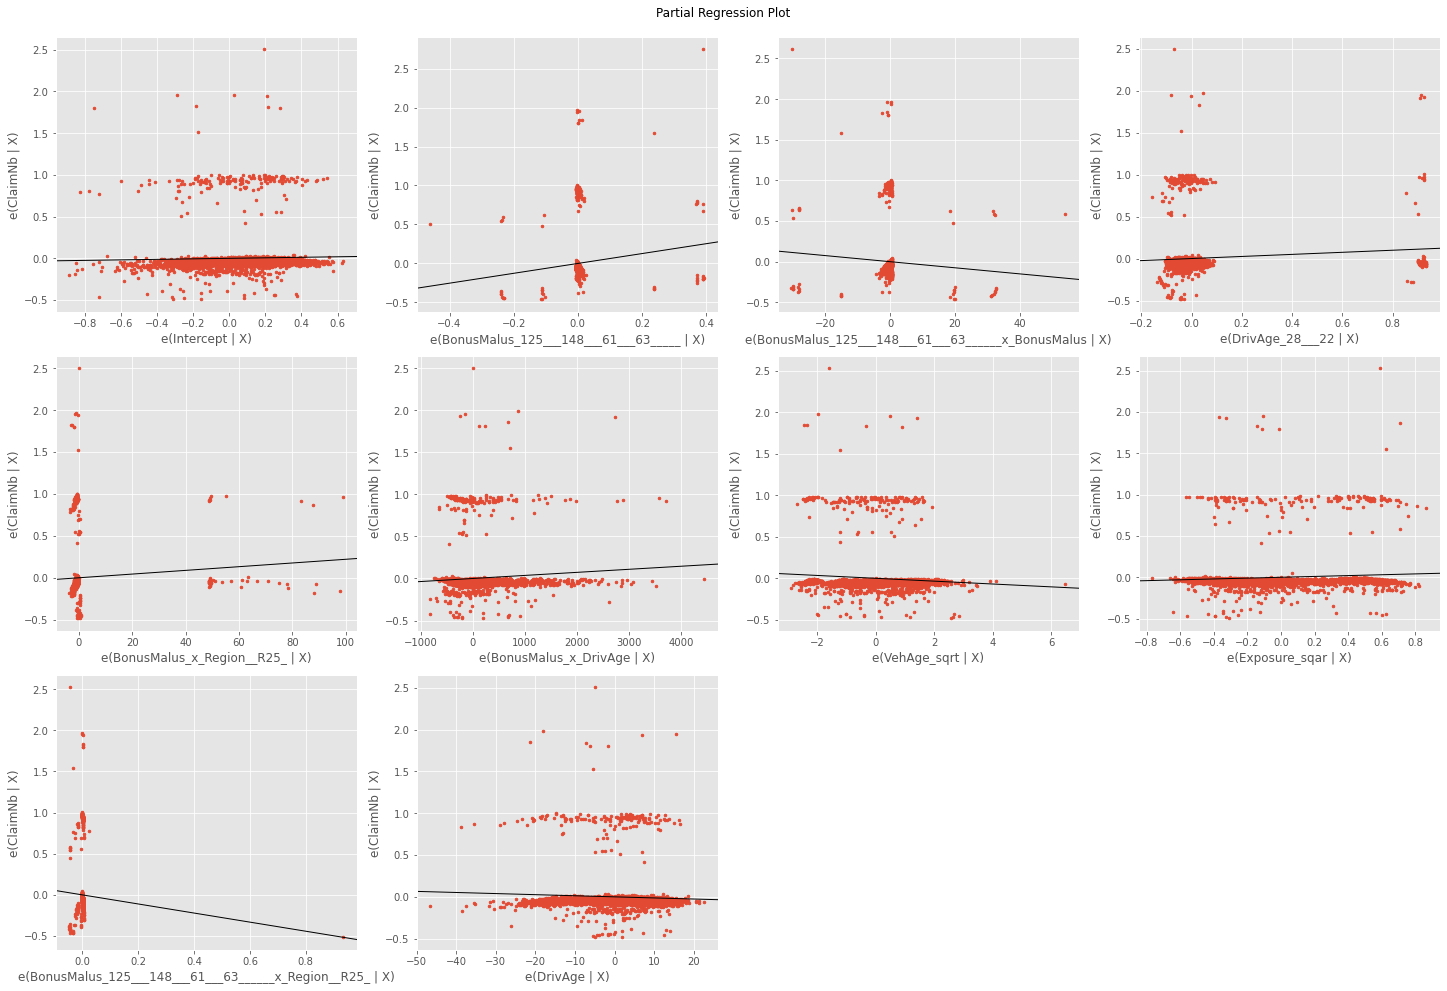


Normal fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.10591154782255195
Root Mean Squared Residual = 0.24332479205419616
                        R² = 0.05365395044206161

Normal prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.1098425544995728
Root Mean Squared Error = 0.2501623197477497
                     R² = 0.015544100543820322

Plots of train-set fit & test-set predict:


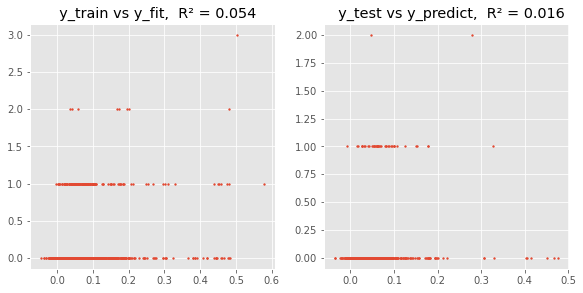

counter =  2
GLM Model Fitted =  Poisson
1 entered.

Assuming Poisson error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
DrivAge , DrivAge_sqrt
VehPower_15 , VehPower_15_sqar
Region__R25__sqrt , Region__R25__sqar
Region__R25__sqar , Region__R25_
DrivAge_28___22_sqrt , DrivAge_28___22
DrivAge_28___22 , DrivAge_28___22_sqar
BonusMalus_sqrt , BonusMalus
BonusMalus_125___148___61___63______sqar , BonusMalus_125___148___61___63______sqrt
BonusMalus_125___148___61___63______sqrt , BonusMalus_125___148___61___63_____

9 variables considered for deletion:
DrivAge_sqrt
VehPower_15_sqar
Region__R25__sqrt
Region__R25__sqar
DrivAge_28___22_sqrt
DrivAge_28___22_sqar
BonusMalus_sqrt
BonusMalus_125___148___61___63______sqar
BonusMalus_125___148___61___63______sqrt

X pairs with correlations > 0.995 :
VehPower_15 , VehPower_15_sqrt

1 variables considered for deletion:
VehPower_15_sqrt

X pairs with correlations > 0.995 :
(no more)

10 transformed v


Adjusted R² = 0.08704196346104487 , max(X p-value) = 0.38869931809784675 , rank deficiency = 3 , for 16 Xs.
Variable to drop: BonusMalus_x_VehAge

Adjusted R² = 0.08660478830796103 , max(X p-value) = 0.31289459080018567 , rank deficiency = 3 , for 15 Xs.
Variable to drop: Region__R25__x_VehAge

Adjusted R² = 0.08437021880437434 , max(X p-value) = 0.144790966347517 , rank deficiency = 3 , for 14 Xs.
Variable to drop: BonusMalus_125___148___61___63______x_VehPower_15

Adjusted R² = 0.08437021880437345 , max(X p-value) = 0.02645068636420838 , rank deficiency = 2 , for 13 Xs.
Variable to drop: VehAge_sqar

Adjusted R² = 0.08381009519203653 , max(X p-value) = 0.3340513477938294 , rank deficiency = 2 , for 12 Xs.
Variable to drop: VehAge

Adjusted R² = 0.08297088132276331 , max(X p-value) = 0.024895273348075335 , rank deficiency = 2 , for 11 Xs.
Variable to drop: BonusMalus_125___148___61___63______x_BonusMalus

Adjusted R² = 0.06723600147293507 , max(X p-value) = 0.0018471620306580526 , ra

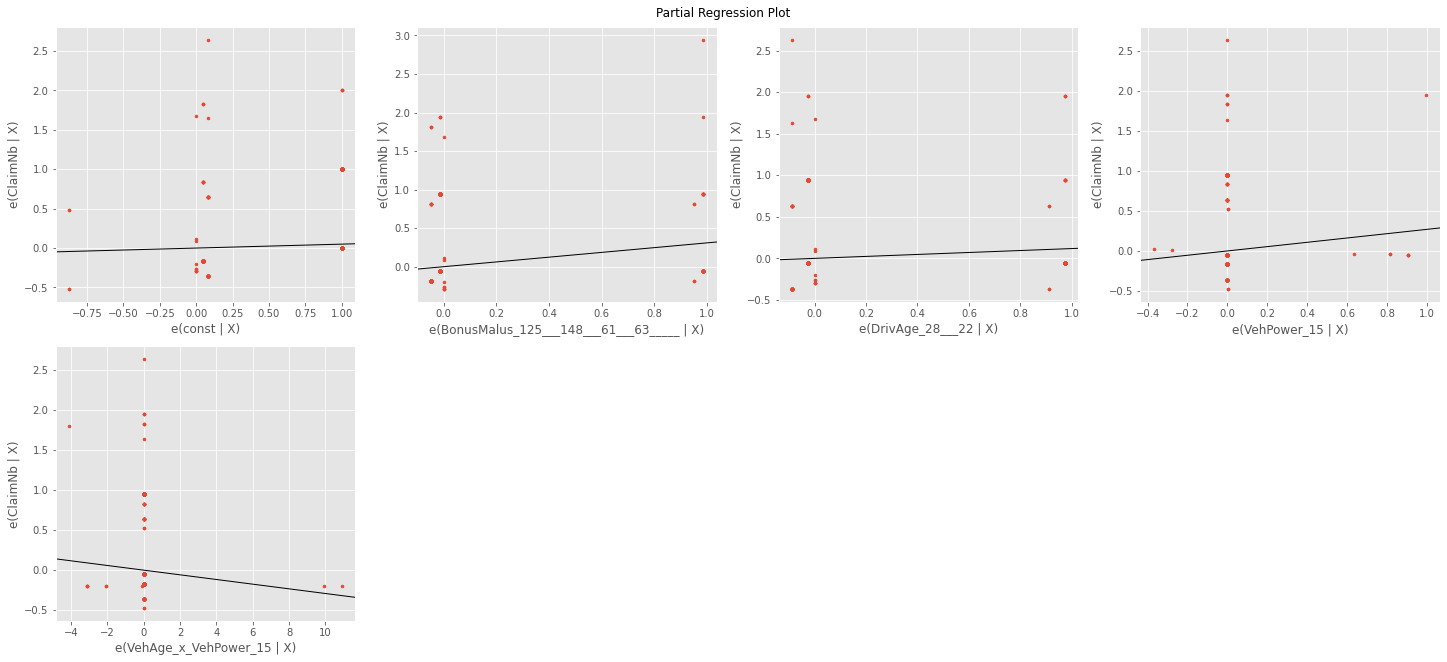


Poisson fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.10615421202137042
Root Mean Squared Residual = 0.24417379257489588
                        R² = 0.04732115165395088

Poisson prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.10994011600827797
Root Mean Squared Error = 0.24989153660552388
                     R² = 0.028105664521527976

Plots of train-set fit & test-set predict:


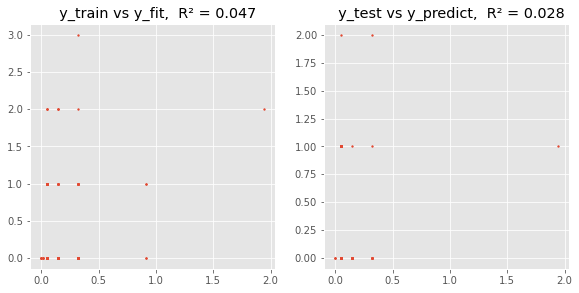

counter =  3
GLM Model Fitted =  Logit
1 entered.

Assuming Logit error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
DrivAge , DrivAge_sqrt
VehPower_15 , VehPower_15_sqar
Region__R25__sqrt , Region__R25__sqar
Region__R25__sqar , Region__R25_
DrivAge_28___22_sqrt , DrivAge_28___22
DrivAge_28___22 , DrivAge_28___22_sqar
BonusMalus_sqrt , BonusMalus
BonusMalus_125___148___61___63______sqar , BonusMalus_125___148___61___63______sqrt
BonusMalus_125___148___61___63______sqrt , BonusMalus_125___148___61___63_____

9 variables considered for deletion:
DrivAge_sqrt
VehPower_15_sqar
Region__R25__sqrt
Region__R25__sqar
DrivAge_28___22_sqrt
DrivAge_28___22_sqar
BonusMalus_sqrt
BonusMalus_125___148___61___63______sqar
BonusMalus_125___148___61___63______sqrt

X pairs with correlations > 0.995 :
VehPower_15 , VehPower_15_sqrt

1 variables considered for deletion:
VehPower_15_sqrt

X pairs with correlations > 0.995 :
(no more)

10 transformed varia


Adjusted R² = -inf , max(X p-value) = 0.9987405754704229 , rank deficiency = 3 , for 45 Xs.
Variable to drop: Region__R25_

Adjusted R² = -inf , max(X p-value) = 1.0 , rank deficiency = 3 , for 44 Xs.
Variable to drop: Region__R25__x_Density

Adjusted R² = -inf , max(X p-value) = 0.999726844509564 , rank deficiency = 3 , for 43 Xs.
Variable to drop: DrivAge_28___22_x_Exposure

Adjusted R² = -inf , max(X p-value) = 1.0 , rank deficiency = 3 , for 42 Xs.
Variable to drop: VehAge_sqrt

Adjusted R² = -inf , max(X p-value) = 0.9998050282849785 , rank deficiency = 3 , for 41 Xs.
Variable to drop: DrivAge_28___22_x_DrivAge

Adjusted R² = -inf , max(X p-value) = 0.9997442956892038 , rank deficiency = 3 , for 40 Xs.
Variable to drop: Region__R25__x_Exposure

Adjusted R² = -inf , max(X p-value) = 0.9993239266435848 , rank deficiency = 3 , for 39 Xs.
Variable to drop: BonusMalus_125___148___61___63_____

Adjusted R² = -inf , max(X p-value) = 0.9981321665837146 , rank deficiency = 3 , for 38 Xs.



Adjusted R² = -inf , max(X p-value) = 1.0 , rank deficiency = 0 , for 15 Xs.
Variable to drop: BonusMalus_125___148___61___63_____

Adjusted R² = -inf , max(X p-value) = 0.9995647365391159 , rank deficiency = 0 , for 14 Xs.
Variable to drop: BonusMalus

Adjusted R² = -inf , max(X p-value) = 0.9996021188813936 , rank deficiency = 0 , for 13 Xs.
Variable to drop: Exposure_sqar

Adjusted R² = -inf , max(X p-value) = 0.9992696470100835 , rank deficiency = 0 , for 12 Xs.
Variable to drop: VehAge_sqar

Adjusted R² = -inf , max(X p-value) = 0.9999547942818452 , rank deficiency = 0 , for 11 Xs.
Variable to drop: VehAge_sqrt

Adjusted R² = -inf , max(X p-value) = 0.9999271381797076 , rank deficiency = 0 , for 10 Xs.
Variable to drop: Exposure_sqrt

Adjusted R² = -inf , max(X p-value) = 0.9989889685083561 , rank deficiency = 0 , for 9 Xs.
Variable to drop: Exposure

Adjusted R² = -inf , max(X p-value) = 0.9962161211093116 , rank deficiency = 0 , for 8 Xs.
Variable to drop: DrivAge

Adjusted R² 


Adjusted R² = -inf , max(X p-value) = 0.6629867704850803 , rank deficiency = 3 , for 13 Xs.
Variable to drop: Density_x_DrivAge

Adjusted R² = -inf , max(X p-value) = 0.5029305876448569 , rank deficiency = 3 , for 12 Xs.
Variable to drop: Density

Adjusted R² = -inf , max(X p-value) = 0.69472760229301 , rank deficiency = 3 , for 11 Xs.
Variable to drop: BonusMalus_x_VehAge

Adjusted R² = -inf , max(X p-value) = 0.9198088892654631 , rank deficiency = 3 , for 10 Xs.
Variable to drop: BonusMalus_x_DrivAge

Adjusted R² = -inf , max(X p-value) = 0.5189983287026885 , rank deficiency = 3 , for 9 Xs.
Variable to drop: BonusMalus_sqar

Adjusted R² = -inf , max(X p-value) = 0.09197761136955908 , rank deficiency = 3 , for 8 Xs.
Variable to drop: VehAge_x_Density

Adjusted R² = -inf , max(X p-value) = 2.302444177175913e-05 , rank deficiency = 3 , for 7 Xs.
Variable to drop: Density_sqar

Adjusted R² = -inf , max(X p-value) = 2.831782588926084e-05 , rank deficiency = 3 , for 6 Xs.
Variable to drop


Best model has 3 Xs (Adjusted R² = 0.0124202150137116 , rank deficiency = 0):

                Results: Generalized linear model
Model:                GLM              AIC:            -inf       
Link Function:        inverse_power    BIC:            176071.0192
Dependent Variable:   ClaimNb          Log-Likelihood: inf        
Date:                 2021-03-31 23:46 LL-Null:        inf        
No. Observations:     2940             Deviance:       1.9952e+05 
Df Model:             3                Pearson chi2:   6.46e+04   
Df Residuals:         2936             Scale:          22.010     
Method:               IRLS                                        
------------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------
const            43.3648   4.2958 10.0947 0.0000  34.9452  51.7843
BonusMalus       -0.2620   0.0340 -7.7095 0.0000  -0.3286  -0.1954

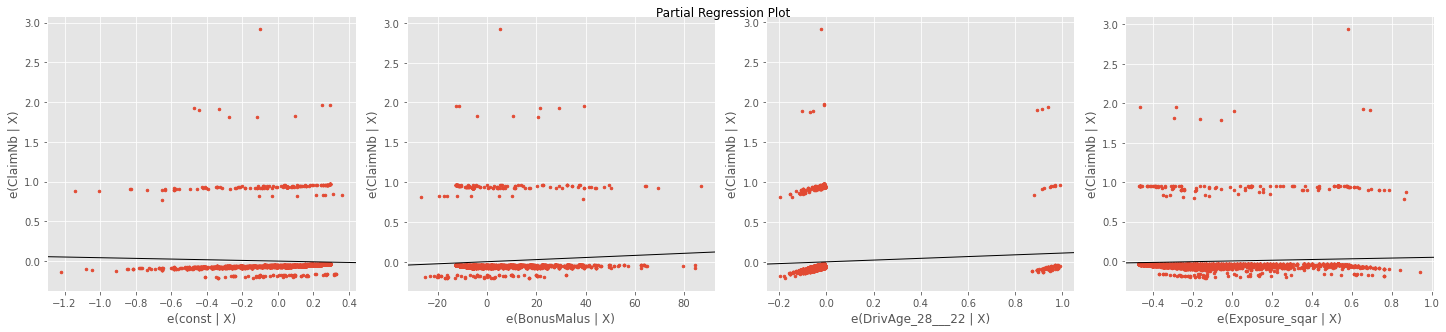


Gamma fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.11490033311731027
Root Mean Squared Residual = 0.2773936956206385
                        R² = 0.013428292371642527

Gamma prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.136447430522728
Root Mean Squared Error = 0.520242385848617
                     R² = 0.00034258361635954265

Plots of train-set fit & test-set predict:


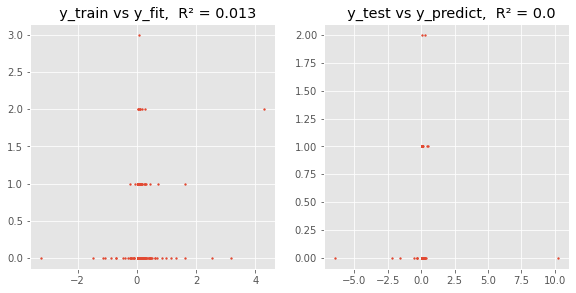

counter =  6
GLM Model Fitted =  InverseGaussian
1 entered.

Assuming InverseGaussian error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
DrivAge , DrivAge_sqrt
VehPower_15 , VehPower_15_sqar
Region__R25__sqrt , Region__R25__sqar
Region__R25__sqar , Region__R25_
DrivAge_28___22_sqrt , DrivAge_28___22
DrivAge_28___22 , DrivAge_28___22_sqar
BonusMalus_sqrt , BonusMalus
BonusMalus_125___148___61___63______sqar , BonusMalus_125___148___61___63______sqrt
BonusMalus_125___148___61___63______sqrt , BonusMalus_125___148___61___63_____

9 variables considered for deletion:
DrivAge_sqrt
VehPower_15_sqar
Region__R25__sqrt
Region__R25__sqar
DrivAge_28___22_sqrt
DrivAge_28___22_sqar
BonusMalus_sqrt
BonusMalus_125___148___61___63______sqar
BonusMalus_125___148___61___63______sqrt

X pairs with correlations > 0.995 :
VehPower_15 , VehPower_15_sqrt

1 variables considered for deletion:
VehPower_15_sqrt

X pairs with correlations > 0.995 :
(no more)




Adjusted R² = -inf , max(X p-value) = 0.9992509818017894 , rank deficiency = 3 , for 46 Xs.
Variable to drop: BonusMalus_125___148___61___63______x_DrivAge_28___22

Adjusted R² = -inf , max(X p-value) = 0.9987405754704229 , rank deficiency = 3 , for 45 Xs.
Variable to drop: Region__R25_

Adjusted R² = -inf , max(X p-value) = 1.0 , rank deficiency = 3 , for 44 Xs.
Variable to drop: Region__R25__x_Density

Adjusted R² = -inf , max(X p-value) = 0.999726844509564 , rank deficiency = 3 , for 43 Xs.
Variable to drop: DrivAge_28___22_x_Exposure

Adjusted R² = -inf , max(X p-value) = 1.0 , rank deficiency = 3 , for 42 Xs.
Variable to drop: VehAge_sqrt

Adjusted R² = -inf , max(X p-value) = 0.9998050282849785 , rank deficiency = 3 , for 41 Xs.
Variable to drop: DrivAge_28___22_x_DrivAge

Adjusted R² = -inf , max(X p-value) = 0.9997442956892038 , rank deficiency = 3 , for 40 Xs.
Variable to drop: Region__R25__x_Exposure

Adjusted R² = -inf , max(X p-value) = 0.9993239266435848 , rank deficiency

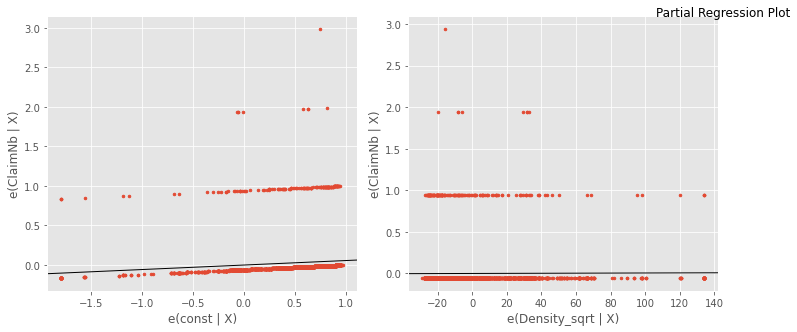


InverseGaussian fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.46022640134090725
Root Mean Squared Residual = 0.4660000775743807
                        R² = 5.197619418338077e-05

InverseGaussian prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.45924184751527336
Root Mean Squared Error = 0.46346134897216784
                     R² = 0.0001763963821483121

Plots of train-set fit & test-set predict:


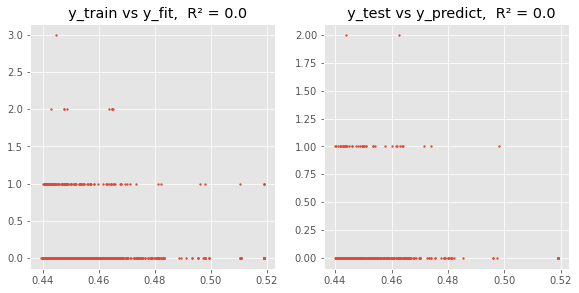

counter =  7
GLM Model Fitted =  NegativeBinomial
1 entered.

Assuming NegativeBinomial error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
DrivAge , DrivAge_sqrt
VehPower_15 , VehPower_15_sqar
Region__R25__sqrt , Region__R25__sqar
Region__R25__sqar , Region__R25_
DrivAge_28___22_sqrt , DrivAge_28___22
DrivAge_28___22 , DrivAge_28___22_sqar
BonusMalus_sqrt , BonusMalus
BonusMalus_125___148___61___63______sqar , BonusMalus_125___148___61___63______sqrt
BonusMalus_125___148___61___63______sqrt , BonusMalus_125___148___61___63_____

9 variables considered for deletion:
DrivAge_sqrt
VehPower_15_sqar
Region__R25__sqrt
Region__R25__sqar
DrivAge_28___22_sqrt
DrivAge_28___22_sqar
BonusMalus_sqrt
BonusMalus_125___148___61___63______sqar
BonusMalus_125___148___61___63______sqrt

X pairs with correlations > 0.995 :
VehPower_15 , VehPower_15_sqrt

1 variables considered for deletion:
VehPower_15_sqrt

X pairs with correlations > 0.995 :
(no more)

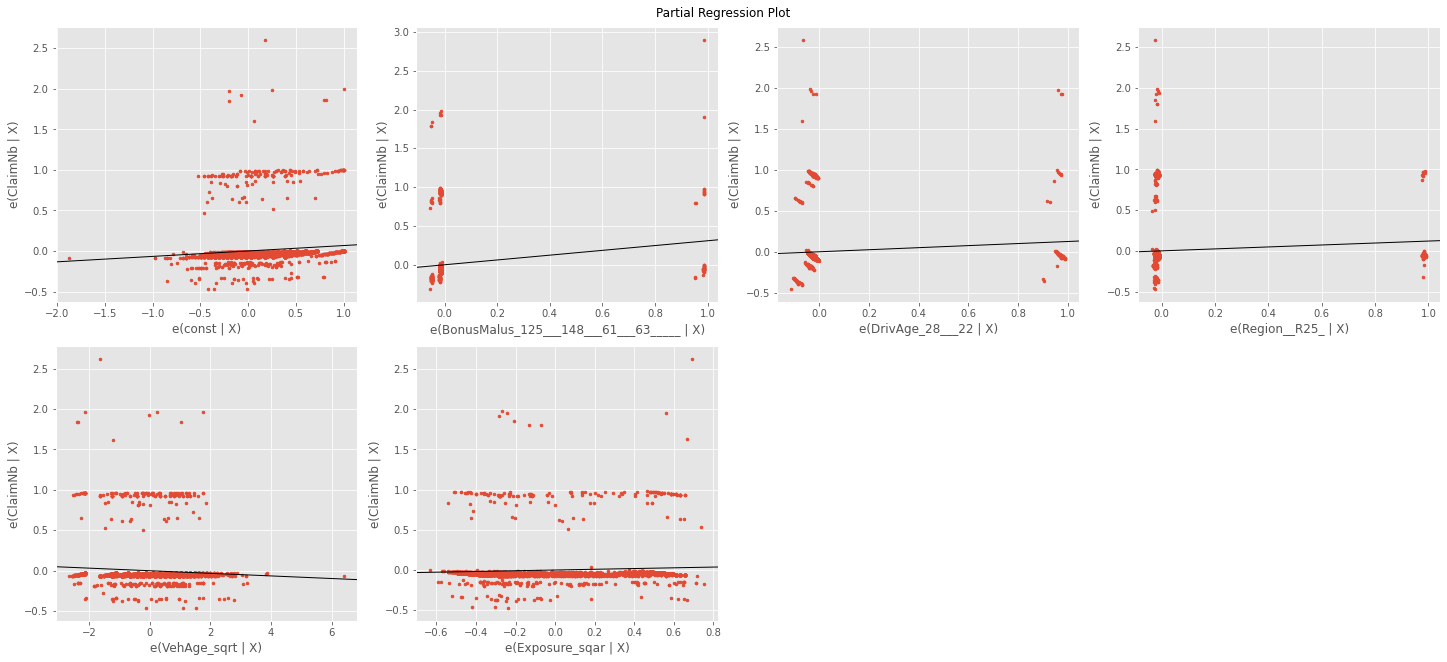


NegativeBinomial fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.10550939978010672
Root Mean Squared Residual = 0.24351456961765086
                        R² = 0.05234437843137699

NegativeBinomial prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.10879974974388452
Root Mean Squared Error = 0.24847492392007092
                     R² = 0.02024608364825934

Plots of train-set fit & test-set predict:


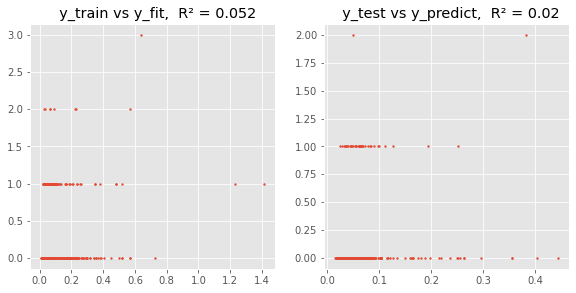

counter =  8
GLM Model Fitted =  Tweedie
1 entered.

Assuming Tweedie error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
DrivAge , DrivAge_sqrt
VehPower_15 , VehPower_15_sqar
Region__R25__sqrt , Region__R25__sqar
Region__R25__sqar , Region__R25_
DrivAge_28___22_sqrt , DrivAge_28___22
DrivAge_28___22 , DrivAge_28___22_sqar
BonusMalus_sqrt , BonusMalus
BonusMalus_125___148___61___63______sqar , BonusMalus_125___148___61___63______sqrt
BonusMalus_125___148___61___63______sqrt , BonusMalus_125___148___61___63_____

9 variables considered for deletion:
DrivAge_sqrt
VehPower_15_sqar
Region__R25__sqrt
Region__R25__sqar
DrivAge_28___22_sqrt
DrivAge_28___22_sqar
BonusMalus_sqrt
BonusMalus_125___148___61___63______sqar
BonusMalus_125___148___61___63______sqrt

X pairs with correlations > 0.995 :
VehPower_15 , VehPower_15_sqrt

1 variables considered for deletion:
VehPower_15_sqrt

X pairs with correlations > 0.995 :
(no more)

10 transformed v


Adjusted R² = 0.08704196346104487 , max(X p-value) = 0.38957928350634496 , rank deficiency = 3 , for 16 Xs.
Variable to drop: BonusMalus_x_VehAge

Adjusted R² = 0.08660478830796103 , max(X p-value) = 0.3129130217876299 , rank deficiency = 3 , for 15 Xs.
Variable to drop: Region__R25__x_VehAge

Adjusted R² = 0.08437021880437434 , max(X p-value) = 0.1435231858802754 , rank deficiency = 3 , for 14 Xs.
Variable to drop: BonusMalus_125___148___61___63______x_VehPower_15

Adjusted R² = 0.08437021880437345 , max(X p-value) = 0.025976932217681162 , rank deficiency = 2 , for 13 Xs.
Variable to drop: VehAge_sqar

Adjusted R² = 0.08381009519203653 , max(X p-value) = 0.3361593851123157 , rank deficiency = 2 , for 12 Xs.
Variable to drop: VehAge

Adjusted R² = 0.08297088132276331 , max(X p-value) = 0.025021575225117696 , rank deficiency = 2 , for 11 Xs.
Variable to drop: BonusMalus_125___148___61___63______x_BonusMalus

Adjusted R² = 0.06723600147293507 , max(X p-value) = 0.0017616363606009955 , r

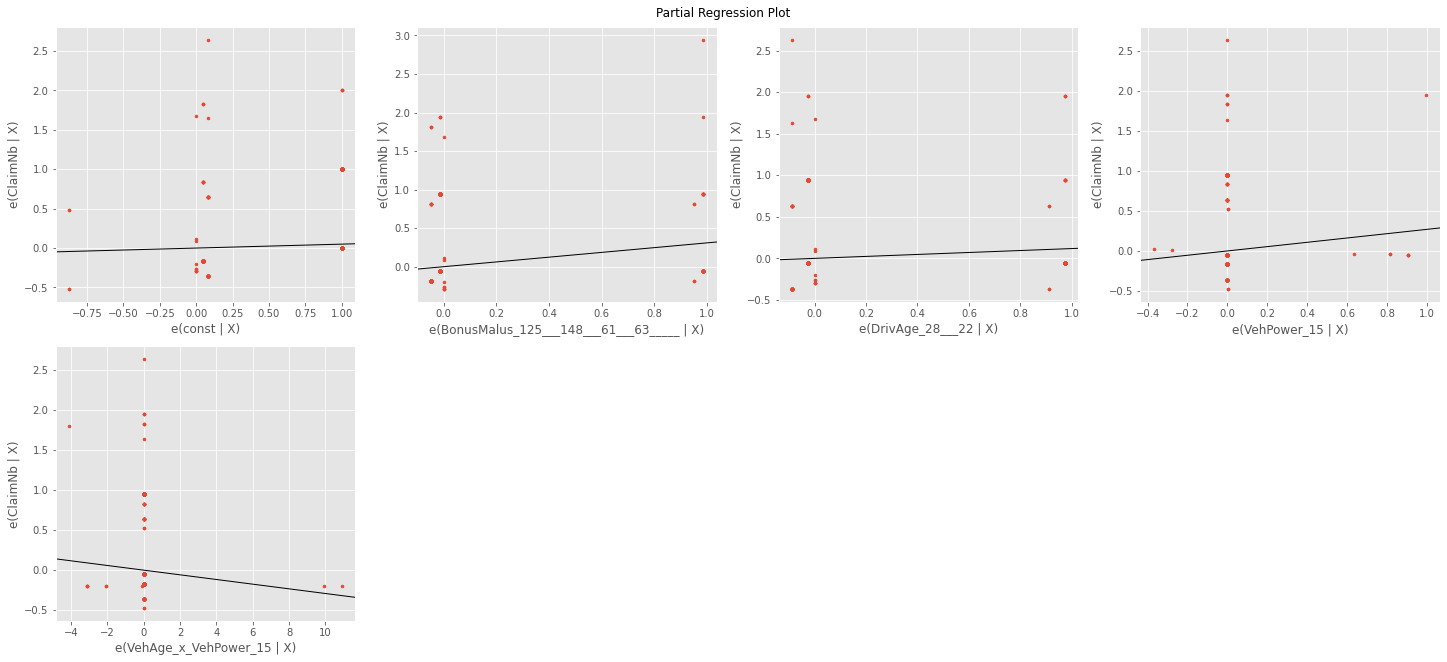


Tweedie fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.10615421202137042
Root Mean Squared Residual = 0.24417379257489588
                        R² = 0.04732115165395088

Tweedie prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.10994011600827797
Root Mean Squared Error = 0.24989153660552388
                     R² = 0.028105664521527976

Plots of train-set fit & test-set predict:


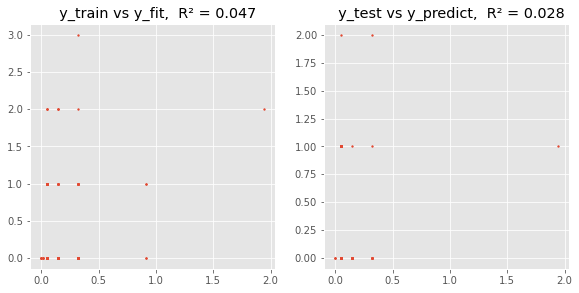

counter =  9
GLM Model Fitted =  GLM Gaussian
1 entered.

Assuming GLM Gaussian error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
DrivAge , DrivAge_sqrt
VehPower_15 , VehPower_15_sqar
Region__R25__sqrt , Region__R25__sqar
Region__R25__sqar , Region__R25_
DrivAge_28___22_sqrt , DrivAge_28___22
DrivAge_28___22 , DrivAge_28___22_sqar
BonusMalus_sqrt , BonusMalus
BonusMalus_125___148___61___63______sqar , BonusMalus_125___148___61___63______sqrt
BonusMalus_125___148___61___63______sqrt , BonusMalus_125___148___61___63_____

9 variables considered for deletion:
DrivAge_sqrt
VehPower_15_sqar
Region__R25__sqrt
Region__R25__sqar
DrivAge_28___22_sqrt
DrivAge_28___22_sqar
BonusMalus_sqrt
BonusMalus_125___148___61___63______sqar
BonusMalus_125___148___61___63______sqrt

X pairs with correlations > 0.995 :
VehPower_15 , VehPower_15_sqrt

1 variables considered for deletion:
VehPower_15_sqrt

X pairs with correlations > 0.995 :
(no more)

10 tra


Best model has 9 Xs (Adjusted R² = 0.05074708544341944 , rank deficiency = 0):

                                Results: Generalized linear model
Model:                          GLM                         AIC:                       52.8127    
Link Function:                  identity                    BIC:                       -23225.3946
Dependent Variable:             ClaimNb                     Log-Likelihood:            -16.406    
Date:                           2021-03-31 23:46            LL-Null:                   -99.474    
No. Observations:               2940                        Deviance:                  174.07     
Df Model:                       9                           Pearson chi2:              174.       
Df Residuals:                   2930                        Scale:                     0.059409   
Method:                         IRLS                                                              
-------------------------------------------------------------

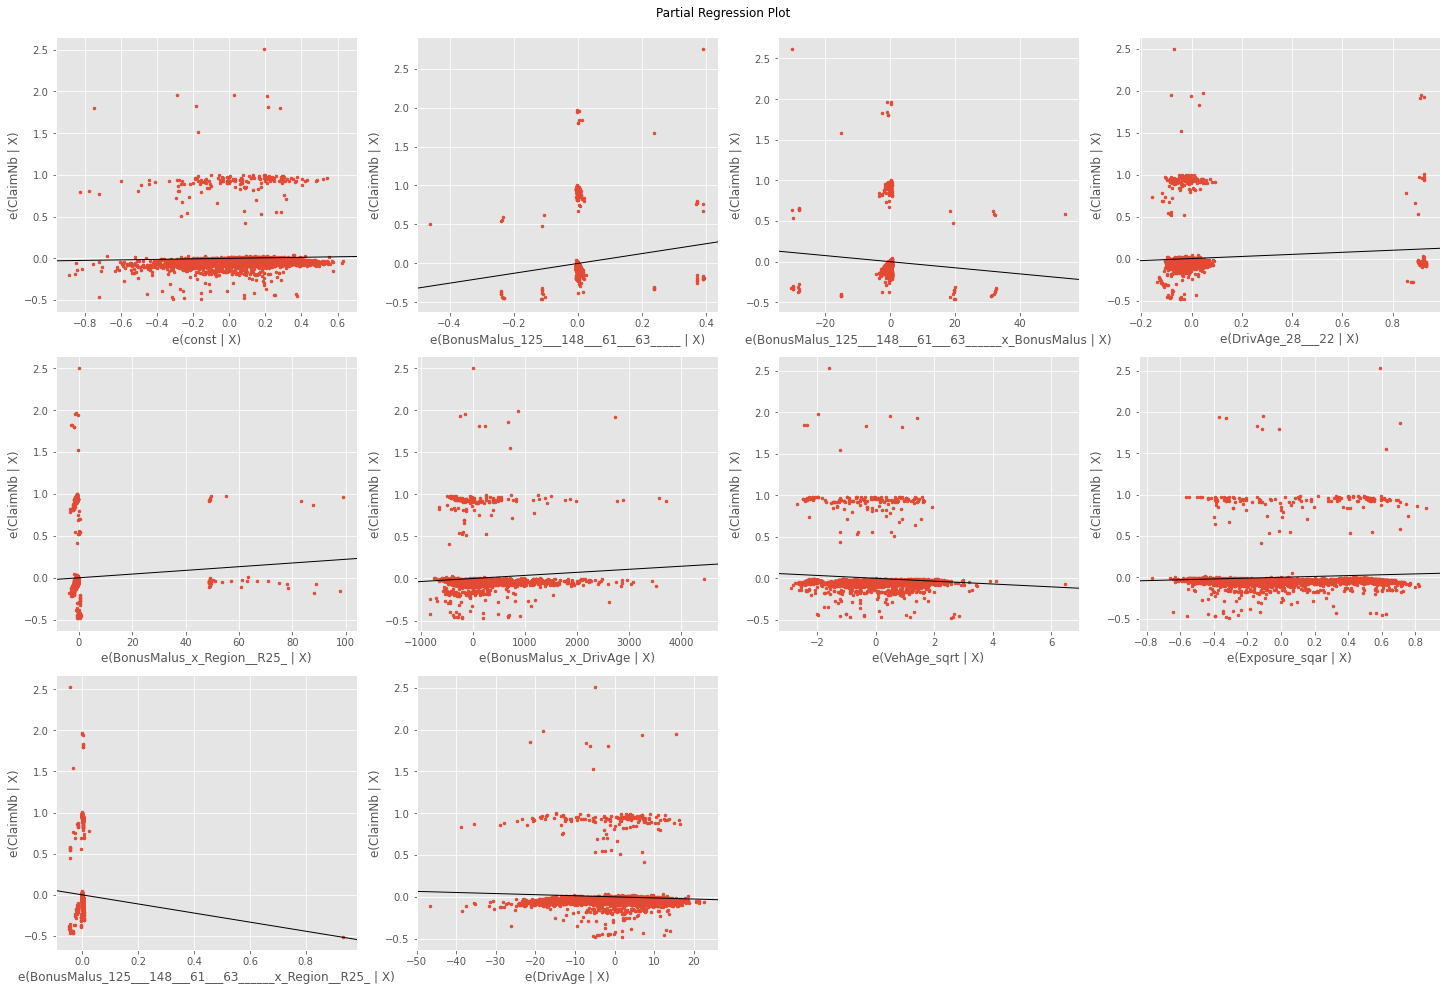


GLM Gaussian fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.10591154782255195
Root Mean Squared Residual = 0.24332479205419616
                        R² = 0.05365395044206161

GLM Gaussian prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.10984255449957281
Root Mean Squared Error = 0.2501623197477497
                     R² = 0.015544100543820322

Plots of train-set fit & test-set predict:


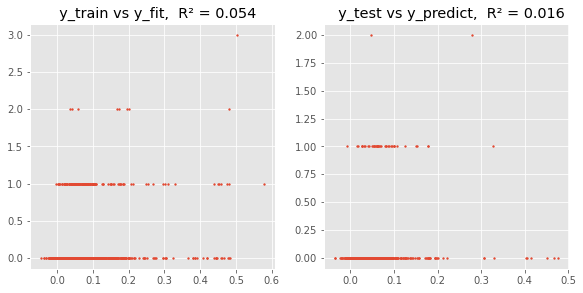

counter =  10
GLM Model Fitted =  Normal
1 entered.

Assuming Normal error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
DrivAge , DrivAge_sqrt
VehPower_15 , VehPower_15_sqar
Region__R25__sqrt , Region__R25__sqar
Region__R25__sqar , Region__R25_
DrivAge_28___22_sqrt , DrivAge_28___22
DrivAge_28___22 , DrivAge_28___22_sqar
BonusMalus_sqrt , BonusMalus
BonusMalus_125___148___61___63______sqar , BonusMalus_125___148___61___63______sqrt
BonusMalus_125___148___61___63______sqrt , BonusMalus_125___148___61___63_____

9 variables considered for deletion:
DrivAge_sqrt
VehPower_15_sqar
Region__R25__sqrt
Region__R25__sqar
DrivAge_28___22_sqrt
DrivAge_28___22_sqar
BonusMalus_sqrt
BonusMalus_125___148___61___63______sqar
BonusMalus_125___148___61___63______sqrt

X pairs with correlations > 0.995 :
VehPower_15 , VehPower_15_sqrt

1 variables considered for deletion:
VehPower_15_sqrt

X pairs with correlations > 0.995 :
(no more)

10 transformed va

Variable to drop: BonusMalus_125___148___61___63______x_Region__R25_

Adjusted R² = 0.0495190847274114 , max(X p-value) = 0.00966916344678343 , rank deficiency = 0 , for 8 Xs.
Variable to drop: BonusMalus_125___148___61___63______x_BonusMalus

Adjusted R² = 0.04767010449639386 , max(X p-value) = 0.015615519077589167 , rank deficiency = 0 , for 7 Xs.
Variable to drop: DrivAge

Adjusted R² = 0.04609452625346844 , max(X p-value) = 0.0010481805968042374 , rank deficiency = 0 , for 6 Xs.
Variable to drop: BonusMalus_x_DrivAge

Adjusted R² = 0.04292069658334219 , max(X p-value) = 0.00016765021854687126 , rank deficiency = 0 , for 5 Xs.
Variable to drop: BonusMalus_x_Region__R25_

Adjusted R² = 0.038616451995692636 , max(X p-value) = 5.032345458446075e-05 , rank deficiency = 0 , for 4 Xs.
Variable to drop: Exposure_sqar

Adjusted R² = 0.033546002849293766 , max(X p-value) = 0.0005084926883938043 , rank deficiency = 0 , for 3 Xs.
Variable to drop: VehAge_sqrt

Adjusted R² = 0.02988972369339337

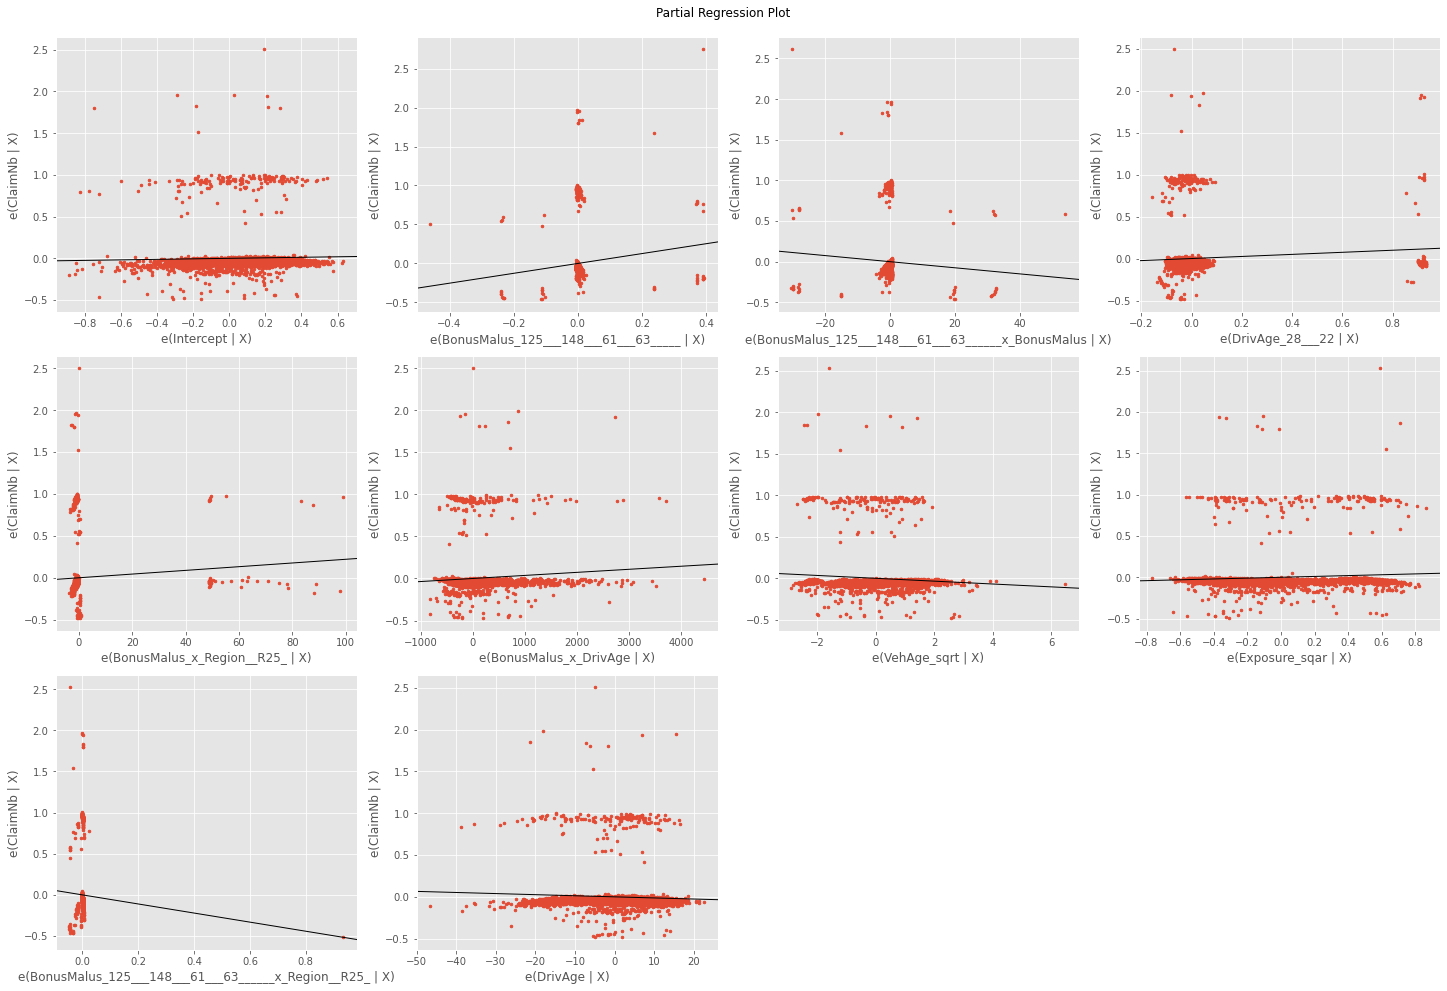


Normal fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.10591154782255195
Root Mean Squared Residual = 0.24332479205419616
                        R² = 0.05365395044206161

Normal prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.1098425544995728
Root Mean Squared Error = 0.2501623197477497
                     R² = 0.015544100543820322

Plots of train-set fit & test-set predict:


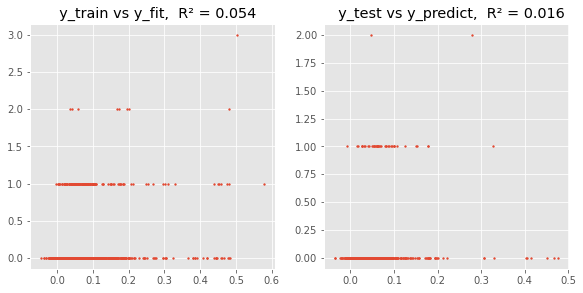

In [20]:
## Generalized Linear Model (GLM) with transformed variables & interaction variables (collinearity issue considered)

#For comparing Normal & GLM error distributions.

#algorithm is inefficient but clearer for instructional purposes
#favors fit with Xs' p-values < 0.05, and smaller rank-deficiency (number_of_Xs - Df_Model)

import warnings
warnings.filterwarnings('ignore')
try:
    import os
    os.chdir(os.environ['USERPROFILE'] + '\Documents' + r"\0_Teach\data")
except:
    #assume in current folder
    pass

import statsmodels.api as sm
import pandas as pd

#set maximum window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #change code window width to max
pd.options.display.max_columns = 0 #change output window width to max

counter = 1

#Iterate through 0 to 10, iterate through the GLM models
for i in range(0,10):  
    print("counter = ",counter)
    
    m2 = str(counter)
    counter += 1  
    
    # 1 out of the 2 following lines should be active:
    # d = '' #means nanes96 will be used
    d = 1 #means use specified dataset instead of the default nanes96: d=''

    if d == '':
        #American National Election Survey 1996 (anes96), http://statsmodels.org/dev/datasets/generated/anes96.html :
        dt = sm.datasets.anes96.load_pandas() #standard sm dataset, y (endog) and columns of X (exog)

        #peek at dataset:
        print('\nanes96 dataset:')
        print(dt.data)

        #this dataset actually not suitable for Poisson (although y is nonnegative integers)
        #    only used for illustrative purposes
        #many other datasets: http://statsmodels.org/dev/datasets

        #endogenous & exogenous component names:
        yname = dt.endog_name
        print('\ny =', yname, ' '*5, 'X =', dt.exog_name)
    else:
        #d = 1 case:
        
        #Use pre-processed data
        dt = df_clean_pre.copy() #specifying 1st column as row labels (called 'index')
        #handle special variabes

        yname = 'ClaimNb' #target variable

        import regex as re
        dt.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True) #replace ' ' by '_' in variable names
        yname = re.sub('\W', '_', yname)

        #delete any row with any missing value
        dt.dropna(how='any', inplace=True)
        if yname != dt.columns[0]:
            dt = dt[[yname] + list(dt.columns.drop(yname))]

        #m2 = input('1: OLS (default), 2: Poisson, 3: Logit, 4: Probit, 5: Gamma, 6: InverseGaussian, 7: NegativeBinomial,' +
                   #' 8: Tweedie, 9: Gaussian? ').strip()
        if m2 == '2':
            #https://www.statsmodels.org/stable/glm.html
            m = 'Poisson'
            dist = sm.families.Poisson()
        elif m2 == '3':
            m = 'Logit'
            dist = sm.families.Binomial()
        elif m2 == '4':
            m = 'Probit'
            #http://web.pdx.edu/~crkl/ceR/Python/example8_1.py
            dist = sm.families.Binomial(sm.genmod.families.links.probit)
        elif m2 == '5':
            m = 'Gamma'
            dist = sm.families.Gamma()
        elif m2 == '6':
            m = 'InverseGaussian'
            dist = sm.families.InverseGaussian()
        elif m2 == '7':
            m = 'NegativeBinomial'
            dist = sm.families.NegativeBinomial()
        elif m2 == '8':
            m = 'Tweedie'
            dist = sm.families.Tweedie()
        elif m2 == '9':
            m = 'GLM Gaussian'
            dist = sm.families.Gaussian()
        else:
            # m2 == 1 or ''
            m = 'Normal'
            
        print('GLM Model Fitted = ',m)

    ytype = type('a')
    if m == 'Normal':
        #there is a version of OLS that also requires endog and exog like GLM:
        #http://statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
        #df has y followed by Xs:
        if d == '':
            df = pd.concat([dt.endog, dt.exog], axis=1) #a DataFrame
        else:
            df = dt
        y = yname
    else:
        #df will not have y, but a column of 1s:
        if d == '':
            df = sm.add_constant(dt.exog) #add column of 1 to the left of dt.exog to form DataFrame
            y = dt.endog #PID: 0 to 6: Party IDentification of respondent (shades of Democrat or Republican)
        else:
            df = sm.add_constant(dt.iloc[:, 1:])
            y = dt.iloc[:, 0]
        ytype = type(y)

    #m3 = input('1: Reproducible output (input any integer except 2), 2: Random train-test data split [default: 1]? ').strip()
    m3 = 1
    if m3 != '2':
        try:
            if m3 == '':
                m3 = 1
            else:
                m3 = int(m3)
            print(m3, 'entered.')
        except:
            m3 = 1 #can be changed to any integer for reproducible randomization
            print(m3, 'assumed.')

    print('\nAssuming', m, 'error distribution.')

    def delcorr(df):
        #delete any x too highly correlated with another x, to avoid collinearity

        #corr(Xs, y) ranked:

    #     corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
    #     for x in list(df)[1:]:
    #         #during 1st time thru loop: new column, with label, created in empty dataframe:
    #         #during subsequent time thru loop: new row, with row label, added to dataframe:
    #         corv.loc[x, yname] = df[x].corr(df[yname] if m == 'Normal' else y)

    #     corv = corv.loc[abs(corv).sort_values([yname]).index, :] #corr(Xs, y) ranked

        corv = df.iloc[:, 1:].corrwith(df[yname] if m == 'Normal' else y).rename(yname).sort_values(key=abs).to_frame()

        delta = 0.005 #corr difference lower limit
        dl2 = []
        icorr = True
        while icorr:
            a = abs(corv).diff() <= delta #adjacent rows with similar abs(corr(Xs, y))
            colname = list(df)[1:]
            dl = []
            print('\nX pairs with correlations >', 1 - delta, ':')
            for b in range(1, a.shape[0]):
                if a.iloc[b, 0]:
                    if abs(df[a.index[b - 1]].corr(df[a.index[b]])) > 1 - delta:
                        #deleting 1 X from correlated pair:
                        dv0 = a.index[b - 1]
                        dv1 = a.index[b]

                        #neither should already be deleted:
                        if not (dv0 in dl) and not (dv1 in dl):
                            #delete x with rather lower corr(x, y):
                            if abs(corv.loc[dv0, y if type(y) == type('a') else y.name]
                                  ) - abs(corv.loc[dv1, y if type(y) == type('a') else y.name]) >= delta:
                                d = dv1
                            elif len(dv0) < len(dv1): #delete x with longer name:
                                d = dv1
                            else:
                                d = dv0

                            dl.append(d) #for en masse deletion later
                            corv.drop([d], axis=0, inplace=True) #delete from column of corr with y

                            print(dv0,',',dv1)

            if len(dl) > 0:
                df.drop(axis=1, columns=dl, inplace=True) #variables deleted en masse
                dl2 = dl2 + dl #keep for real deletion later
                print('\n' + str(len(dl)), 'variables considered for deletion:')
                print('\n'.join([str(x) for x in dl]))
            else:
                print('(no more)')
                icorr = False
        return dl2

    #delete collinear Xs:
    dl2 = delcorr(df)
    #df.drop(axis=1, columns=dl2, inplace=True) #collinear Xs deleted en masse #not necessary since df operated on directly
    if len(dl2) > 0:
        print('\n' + str(len(dl2)) + ' variables deleted.')

    #transform all Xs into either square & square-root or cube & cube-root using np.cbrt()

    trf = ['_sqar', '_sqrt', '_cube', '_cbrt']

    import numpy as np

    for i in list(df)[1:]:
        #excluded either y or column of 1s
        failed = False
        try:
            #searching for -ve values:
            df[i + trf[1]] = np.sqrt(df[i])
            if df[i + trf[1]].isnull().any():
                #bug reported by Sharifah
                failed = True
                del df[i + trf[1]]
            else:    
                df[i + trf[0]] = df[i] ** 2.
        except:
            failed = True
        if failed:
            try:
                #searching for non-numeric
                df[i + trf[2]] = df[i] ** 3.
                df[i + trf[3]] = np.cbrt(df[i])
            except:
                #column cannot be transformed
                #delete non-numeric column (with no questions asked!):
                df.drop(i, axis=1, inplace=True) #remove any row with any NaN

    #only numeric columns left

    #delete collinear Xs:
    df0 = df.copy()
    dl2 = delcorr(df0)
    dl2 = [x for x in dl2 if x[-5:] in trf]
    if len(dl2) > 0:
        df.drop(axis=1, columns=dl2, inplace=True) #collinear transformed variables deleted en masse
        print('\n' + str(len(dl2)) + ' transformed variables deleted.')

    from sklearn.model_selection import train_test_split
    #split into training & testing sets
    x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 1:] if m == 'Normal' else df,
                df[y] if m == 'Normal' else y, test_size=.2,
                random_state=(None if m3=='2' else m3)) #set to an integer (here m3) to get reproducible output

    #sort columns by absolute correlation with y, so may preferably delete last column if regression fails:
    x_train = x_train[x_train.corrwith(y_train).sort_values(ascending=False, na_position='first', key=abs).index]

    print('\nFit using', ('' if m3 == '2' else 'reproducible ') + 'random 80% (x_train & y_train) of data rows:')

    #first do OLS on untransformed Xs:
    df = pd.concat([y_train, x_train if m == 'Normal' else x_train.iloc[:, 1:]], axis=1)
    xpure = [x for x in list(df) if x[-5:] not in trf]
    numx = len(xpure) - 1
    print('\nOLS fit including only', numx, 'untransformed Xs:')

    #initialize for adj-R2:
    ddf = np.inf #deficiency in degree of freedom = rank deficiency
    maxR2 = -np.inf
    bmodeleq = ''

    bic0 = np.inf #bic kept by lowest overall rank deficiency
    bic5 = bic0   #bic kept by best model with p-values < 0.05
    bicd = bic0   #bic kept by lowest rank deficiency
    bbic = bic0   #best bic kept by adj-R2

    p05 = False #once found all Xs' p-values < 0.05

    modeleq = ' + '.join(list(xpure)).replace('+', '~', 1)
    from statsmodels.formula.api import ols
    try:
        out = ols(modeleq, df).fit()
        print(out.summary2())
        if numx > 1:
            print("\nDescending order of", numx, "X's significance, assuming Normal error distribution:")
            print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
            #if the single best variable isn't high in above ranking, collinearity might be an issue

        dfm = int(out.df_model)

        ddf = numx - dfm #rank deficiency
        maxR2 = out.rsquared_adj
        bmodeleq = modeleq
        print('\n' + 'Rank deficiency =', str(ddf) + ': Df Model (' + str(dfm) + ') is',
              ('less than' if ddf > 0 else 'same as'), 'number of Xs (' + str(numx) + ').')
    except:
        pass

    print('\n'+ m, 'fit including transformed Xs:')

    if m != 'Normal':
        #undo above ols:
        ddf = np.inf
        maxR2 = -np.inf
        bmodeleq = ''

        df = x_train
        y = y_train

    #initialize for rank deficiency:
    ddfd = ddf #best rank deficiency
    R2df = maxR2 #R2 for best rank deficiency
    modeleqdf = bmodeleq #modeleq for best rank deficiency

    #initialize for overall rank deficiency
    ddf0 = ddfd
    R2df0 = R2df
    modeleqdf0 = modeleqdf

    bddf = ddfd #rank deficiency for best adj-R2 model

    #initialize for z-stat p-values < 0.05:
    ddf5 = np.inf #rank deficiency for best model with p-values < 0.05
    R205 = -np.inf #adj-R2 for best model with p-values < 0.05
    modeleq05 = '' #modeleq for best model with p-values < 0.05

    df0 = df.copy() #kept for inclusion of interaction variables later

    #perform feature selection using adjusted R2

    #model equation actually not used by GLM:
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    #print(modeleq)
    numx = df.shape[1] - 1

    x1x2 = False #interaction variables not yet included

    while True:
        if m == 'Normal':
            #https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html
            out = ols(modeleq, df).fit()
            R2 = out.rsquared_adj
        else:
            #GLM distribution
            try:
                #https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html
                out = sm.GLM(y, df, family=dist).fit()
                R2 = 1 - (1 - y.corr(out.fittedvalues)**2) * (out.nobs - 1) / out.df_resid #pseudo adjusted r2
                if R2 != R2 and out.fittedvalues.isna().sum() == 0:
                    R2 = -np.inf
                    #R2 = -out.bic
            except:
                #GLM failed!  do ols for this round, just to delete 1 x:
                try:
                    out = ols(' + '.join(list(df)).replace('+', '~', 1), df).fit() #do OLS instead
                except:
                    pass
                R2 = -np.inf

        try:
            maxp = max(out.pvalues[1:])
            dfm = int(out.df_model)
        except:
            maxp = 1
            dfm = 0
        ddf = numx - dfm #rank deficiency

        #see if a better model is found:
        try:
            if R2 >= maxR2 and out.fittedvalues.isna().sum() == 0:
                maxR2 = R2
                bmodeleq = modeleq
                bddf = min(bddf, ddf)

                ddf0 = ddf #best overall rank deficiency

                if maxR2 == -np.inf:
                    bbic = out.bic

                if maxp >= 0.05 and not p05:
                    #reset z-stat p-value criterion:
                    R205 = -np.inf
                    modeleq05 = ''

                    #reset rank deficiency criterion:
                    R2df = R205
                    modeleqdf = ''
                    ddfd = bddf #reset deficient df
                else:
                    p05 = True
                #if m != 'Normal':
                #    df1 = df.copy()

            #see if a model is found with reduced overall rank deficiency:
            if ddf < ddf0 or (ddf == ddf0 and R2 > R2df0):
                R2df0 = R2
                modeleqdf0 = modeleq
                ddf0 = ddf #best overall rank deficiency
                if maxR2 == -np.inf:
                    bic0 = out.bic

            #see if a better model is found with max(z-stat p-value) < .05:
            if maxp < .05 and (R2 > R205 or modeleq05 == ''):
                R205 = R2
                modeleq05 = modeleq
                ddf5 = min(ddf5, ddf) #rank deficiency for best model with p-values < .05
                if maxR2 == -np.inf:
                    bic5 = out.bic

            #see if a model is found with reduced rank-deficiency:
            if ddf < ddfd or (ddf == ddfd and R2 > R2df):
                R2df = R2
                modeleqdf = modeleq
                ddfd = min(ddfd, ddf) #best rank deficiency
                if maxR2 == -np.inf:
                    bicd = out.bic
        except:
            pass

        print('\nAdjusted R² =', R2, ', max(X p-value) =', maxp, ', rank deficiency =', ddf, ', for', numx, 'Xs.')

        if numx == 1:
            print('Variable left:', modeleq[modeleq.find('~') + 2 :])
            if x1x2:
                #one xvar left
                #get out of 'while' loop:
                break

            else:
                if maxR2 == -np.inf and out.fittedvalues.isna().sum() > 0:
                    print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')
                    #use all Xs before deletion:
                    bmodeleq = ' + '.join(list(df0)).replace('+', '~', 1)
                else:
                    #see if best model with all z-stat p-values < 0.05 is smaller than best model by adjusted R2:
                    if (R205 > -np.inf and len(modeleq05) < len(bmodeleq)) or (
                        R205 == -np.inf and (maxR2 == -np.inf or (len(modeleq05) > 0 and len(modeleq05) < len(bmodeleq)))):
                        bmodeleq = modeleq05
                        maxR2 = R205
                        #bddf = min(bddf, ddf5)
                        bddf = ddf5

                        if maxR2 == -np.inf:
                            bmodeleq0 = bmodeleq
                            bddf0 = bddf
                            bbic = bic5 #best bic
                            bic5 = np.inf #re-initialize

                    #see if model with smallest rank-deficiency is smaller than best model so far:
                    if (R2df > -np.inf and len(modeleqdf) < len(bmodeleq)) or (
                        R2df == -np.inf and (maxR2 == -np.inf or (len(modeleqdf) > 0 and len(modeleqdf) < len(bmodeleq)))):
                        bmodeleq = modeleqdf
                        maxR2 = R2df
                        #bddf = min(bddf, ddfd)
                        bddf = ddfd

                        if maxR2 == -np.inf:
                            bmodeleq0 = bmodeleq
                            bddf0 = bddf
                            bbic = bicd #best bic
                            bicd = np.inf #re-initialize

                    if maxR2 == -np.inf:
                        #reset z-stat p-value criterion:
                        R205 = -np.inf
                        modeleq05 = ''

                        #reset rank deficiency criterion:
                        R2df = R205
                        modeleqdf = ''
                        ddfd = np.inf #reset deficient df

                #add interaction variables for original untransformed variables in best model so far

                numx = bmodeleq.count('+') + 1
                if numx == 1:
                    bmodeleq = ' + '.join(list(df0)).replace('+', '~', 1)
                    numx = bmodeleq.count('+') + 1
                print('\nRestarting from best model (with', numx, 'Xs & Adjusted R² =', str(maxR2) + ') found so far...')

                colname = bmodeleq.replace('~', '+').split(' + ')
                df = df0[colname]
                colname = colname[1:] #remove y or 'const'
                x_test = x_test[colname]

    #             for i in range(numx):
    #                 #look for 1st transformed variable:
    #                 if colname[i][-5:] in trf:
    #                     i = i - 1
    #                     #colname[i] is the last untransformed x
    #                     break

    #             #actually, nothing to do if i<=0
    #             print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
    #                   'untransformed variables in best model found so far:')
    #             for j in range(i):
    #                 #untransformed x in colname up to [i]
    #                 for k in range(j + 1, i + 1):
    #                     a = colname[j] + '_x_' + colname[k]
    #                     print(a)
    #                     df[a] = df[colname[j]] * df[colname[k]]
    #                     x_test[a] = x_test[colname[j]] * x_test[colname[k]]

                xpure = [x for x in colname if x[-5:] not in trf] #untransformed x names
                i = len(xpure) - 1

                #actually, nothing to do if i<=0
                print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
                      'untransformed variables in best model found so far:')
                for j in range(i):
                    #untransformed x in colname up to [i]
                    for k in range(j + 1, i + 1):
                        a = xpure[j] + '_x_' + xpure[k]
                        print(a)
                        df[a] = df[xpure[j]] * df[xpure[k]]
                        x_test[a] = x_test[xpure[j]] * x_test[xpure[k]]

                df0 = df.copy()

                #delete collinear Xs introduced:
                dl2 = delcorr(df)
                dl2 = [x for x in dl2 if x.find('_x_') != -1] #only interaction variables kept
                if len(dl2) > 0:
                    df0.drop(axis=1, columns=dl2, inplace=True) #collinear interaction variables deleted en masse, for real
                    x_test.drop(axis=1, columns=dl2, inplace=True)
                    #remaining Xs may be collinear
                    print('\n' + str(len(dl2)) + ' interaction variables deleted.')

                #potential collinearity issues handled

                #sort columns by absolute correlation with y, so may delete last column if regression fails:
                #df0 = df0[df0.corrwith(y_train).sort_values(ascending=False, na_position='first', key=abs).index]
                df0 = df0[[df0.columns[0]] + list(df0.iloc[:, 1:].corrwith(y_train)
                                                  .sort_values(ascending=False, na_position='first', key=abs).index)]

                modeleq = ' + '.join(list(df0)).replace('+', '~', 1)
                numx = df0.shape[1] - 1
                if maxR2 == -np.inf:
                    bddf = np.inf
                    ddf5 = bddf
                    ddfd = bddf
                    p05 = False
                x1x2 = True #interaction variables already included

                #beyond-pairwise collinearity may still be introduced with the interaction variables

                df = df0.copy() #ready for continuing deletion
                continue

        #identify X variable to delete by finding the one with smallest abs(t-stat):
        t = out.tvalues[1:]
        try:
            xdrop = list(t[abs(t) == min(abs(t))].index)[-1]
        except:
            xdrop = list(t.index)[-1]
        print('Variable to drop:', xdrop)

        try:
            df.drop(xdrop, axis=1, inplace=True)

        except:
            pass

        modeleq = ' + '.join(list(df)).replace('+', '~', 1)

        numx = numx - 1

    #see if best model with all z-stat p-values < 0.05 is smaller than best model by adjusted R2:
    if (R205 > -np.inf and len(modeleq05) < len(bmodeleq)) or (
        R205 == -np.inf and (maxR2 == -np.inf or (len(modeleq05) > 0 and len(modeleq05) < len(bmodeleq)))):
        bmodeleq = modeleq05
        maxR2 = R205
        bddf = ddf5

    #see if model with smallest rank-deficiency is smaller than best model so far:
    if (R2df > -np.inf and len(modeleqdf) < len(bmodeleq)) or (
        R2df == -np.inf and (maxR2 == -np.inf or (len(modeleqdf) > 0 and len(modeleqdf) < len(bmodeleq)))):
        bmodeleq = modeleqdf
        maxR2 = R2df
        bddf = ddfd

    if maxR2 == -np.inf and out.fittedvalues.isna().any():
        #some nan in y fit
        print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')
    else:
        try:
            if bddf >= ddf0 and ((maxR2 > -np.inf and R2df0 >= maxR2) or (maxR2 == -np.inf and bic0 <= bbic)):
                bmodeleq_0 = bmodeleq
                maxR2_0 = maxR2
                bddf_0 = bddf

                #prefer smaller rank deficiency
                if m == 'Normal':
                    out = ols(modeleqdf0, df0).fit()
                else:
                    out = sm.GLM(y, df0[modeleqdf0.replace('~', '+').split(' + ')], family=dist).fit()
                if max(out.pvalues[1:]) < 0.05:
                    #Xs' p-values < 0.05
                    bmodeleq = modeleqdf0
                    maxR2 = R2df0
                    bddf = ddf0
        except:
            bmodeleq = bmodeleq_0
            maxR2 = maxR2_0
            bddf = bddf_0

        try:
            if m == 'Normal':
                out = ols(bmodeleq, df0).fit()
                #collinearity is still entirely possible at this stage
                x_test = x_test[df0.columns[1:]]
            else:
                #out = sm.GLM(y, df1, family=dist).fit()
                #x_test = sm.add_constant(x_test)[df1.columns]
                df0 = df0[bmodeleq.replace('~', '+').split(' + ')]
                out = sm.GLM(y, df0, family=dist).fit()
                x_test = sm.add_constant(x_test)[df0.columns]

            numx = bmodeleq.count('+') + 1
            print('\nBest model has', numx, 'Xs (Adjusted R² =', str(maxR2), ', rank deficiency =', str(bddf) + '):\n')
            print(out.summary2())

            if m == 'Normal':
                print()

            if numx > 1:
                print("Descending order of", numx, "X's significance, assuming", m, 'error distribution:')
                #print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
                print(pd.concat([pd.concat([out.params[:1], out.tvalues[:1]], 1), pd.concat([out.params[1:], out.tvalues[1:]], 1
                       ).sort_values(1, key=abs, ascending=False)]).rename(columns={0:"Coefficient", 1:"z-stat"}))
                #if the single best variable isn't high in above ranking, collinearity might be an issue

            dfm = int(out.df_model)
            print('\n' + 'Rank deficiency =', str(bddf) + ': Df Model (' + str(dfm) + ') is',
                  ('less than' if bddf > 0 else 'same as'), 'number of Xs (' + str(numx) + ').')

            import matplotlib.pyplot as pl
            %matplotlib inline
            pl.rcParams['lines.markersize'] = 2.5
            pl.rcParams['lines.linewidth'] = 1

    #         if m == 'Normal':
            #partial leverage plots, partial regression plots, added-variable plots
            #https://r-bloggers.com/2021/03/partial-regression-plots-in-julia-python-and-r
            #https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_partregress.html
            #https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_partregress_grid.html

            from statsmodels.graphics.regressionplots import plot_partregress_grid
            import math
            #includes intercept; 4 plots to a row:
            nr = math.ceil((numx + 1) / 4) #number of rows of plots
            pl.rcParams["figure.figsize"] = (20.2, 14 / 3 * nr) #plot height depends on number of rows of plots
            print('\nPartial Leverage (or Partial Regression, or Added-Variable) diagnostic plots for fit:')
            #grid(rows, columns) for plots; fixed at 4 columns of plots per row:
            plot_partregress_grid(out, grid=(nr, 4))
            pl.show()

            y_fit = out.fittedvalues
            y_train = df.iloc[:, 0] if m == 'Normal' else y
            print('\n'+ m, 'fit using', ('' if m3 == '2' else 'reproducible ') + 'random 80% (x_train & y_train) of data rows:\n')
            print('    Mean Absolute Residual =', abs(y_train - y_fit).mean())
            print('Root Mean Squared Residual =', np.sqrt(((y_train - y_fit) ** 2.).mean()))
            r2_train = y_train.corr(y_fit) ** 2.
            print('                        R² =', r2_train)

            y_predict = out.predict(x_test) #forecast
            print('\n' + m, 'prediction using remaining 20% (x_test & y_test) of data rows:\n')
            print('    Mean Absolute Error =', abs(y_test - y_predict).mean())
            print('Root Mean Squared Error =', np.sqrt(((y_test - y_predict) ** 2.).mean()))
            r2_test = y_test.corr(y_predict) ** 2.
            print('                     R² =', r2_test)

            print('\nPlots of train-set fit & test-set predict:')

            #plot y_train vs y_fit
            #https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python
    #         pl.rcParams["figure.figsize"] = (4.04, 4.04)
            pl.rcParams["figure.figsize"] = (20.2, 4.5)
    #         pl.rcParams['lines.markersize'] = 3
            pl.subplot(1, 4, 1) #1 row, 4 columns, plot 1
            pl.title('  y_train vs y_fit,  R² = ' + str(round(r2_train, 3)))
            pl.scatter(y_fit, y_train, s=3)
    #         pl.show()

            #plot y_test vs y_predict
            pl.subplot(1, 4, 2) #1 row, 4 columns, plot 2
            pl.title('  y_test vs y_predict,  R² = ' + str(round(r2_test, 3)))
    #         pl.scatter(y_predict, y_test, s=3);
            pl.scatter(y_predict, y_test, s=3)
            pl.show()
        except:
            print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')

#### Interaction Variables
The Interaction Variable function tests for interaction variables that have very low P values, which means that their t values are significant to be used for our model prediction. This suggests that these variables are significant enough to be used to train my each model to predict ClaimNb.

#### Regression Collinearity
The Collinearity function tests for variable pairs that are correlated to each other by more than 0.995. If they are correlated by >0.995, we omit these variables for our model prediction.

#### Variable Selection
The code has already taken care of adding dummy variables for the cateogrical variables, the dummy variable trap is also considered in the code. The categorical variables (Area,VehPower,VehBrand,Region) have more than 2 categories each and (VehGas) has 2 categories. If each catergorical variable has k variables, we will create k - 1 indicators for that category. We use one-hot encoding for this task.

The Baseline variables are as follows:

Baseline for Area Category: A

Baseline for VehPower Category: 4

Baseline for VehBrand Category: B1

Baseline for VehGas Category: Diesel

Baseline for Region Category: R11

These baseline variables will not have any coefficient as shown above in each results summary.

Regression coefficient of the dummy of a category is interpreted as the amount by which that category differs from the (intercept of the) baseline, after allowing for the linear effects of the other variables in the model.

Using F-test and t-test from the variable selection function, the code selects the independent variables that enables the best linear model equation to predict our dependent variable (ClaimNb).

#### Conclusion
Thus, we will use the Poisson Model with the pre-processed method for our report as it was the highest R^2 among all GLM Models.

## Using Poisson Model without pre-processed method

After running and comparing the different GLM Models, we decide on using Poisson Model to report the results of prediction of number of insurance claims.


The definition of count based data contains events that occur at a certain rate. The rate of occurrence may change over time or from one observation to next.

As our predicted feature, Number of Insurance Claims (or ClaimNb) is 
- a count data (0,1,... to infinity)
- Discrete, skewed distribution
- High proportion of zeros (Implies skewed distribution)
- Non negative

We can try Poisson Regression Model to fit our model. In a Poisson regression model, claims are distributed according to a Poisson distribution with equal mean and variance. Therefore, to build an appropriate model we need to test our dataset for the presence of over-dispersion.

1: OLS (default), 2: Poisson, 3: Logit, 4: Probit, 5: Gamma, 6: InverseGaussian, 7: NegativeBinomial, 8: Tweedie, 9: Gaussian? 2
1: Reproducible output (input any integer except 2), 2: Random train-test data split [default: 1]? 1
1 entered.

Assuming Poisson error distribution.

X pairs with correlations > 0.995 :
(no more)

X pairs with correlations > 0.995 :
Region__R21__sqar , Region__R21__sqrt
Region__R21__sqrt , Region__R21_
VehBrand__B13_ , VehBrand__B13__sqrt
VehBrand__B11__sqrt , VehBrand__B11_
VehBrand__B11_ , VehBrand__B11__sqar
VehBrand__B3__sqrt , VehBrand__B3_
VehBrand__B3_ , VehBrand__B3__sqar
VehPower_14_sqrt , VehPower_14_sqar
VehPower_14_sqar , VehPower_14
VehBrand__B2__sqar , VehBrand__B2__sqrt
VehBrand__B2__sqrt , VehBrand__B2_
Region__R94__sqrt , Region__R94__sqar
Region__R94__sqar , Region__R94_
VehBrand__B12_ , VehBrand__B12__sqrt
VehBrand__B4_ , VehBrand__B4__sqrt
Region__R22__sqar , Region__R22__sqrt
Region__R22__sqrt , Region__R22_
Region__R52_ , Region__R52__s


Adjusted R² = 0.01788172673294952 , max(X p-value) = 0.8418117302663387 , rank deficiency = 1 , for 62 Xs.
Variable to drop: Region__R22_

Adjusted R² = 0.017883849880231284 , max(X p-value) = 0.8275018319499818 , rank deficiency = 1 , for 61 Xs.
Variable to drop: VehBrand__B2_

Adjusted R² = 0.01788521204476723 , max(X p-value) = 0.8148380075330915 , rank deficiency = 1 , for 60 Xs.
Variable to drop: Region__R42_

Adjusted R² = 0.01788848604267712 , max(X p-value) = 0.7447633541463381 , rank deficiency = 1 , for 59 Xs.
Variable to drop: VehBrand__B4_

Adjusted R² = 0.017889465727523812 , max(X p-value) = 0.6690356747279254 , rank deficiency = 1 , for 58 Xs.
Variable to drop: Area__D_

Adjusted R² = 0.01789416649079756 , max(X p-value) = 0.6602008081118286 , rank deficiency = 1 , for 57 Xs.
Variable to drop: VehBrand__B3_

Adjusted R² = 0.01789593465659578 , max(X p-value) = 0.6448872903028801 , rank deficiency = 1 , for 56 Xs.
Variable to drop: VehPower_13

Adjusted R² = 0.0178972853


Adjusted R² = 0.0070795303260132725 , max(X p-value) = 1.4869313441503562e-83 , rank deficiency = 0 , for 3 Xs.
Variable to drop: VehAge

Adjusted R² = 0.006747012526559404 , max(X p-value) = 4.6764626908928375e-250 , rank deficiency = 0 , for 2 Xs.
Variable to drop: VehAge_sqrt

Adjusted R² = 0.004909807563758362 , max(X p-value) = 0.0 , rank deficiency = 0 , for 1 Xs.
Variable left: Exposure_sqrt

Restarting from best model (with 20 Xs & Adjusted R² = 0.01773307863323681) found so far...

Adding 91 2-way interactions among 14 untransformed variables in best model found so far:
BonusMalus_x_VehAge
BonusMalus_x_VehGas__Regular_
BonusMalus_x_Region__R53_
BonusMalus_x_DrivAge
BonusMalus_x_Region__R82_
BonusMalus_x_VehPower_5
BonusMalus_x_Region__R24_
BonusMalus_x_Density
BonusMalus_x_VehPower_6
BonusMalus_x_VehPower_9
BonusMalus_x_VehPower_11
BonusMalus_x_VehPower_10
BonusMalus_x_VehPower_7
VehAge_x_VehGas__Regular_
VehAge_x_Region__R53_
VehAge_x_DrivAge
VehAge_x_Region__R82_
VehAge_x_V


Adjusted R² = 0.019191620219955685 , max(X p-value) = 0.976651956735232 , rank deficiency = 16 , for 72 Xs.
Variable to drop: Density_x_VehPower_11

Adjusted R² = -inf , max(X p-value) = 0.9863455136326087 , rank deficiency = 16 , for 71 Xs.
Variable to drop: VehPower_9

Adjusted R² = 0.019168945335858778 , max(X p-value) = 0.8296143629045314 , rank deficiency = 16 , for 70 Xs.
Variable to drop: VehAge_x_Region__R24_

Adjusted R² = -inf , max(X p-value) = 0.9946067174671839 , rank deficiency = 16 , for 69 Xs.
Variable to drop: VehPower_5

Adjusted R² = 0.019166964023639488 , max(X p-value) = 0.9008425607046592 , rank deficiency = 16 , for 68 Xs.
Variable to drop: VehPower_5_x_VehPower_7

Adjusted R² = -inf , max(X p-value) = 0.9936493056443497 , rank deficiency = 15 , for 67 Xs.
Variable to drop: VehGas__Regular_

Adjusted R² = -inf , max(X p-value) = 0.9434243438326787 , rank deficiency = 15 , for 66 Xs.
Variable to drop: VehGas__Regular__x_Region__R24_

Adjusted R² = -inf , max(X p-


Adjusted R² = 0.0 , max(X p-value) = nan , rank deficiency = 13 , for 13 Xs.
Variable to drop: VehPower_9_x_VehPower_7

Adjusted R² = 0.0 , max(X p-value) = nan , rank deficiency = 12 , for 12 Xs.
Variable to drop: VehPower_9_x_VehPower_10

Adjusted R² = 0.0 , max(X p-value) = nan , rank deficiency = 11 , for 11 Xs.
Variable to drop: VehPower_9_x_VehPower_11

Adjusted R² = -inf , max(X p-value) = nan , rank deficiency = 10 , for 10 Xs.
Variable to drop: VehPower_9_x_VehPower_11

Adjusted R² = -inf , max(X p-value) = nan , rank deficiency = 9 , for 9 Xs.
Variable to drop: VehPower_6_x_VehPower_7

Adjusted R² = 0.0 , max(X p-value) = nan , rank deficiency = 8 , for 8 Xs.
Variable to drop: VehPower_6_x_VehPower_10

Adjusted R² = 0.0 , max(X p-value) = nan , rank deficiency = 7 , for 7 Xs.
Variable to drop: VehPower_6_x_VehPower_11

Adjusted R² = 0.0 , max(X p-value) = nan , rank deficiency = 6 , for 6 Xs.
Variable to drop: VehPower_6_x_VehPower_9

Adjusted R² = 0.0 , max(X p-value) = nan

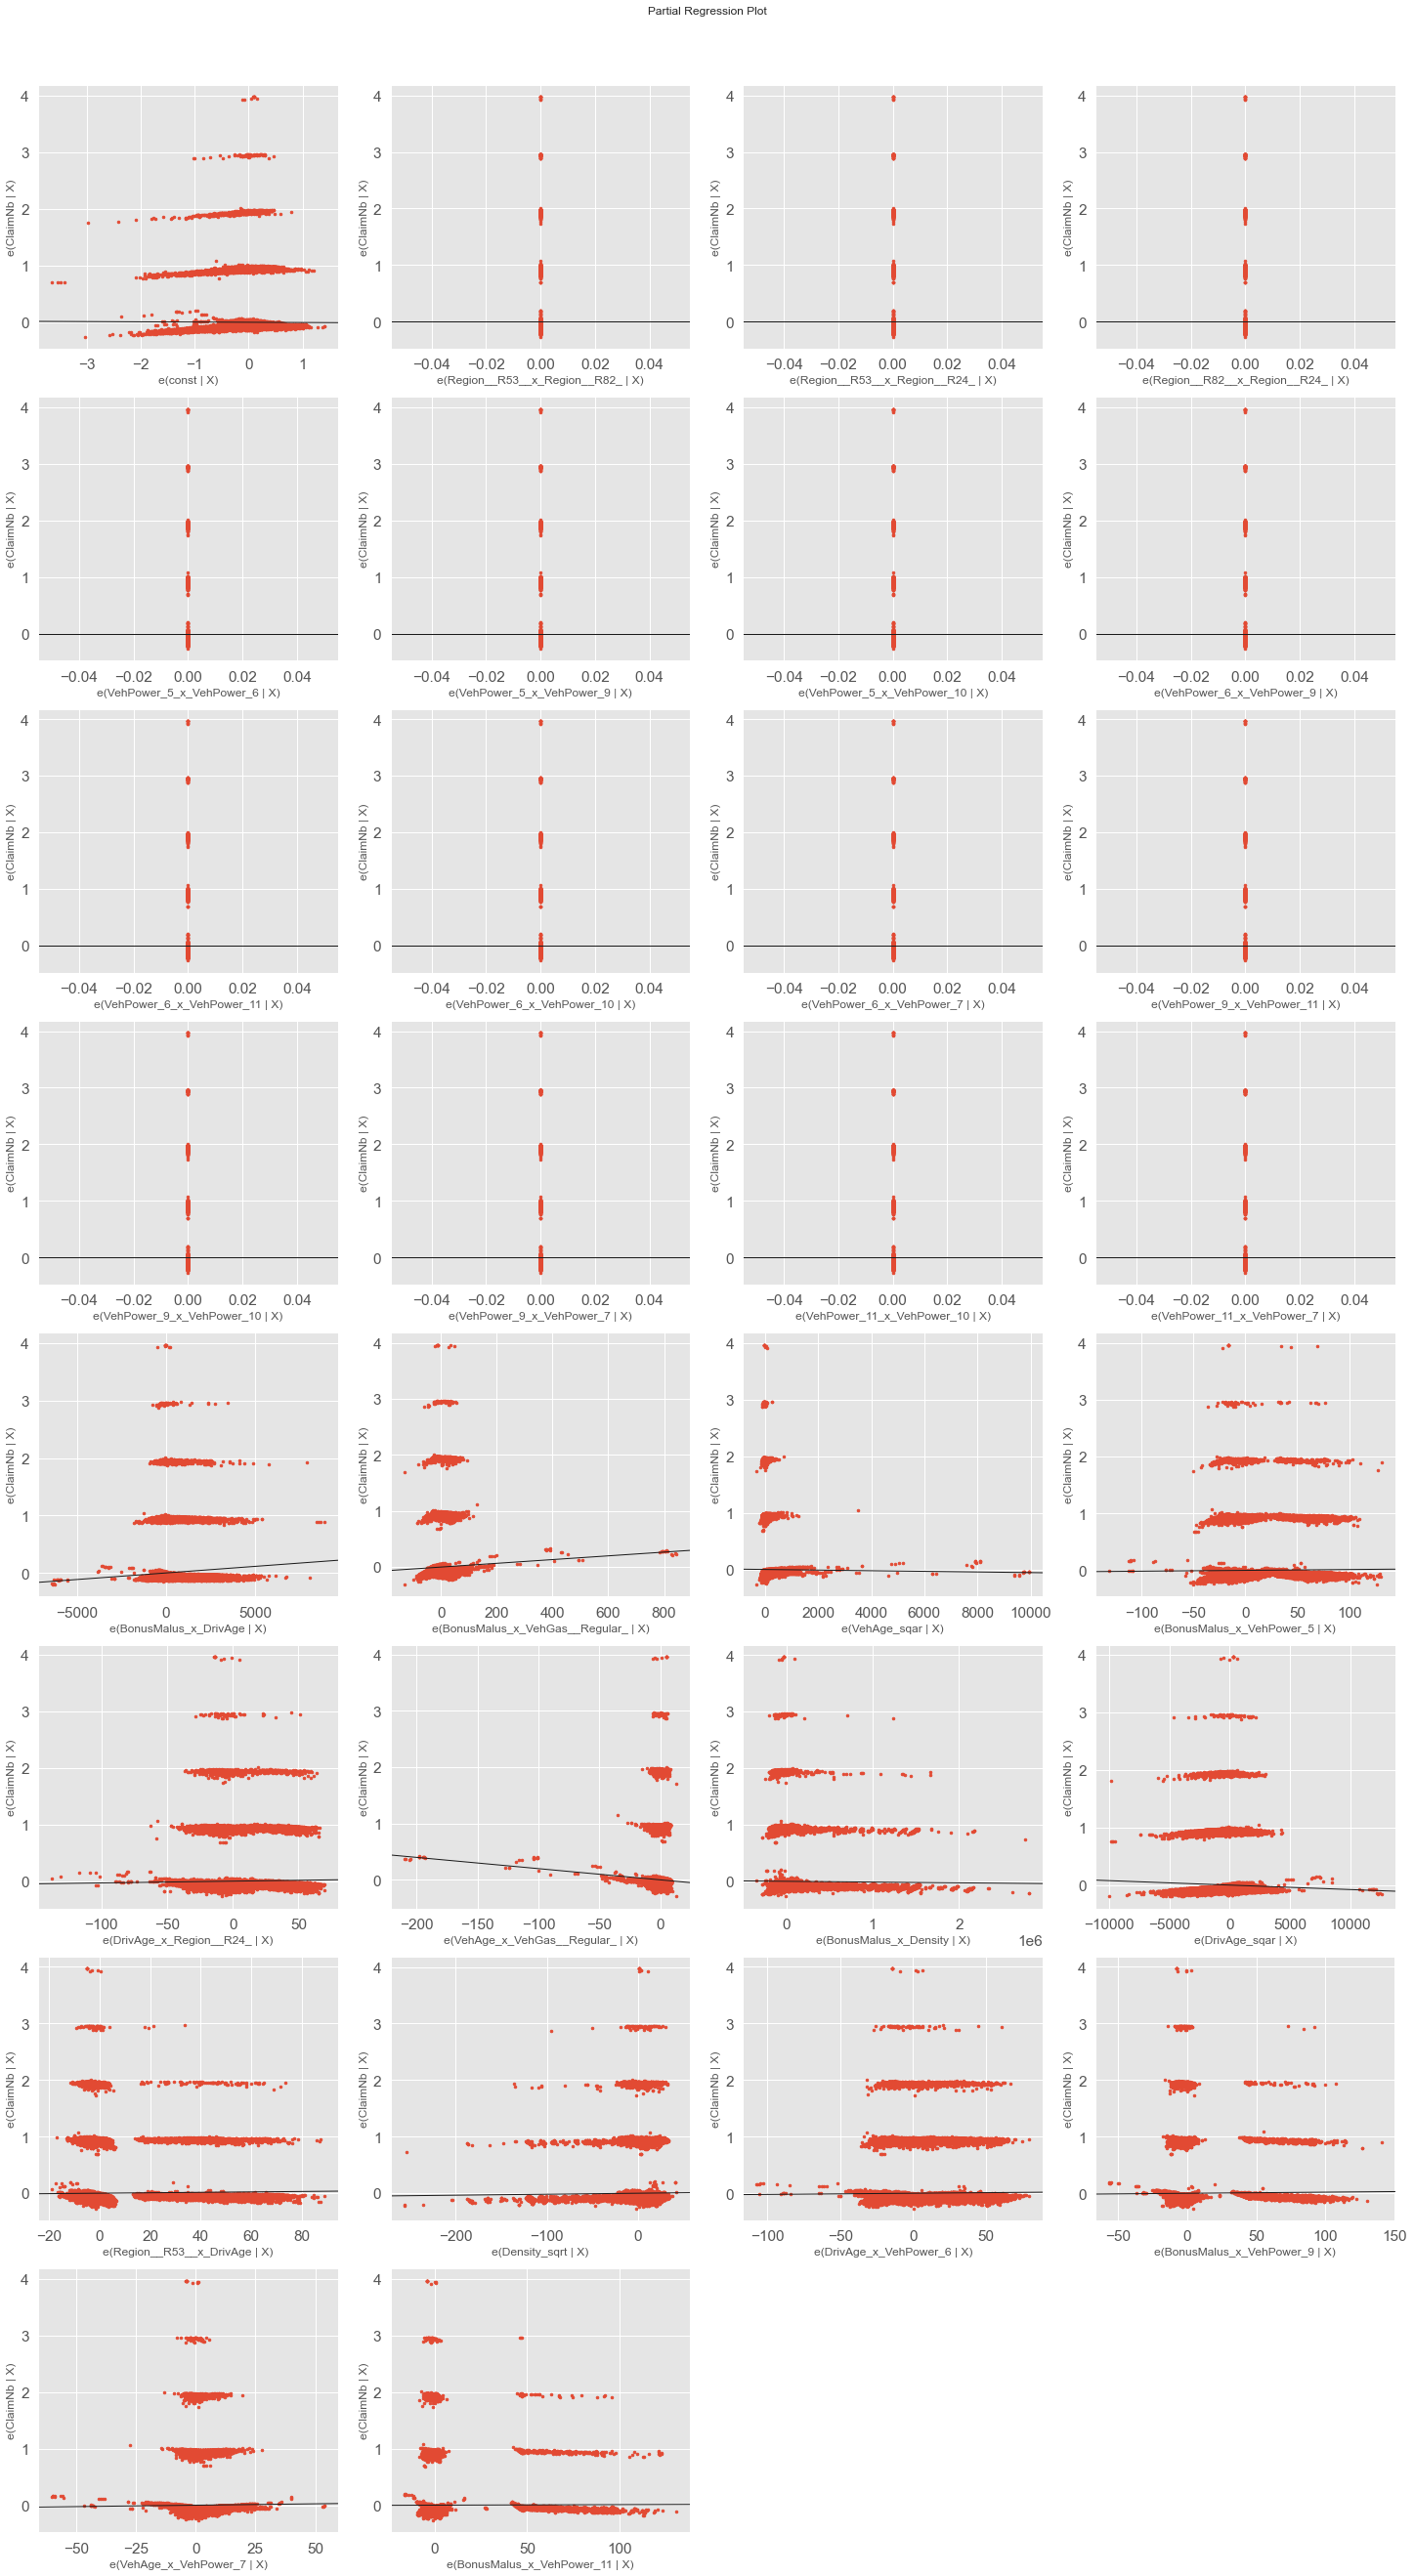


Poisson fit using reproducible random 80% (x_train & y_train) of data rows:

    Mean Absolute Residual = 0.10059982875860958
Root Mean Squared Residual = 0.23730650175517284
                        R² = 0.00575712588701282

Poisson prediction using remaining 20% (x_test & y_test) of data rows:

    Mean Absolute Error = 0.09912901152160482
Root Mean Squared Error = 0.23283138990693697
                     R² = 0.00505825810969374

Plots of train-set fit & test-set predict:


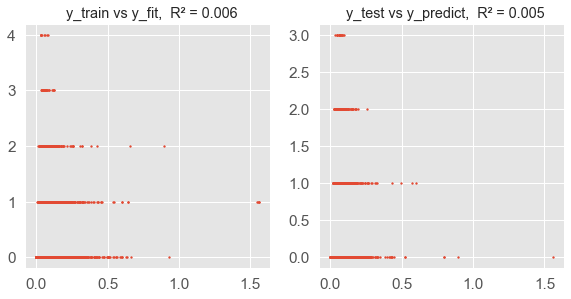

In [27]:
## Generalized Linear Model (GLM) with transformed variables & interaction variables (collinearity issue considered)

#For comparing Normal & GLM error distributions.

#algorithm is inefficient but clearer for instructional purposes
#favors fit with Xs' p-values < 0.05, and smaller rank-deficiency (number_of_Xs - Df_Model)

import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import pandas as pd

#set maximum window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #change code window width to max
pd.options.display.max_columns = 0 #change output window width to max

# 1 out of the 2 following lines should be active:
# d = '' #means nanes96 will be used
d = 1 #means use specified dataset instead of the default nanes96: d=''

if d == '':
    #American National Election Survey 1996 (anes96), http://statsmodels.org/dev/datasets/generated/anes96.html :
    dt = sm.datasets.anes96.load_pandas() #standard sm dataset, y (endog) and columns of X (exog)

    #peek at dataset:
    print('\nanes96 dataset:')
    print(dt.data)

    #this dataset actually not suitable for Poisson (although y is nonnegative integers)
    #    only used for illustrative purposes
    #many other datasets: http://statsmodels.org/dev/datasets

    #endogenous & exogenous component names:
    yname = dt.endog_name
    print('\ny =', yname, ' '*5, 'X =', dt.exog_name)
else:
    #d = 1 case:
    
    dt = df_clean.copy() #specifying 1st column as row labels (called 'index')
    #handle special variabes
    
    yname = 'ClaimNb' #target variable
    
    import regex as re
    dt.rename(columns=lambda x: re.sub('\W', '_', x), inplace=True) #replace ' ' by '_' in variable names
    yname = re.sub('\W', '_', yname)

    #delete any row with any missing value
    dt.dropna(how='any', inplace=True)
    if yname != dt.columns[0]:
        dt = dt[[yname] + list(dt.columns.drop(yname))]

    m2 = input('1: OLS (default), 2: Poisson, 3: Logit, 4: Probit, 5: Gamma, 6: InverseGaussian, 7: NegativeBinomial, 8: Tweedie, 9: Gaussian? ').strip()
    if m2 == '2':
        #https://www.statsmodels.org/stable/glm.html
        m = 'Poisson'
        dist = sm.families.Poisson()
    elif m2 == '3':
        m = 'Logit'
        dist = sm.families.Binomial()
    elif m2 == '4':
        m = 'Probit'
        #http://web.pdx.edu/~crkl/ceR/Python/example8_1.py
        dist = sm.families.Binomial(sm.genmod.families.links.probit)
    elif m2 == '5':
        m = 'Gamma'
        dist = sm.families.Gamma()
    elif m2 == '6':
        m = 'InverseGaussian'
        dist = sm.families.InverseGaussian()
    elif m2 == '7':
        m = 'NegativeBinomial'
        dist = sm.families.NegativeBinomial()
    elif m2 == '8':
        m = 'Tweedie'
        dist = sm.families.Tweedie()
    elif m2 == '9':
        m = 'GLM Gaussian'
        dist = sm.families.Gaussian()
    else:
        # m2 == 1 or ''
        m = 'Normal'
    
ytype = type('a')
if m == 'Normal':
    #there is a version of OLS that also requires endog and exog like GLM:
    #http://statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html
    #df has y followed by Xs:
    if d == '':
        df = pd.concat([dt.endog, dt.exog], axis=1) #a DataFrame
    else:
        df = dt
    y = yname
else:
    #df will not have y, but a column of 1s:
    if d == '':
        df = sm.add_constant(dt.exog) #add column of 1 to the left of dt.exog to form DataFrame
        y = dt.endog #PID: 0 to 6: Party IDentification of respondent (shades of Democrat or Republican)
    else:
        df = sm.add_constant(dt.iloc[:, 1:])
        y = dt.iloc[:, 0]
    ytype = type(y)
    
m3 = input('1: Reproducible output (input any integer except 2), 2: Random train-test data split [default: 1]? ').strip()
if m3 != '2':
    try:
        if m3 == '':
            m3 = 1
        else:
            m3 = int(m3)
        print(m3, 'entered.')
    except:
        m3 = 1 #can be changed to any integer for reproducible randomization
        print(m3, 'assumed.')

print('\nAssuming', m, 'error distribution.')

def delcorr(df):
    #delete any x too highly correlated with another x, to avoid collinearity

    #corr(Xs, y) ranked:
    
#     corv = pd.DataFrame() #start empty dataframe for corr(Xs, y) to come
#     for x in list(df)[1:]:
#         #during 1st time thru loop: new column, with label, created in empty dataframe:
#         #during subsequent time thru loop: new row, with row label, added to dataframe:
#         corv.loc[x, yname] = df[x].corr(df[yname] if m == 'Normal' else y)

#     corv = corv.loc[abs(corv).sort_values([yname]).index, :] #corr(Xs, y) ranked

    corv = df.iloc[:, 1:].corrwith(df[yname] if m == 'Normal' else y).rename(yname).sort_values(key=abs).to_frame()

    delta = 0.005 #corr difference lower limit
    dl2 = []
    icorr = True
    while icorr:
        a = abs(corv).diff() <= delta #adjacent rows with similar abs(corr(Xs, y))
        colname = list(df)[1:]
        dl = []
        print('\nX pairs with correlations >', 1 - delta, ':')
        for b in range(1, a.shape[0]):
            if a.iloc[b, 0]:
                if abs(df[a.index[b - 1]].corr(df[a.index[b]])) > 1 - delta:
                    #deleting 1 X from correlated pair:
                    dv0 = a.index[b - 1]
                    dv1 = a.index[b]

                    #neither should already be deleted:
                    if not (dv0 in dl) and not (dv1 in dl):
                        #delete x with rather lower corr(x, y):
                        if abs(corv.loc[dv0, y if type(y) == type('a') else y.name]
                              ) - abs(corv.loc[dv1, y if type(y) == type('a') else y.name]) >= delta:
                            d = dv1
                        elif len(dv0) < len(dv1): #delete x with longer name:
                            d = dv1
                        else:
                            d = dv0

                        dl.append(d) #for en masse deletion later
                        corv.drop([d], axis=0, inplace=True) #delete from column of corr with y

                        print(dv0,',',dv1)

        if len(dl) > 0:
            df.drop(axis=1, columns=dl, inplace=True) #variables deleted en masse
            dl2 = dl2 + dl #keep for real deletion later
            print('\n' + str(len(dl)), 'variables considered for deletion:')
            print('\n'.join([str(x) for x in dl]))
        else:
            print('(no more)')
            icorr = False
    return dl2
            
#delete collinear Xs:
dl2 = delcorr(df)
#df.drop(axis=1, columns=dl2, inplace=True) #collinear Xs deleted en masse #not necessary since df operated on directly
if len(dl2) > 0:
    print('\n' + str(len(dl2)) + ' variables deleted.')

#transform all Xs into either square & square-root or cube & cube-root using np.cbrt()

trf = ['_sqar', '_sqrt', '_cube', '_cbrt']

import numpy as np

for i in list(df)[1:]:
    #excluded either y or column of 1s
    failed = False
    try:
        #searching for -ve values:
        df[i + trf[1]] = np.sqrt(df[i])
        if df[i + trf[1]].isnull().any():
            #bug reported by Sharifah
            failed = True
            del df[i + trf[1]]
        else:    
            df[i + trf[0]] = df[i] ** 2.
    except:
        failed = True
    if failed:
        try:
            #searching for non-numeric
            df[i + trf[2]] = df[i] ** 3.
            df[i + trf[3]] = np.cbrt(df[i])
        except:
            #column cannot be transformed
            #delete non-numeric column (with no questions asked!):
            df.drop(i, axis=1, inplace=True) #remove any row with any NaN

#only numeric columns left
    
#delete collinear Xs:
df0 = df.copy()
dl2 = delcorr(df0)
dl2 = [x for x in dl2 if x[-5:] in trf]
if len(dl2) > 0:
    df.drop(axis=1, columns=dl2, inplace=True) #collinear transformed variables deleted en masse
    print('\n' + str(len(dl2)) + ' transformed variables deleted.')

from sklearn.model_selection import train_test_split
#split into training & testing sets
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 1:] if m == 'Normal' else df,
            df[y] if m == 'Normal' else y, test_size=.2,
            random_state=(None if m3=='2' else m3)) #set to an integer (here m3) to get reproducible output

#sort columns by absolute correlation with y, so may preferably delete last column if regression fails:
x_train = x_train[x_train.corrwith(y_train).sort_values(ascending=False, na_position='first', key=abs).index]

print('\nFit using', ('' if m3 == '2' else 'reproducible ') + 'random 80% (x_train & y_train) of data rows:')

#first do OLS on untransformed Xs:
df = pd.concat([y_train, x_train if m == 'Normal' else x_train.iloc[:, 1:]], axis=1)
xpure = [x for x in list(df) if x[-5:] not in trf]
numx = len(xpure) - 1
print('\nOLS fit including only', numx, 'untransformed Xs:')

#initialize for adj-R2:
ddf = np.inf #deficiency in degree of freedom = rank deficiency
maxR2 = -np.inf
bmodeleq = ''

bic0 = np.inf #bic kept by lowest overall rank deficiency
bic5 = bic0   #bic kept by best model with p-values < 0.05
bicd = bic0   #bic kept by lowest rank deficiency
bbic = bic0   #best bic kept by adj-R2

p05 = False #once found all Xs' p-values < 0.05

modeleq = ' + '.join(list(xpure)).replace('+', '~', 1)
from statsmodels.formula.api import ols
try:
    out = ols(modeleq, df).fit()
    print(out.summary2())
    if numx > 1:
        print("\nDescending order of", numx, "X's significance, assuming Normal error distribution:")
        print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
        #if the single best variable isn't high in above ranking, collinearity might be an issue
    
    dfm = int(out.df_model)

    ddf = numx - dfm #rank deficiency
    maxR2 = out.rsquared_adj
    bmodeleq = modeleq
    print('\n' + 'Rank deficiency =', str(ddf) + ': Df Model (' + str(dfm) + ') is',
          ('less than' if ddf > 0 else 'same as'), 'number of Xs (' + str(numx) + ').')
except:
    pass
    
print('\n'+ m, 'fit including transformed Xs:')

if m != 'Normal':
    #undo above ols:
    ddf = np.inf
    maxR2 = -np.inf
    bmodeleq = ''
    
    df = x_train
    y = y_train
    
#initialize for rank deficiency:
ddfd = ddf #best rank deficiency
R2df = maxR2 #R2 for best rank deficiency
modeleqdf = bmodeleq #modeleq for best rank deficiency

#initialize for overall rank deficiency
ddf0 = ddfd
R2df0 = R2df
modeleqdf0 = modeleqdf

bddf = ddfd #rank deficiency for best adj-R2 model

#initialize for z-stat p-values < 0.05:
ddf5 = np.inf #rank deficiency for best model with p-values < 0.05
R205 = -np.inf #adj-R2 for best model with p-values < 0.05
modeleq05 = '' #modeleq for best model with p-values < 0.05

df0 = df.copy() #kept for inclusion of interaction variables later

#perform feature selection using adjusted R2

#model equation actually not used by GLM:
modeleq = ' + '.join(list(df)).replace('+', '~', 1)
#print(modeleq)
numx = df.shape[1] - 1

x1x2 = False #interaction variables not yet included

while True:
    if m == 'Normal':
        #https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html
        out = ols(modeleq, df).fit()
        R2 = out.rsquared_adj
    else:
        #GLM distribution
        try:
            #https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html
            out = sm.GLM(y, df, family=dist).fit()
            R2 = 1 - (1 - y.corr(out.fittedvalues)**2) * (out.nobs - 1) / out.df_resid #pseudo adjusted r2
            if R2 != R2 and out.fittedvalues.isna().sum() == 0:
                R2 = -np.inf
                #R2 = -out.bic
        except:
            #GLM failed!  do ols for this round, just to delete 1 x:
            try:
                out = ols(' + '.join(list(df)).replace('+', '~', 1), df).fit() #do OLS instead
            except:
                pass
            R2 = -np.inf
    
    try:
        maxp = max(out.pvalues[1:])
        dfm = int(out.df_model)
    except:
        maxp = 1
        dfm = 0
    ddf = numx - dfm #rank deficiency
    
    #see if a better model is found:
    try:
        if R2 >= maxR2 and out.fittedvalues.isna().sum() == 0:
            maxR2 = R2
            bmodeleq = modeleq
            bddf = min(bddf, ddf)

            ddf0 = ddf #best overall rank deficiency

            if maxR2 == -np.inf:
                bbic = out.bic

            if maxp >= 0.05 and not p05:
                #reset z-stat p-value criterion:
                R205 = -np.inf
                modeleq05 = ''

                #reset rank deficiency criterion:
                R2df = R205
                modeleqdf = ''
                ddfd = bddf #reset deficient df
            else:
                p05 = True
            #if m != 'Normal':
            #    df1 = df.copy()

        #see if a model is found with reduced overall rank deficiency:
        if ddf < ddf0 or (ddf == ddf0 and R2 > R2df0):
            R2df0 = R2
            modeleqdf0 = modeleq
            ddf0 = ddf #best overall rank deficiency
            if maxR2 == -np.inf:
                bic0 = out.bic

        #see if a better model is found with max(z-stat p-value) < .05:
        if maxp < .05 and (R2 > R205 or modeleq05 == ''):
            R205 = R2
            modeleq05 = modeleq
            ddf5 = min(ddf5, ddf) #rank deficiency for best model with p-values < .05
            if maxR2 == -np.inf:
                bic5 = out.bic

        #see if a model is found with reduced rank-deficiency:
        if ddf < ddfd or (ddf == ddfd and R2 > R2df):
            R2df = R2
            modeleqdf = modeleq
            ddfd = min(ddfd, ddf) #best rank deficiency
            if maxR2 == -np.inf:
                bicd = out.bic
    except:
        pass

    print('\nAdjusted R² =', R2, ', max(X p-value) =', maxp, ', rank deficiency =', ddf, ', for', numx, 'Xs.')

    if numx == 1:
        print('Variable left:', modeleq[modeleq.find('~') + 2 :])
        if x1x2:
            #one xvar left
            #get out of 'while' loop:
            break
            
        else:
            if maxR2 == -np.inf and out.fittedvalues.isna().sum() > 0:
                print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')
                #use all Xs before deletion:
                bmodeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            else:
                #see if best model with all z-stat p-values < 0.05 is smaller than best model by adjusted R2:
                if (R205 > -np.inf and len(modeleq05) < len(bmodeleq)) or (
                    R205 == -np.inf and (maxR2 == -np.inf or (len(modeleq05) > 0 and len(modeleq05) < len(bmodeleq)))):
                    bmodeleq = modeleq05
                    maxR2 = R205
                    #bddf = min(bddf, ddf5)
                    bddf = ddf5
                    
                    if maxR2 == -np.inf:
                        bmodeleq0 = bmodeleq
                        bddf0 = bddf
                        bbic = bic5 #best bic
                        bic5 = np.inf #re-initialize

                #see if model with smallest rank-deficiency is smaller than best model so far:
                if (R2df > -np.inf and len(modeleqdf) < len(bmodeleq)) or (
                    R2df == -np.inf and (maxR2 == -np.inf or (len(modeleqdf) > 0 and len(modeleqdf) < len(bmodeleq)))):
                    bmodeleq = modeleqdf
                    maxR2 = R2df
                    #bddf = min(bddf, ddfd)
                    bddf = ddfd
                    
                    if maxR2 == -np.inf:
                        bmodeleq0 = bmodeleq
                        bddf0 = bddf
                        bbic = bicd #best bic
                        bicd = np.inf #re-initialize
        
                if maxR2 == -np.inf:
                    #reset z-stat p-value criterion:
                    R205 = -np.inf
                    modeleq05 = ''

                    #reset rank deficiency criterion:
                    R2df = R205
                    modeleqdf = ''
                    ddfd = np.inf #reset deficient df
            
            #add interaction variables for original untransformed variables in best model so far
            
            numx = bmodeleq.count('+') + 1
            if numx == 0:
                bmodeleq = ' + '.join(list(df0)).replace('+', '~', 1)
                numx = bmodeleq.count('+') + 1
            print('\nRestarting from best model (with', numx, 'Xs & Adjusted R² =', str(maxR2) + ') found so far...')
            
            colname = bmodeleq.replace('~', '+').split(' + ')
            df = df0[colname]
            colname = colname[1:] #remove y or 'const'
            x_test = x_test[colname]
            
#             for i in range(numx):
#                 #look for 1st transformed variable:
#                 if colname[i][-5:] in trf:
#                     i = i - 1
#                     #colname[i] is the last untransformed x
#                     break
            
#             #actually, nothing to do if i<=0
#             print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
#                   'untransformed variables in best model found so far:')
#             for j in range(i):
#                 #untransformed x in colname up to [i]
#                 for k in range(j + 1, i + 1):
#                     a = colname[j] + '_x_' + colname[k]
#                     print(a)
#                     df[a] = df[colname[j]] * df[colname[k]]
#                     x_test[a] = x_test[colname[j]] * x_test[colname[k]]
                    
            xpure = [x for x in colname if x[-5:] not in trf] #untransformed x names
            i = len(xpure) - 1
            
            #actually, nothing to do if i<=0
            print('\nAdding', int((i + 1) * i / 2), '2-way interactions among', i + 1,
                  'untransformed variables in best model found so far:')
            for j in range(i):
                #untransformed x in colname up to [i]
                for k in range(j + 1, i + 1):
                    a = xpure[j] + '_x_' + xpure[k]
                    print(a)
                    df[a] = df[xpure[j]] * df[xpure[k]]
                    x_test[a] = x_test[xpure[j]] * x_test[xpure[k]]

            df0 = df.copy()
            
            #delete collinear Xs introduced:
            dl2 = delcorr(df)
            dl2 = [x for x in dl2 if x.find('_x_') != -1] #only interaction variables kept
            if len(dl2) > 0:
                df0.drop(axis=1, columns=dl2, inplace=True) #collinear interaction variables deleted en masse, for real
                x_test.drop(axis=1, columns=dl2, inplace=True)
                #remaining Xs may be collinear
                print('\n' + str(len(dl2)) + ' interaction variables deleted.')
            
            #potential collinearity issues handled
            
            #sort columns by absolute correlation with y, so may delete last column if regression fails:
            #df0 = df0[df0.corrwith(y_train).sort_values(ascending=False, na_position='first', key=abs).index]
            df0 = df0[[df0.columns[0]] + list(df0.iloc[:, 1:].corrwith(y_train)
                                              .sort_values(ascending=False, na_position='first', key=abs).index)]

            modeleq = ' + '.join(list(df0)).replace('+', '~', 1)
            numx = df0.shape[1] - 1
            if maxR2 == -np.inf:
                bddf = np.inf
                ddf5 = bddf
                ddfd = bddf
                p05 = False
            x1x2 = True #interaction variables already included
            
            #beyond-pairwise collinearity may still be introduced with the interaction variables
            
            df = df0.copy() #ready for continuing deletion
            continue

    #identify X variable to delete by finding the one with smallest abs(t-stat):
    t = out.tvalues[1:]
    try:
        xdrop = list(t[abs(t) == min(abs(t))].index)[-1]
    except:
        xdrop = list(t.index)[-1]
    print('Variable to drop:', xdrop)
    
    try:
        df.drop(xdrop, axis=1, inplace=True)
    
    except:
        pass
    
    modeleq = ' + '.join(list(df)).replace('+', '~', 1)
    
    numx = numx - 1

#see if best model with all z-stat p-values < 0.05 is smaller than best model by adjusted R2:
if (R205 > -np.inf and len(modeleq05) < len(bmodeleq)) or (
    R205 == -np.inf and (maxR2 == -np.inf or (len(modeleq05) > 0 and len(modeleq05) < len(bmodeleq)))):
    bmodeleq = modeleq05
    maxR2 = R205
    bddf = ddf5

#see if model with smallest rank-deficiency is smaller than best model so far:
if (R2df > -np.inf and len(modeleqdf) < len(bmodeleq)) or (
    R2df == -np.inf and (maxR2 == -np.inf or (len(modeleqdf) > 0 and len(modeleqdf) < len(bmodeleq)))):
    bmodeleq = modeleqdf
    maxR2 = R2df
    bddf = ddfd

if maxR2 == -np.inf and out.fittedvalues.isna().any():
    #some nan in y fit
    print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')
else:
    try:
        if bddf >= ddf0 and ((maxR2 > -np.inf and R2df0 >= maxR2) or (maxR2 == -np.inf and bic0 <= bbic)):
            bmodeleq_0 = bmodeleq
            maxR2_0 = maxR2
            bddf_0 = bddf
            
            #prefer smaller rank deficiency
            if m == 'Normal':
                out = ols(modeleqdf0, df0).fit()
            else:
                out = sm.GLM(y, df0[modeleqdf0.replace('~', '+').split(' + ')], family=dist).fit()
            if max(out.pvalues[1:]) < 0.05:
                #Xs' p-values < 0.05
                bmodeleq = modeleqdf0
                maxR2 = R2df0
                bddf = ddf0
    except:
        bmodeleq = bmodeleq_0
        maxR2 = maxR2_0
        bddf = bddf_0
        
    try:
        if m == 'Normal':
            out = ols(bmodeleq, df0).fit()
            #collinearity is still entirely possible at this stage
            x_test = x_test[df0.columns[1:]]
        else:
            #out = sm.GLM(y, df1, family=dist).fit()
            #x_test = sm.add_constant(x_test)[df1.columns]
            df0 = df0[bmodeleq.replace('~', '+').split(' + ')]
            out = sm.GLM(y, df0, family=dist).fit()
            x_test = sm.add_constant(x_test)[df0.columns]

        numx = bmodeleq.count('+') + 1
        print('\nBest model has', numx, 'Xs (Adjusted R² =', str(maxR2), ', rank deficiency =', str(bddf) + '):\n')
        print(out.summary2())

        if m == 'Normal':
            print()

        if numx > 1:
            print("Descending order of", numx, "X's significance, assuming", m, 'error distribution:')
            #print('\n'.join(list(abs(out.tvalues[1:]).sort_values(0, ascending=False).index)))
            print(pd.concat([pd.concat([out.params[:1], out.tvalues[:1]], 1), pd.concat([out.params[1:], out.tvalues[1:]], 1
                   ).sort_values(1, key=abs, ascending=False)]).rename(columns={0:"Coefficient", 1:"z-stat"}))
            #if the single best variable isn't high in above ranking, collinearity might be an issue

        dfm = int(out.df_model)
        print('\n' + 'Rank deficiency =', str(bddf) + ': Df Model (' + str(dfm) + ') is',
              ('less than' if bddf > 0 else 'same as'), 'number of Xs (' + str(numx) + ').')
        
        import matplotlib.pyplot as pl
        %matplotlib inline
        pl.rcParams['lines.markersize'] = 2.5
        pl.rcParams['lines.linewidth'] = 1

#         if m == 'Normal':
        #partial leverage plots, partial regression plots, added-variable plots
        #https://r-bloggers.com/2021/03/partial-regression-plots-in-julia-python-and-r
        #https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_partregress.html
        #https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.plot_partregress_grid.html

        from statsmodels.graphics.regressionplots import plot_partregress_grid
        import math
        #includes intercept; 4 plots to a row:
        nr = math.ceil((numx + 1) / 4) #number of rows of plots
        pl.rcParams["figure.figsize"] = (20.2, 14 / 3 * nr) #plot height depends on number of rows of plots
        print('\nPartial Leverage (or Partial Regression, or Added-Variable) diagnostic plots for fit:')
        #grid(rows, columns) for plots; fixed at 4 columns of plots per row:
        plot_partregress_grid(out, grid=(nr, 4))
        pl.show()

        y_fit = out.fittedvalues
        y_train = df.iloc[:, 0] if m == 'Normal' else y
        print('\n'+ m, 'fit using', ('' if m3 == '2' else 'reproducible ') + 'random 80% (x_train & y_train) of data rows:\n')
        print('    Mean Absolute Residual =', abs(y_train - y_fit).mean())
        print('Root Mean Squared Residual =', np.sqrt(((y_train - y_fit) ** 2.).mean()))
        r2_train = y_train.corr(y_fit) ** 2.
        print('                        R² =', r2_train)

        y_predict = out.predict(x_test) #forecast
        print('\n' + m, 'prediction using remaining 20% (x_test & y_test) of data rows:\n')
        print('    Mean Absolute Error =', abs(y_test - y_predict).mean())
        print('Root Mean Squared Error =', np.sqrt(((y_test - y_predict) ** 2.).mean()))
        r2_test = y_test.corr(y_predict) ** 2.
        print('                     R² =', r2_test)

        print('\nPlots of train-set fit & test-set predict:')
    
        #plot y_train vs y_fit
        #https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python
#         pl.rcParams["figure.figsize"] = (4.04, 4.04)
        pl.rcParams["figure.figsize"] = (20.2, 4.5)
#         pl.rcParams['lines.markersize'] = 3
        pl.subplot(1, 4, 1) #1 row, 4 columns, plot 1
        pl.title('  y_train vs y_fit,  R² = ' + str(round(r2_train, 3)))
        pl.scatter(y_fit, y_train, s=3)
#         pl.show()

        #plot y_test vs y_predict
        pl.subplot(1, 4, 2) #1 row, 4 columns, plot 2
        pl.title('  y_test vs y_predict,  R² = ' + str(round(r2_test, 3)))
#         pl.scatter(y_predict, y_test, s=3);
        pl.scatter(y_predict, y_test, s=3)
        pl.show()
    except:
        print('\n*** Y variable', yname if m == 'Normal' else y.name, 'might not work with', m, 'distribution.')

#### Comments:

The above code takes care of transformation variables , interaction variable, collinearity and does variable selection to find the best model equation for our poisson model.

As the P-value coefficient variables decreases towards zero, these variables are more statistically significant and are used for model prediction of ClaimNb in our Poisson Model.

A positive sign for the coefficient of the variable indicates that as the independent variable increases, the mean number of claims will increase.

After training the Poisson model, we use our trained model to predict the test set.


In [28]:
#Compute estimated dispersion of fitted Poisson Model
print("Mean of Number of Claims = ", df_clean["ClaimNb"].mean())
print("Variance of Number of Claims = ", df_clean["ClaimNb"].var())

pearson_chi_squared = out.pearson_chi2
degree_of_freedom_residual = out.df_resid

ratio = pearson_chi_squared / degree_of_freedom_residual
print("Overdispersion Parameter Ratio = ", ratio)

#Adapated from https://s3.amazonaws.com/assets.datacamp.com/production/course_15356/slides/chapter3.pdf
#Ratio = 1 → approximately Poisson
#Ratio < 1 → underdispersion
#Ratio > 1 → overdispersion

Mean of Number of Claims =  0.05296902611101351
Variance of Number of Claims =  0.05620434048833404
Overdispersion Parameter Ratio =  1.0573008949413947


#### Comments

A common source of failure of the Poisson regression model is that the data does not satisfy the sample mean = sample variance criterion imposed by the Poisson distribution. If the sample variance is much greater than the sample mean, there’s overdispersion. Then, we proceed to try fitting the training set with a Negative Bionomial Regression model as this does not make the mean = variance assumption about the data.

From the results above, even though the sample variance > sample mean, this deviation is not huge. The calculated overdispersion ratio for the fitted model is also close to 1, which shows approximate Poisson dispersion. Thus, we can assume that there is no overdispersion and the sample variance is estimated to be close enough to the sample mean. Hence, the Poisson model is still valid in predicting the number of insurance claims in this case.

## 200 Word Summary

In [ ]:
#Number of insurance claims are discrete counts that occur at a random rate of occurrences and the claims occur independently. 
#Unlike regression models, GLMs are not constrained to a normal distribution and can predict number of claims having a non-linear distribution.
#Interaction, Collinearity and Variable selection was used to find best model equation. 
#After fitting all the GLM models, the Poisson regression prediction on the test set has the highest R^2 value of 0.028 where fraction of total variation in test set accounted by the model is low.
#This maybe attributed to the random occurrence of insurance claims in real life and a high proportion number of zero claims.
#The test RMSE = 0.249 and MAE = 0.109 (robust to outliers) is low, implying that our model can generalize predictions of number of claims with high accuracy. 
#It is noted that the variance = mean for number of claims is approximately equal, the validity of our Poisson model holds.
#The variables used for training the model are statistically significant with low P-values where VehAge_x_VechPower_15 will cause the largest decrease in number of claims.
#Zero-inflated Poisson regression maybe employed to account for excess zero counts and predict number of insurance claims.